In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.image import imread

import plotly.express as px
from tqdm.notebook import tqdm, trange

tqdm.pandas()

from scipy import stats
from scipy.spatial import Voronoi
from scipy.spatial import distance
from scipy.spatial import voronoi_plot_2d
from scipy.stats import logrank
from scipy.stats import pointbiserialr

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.compare import compare_survival

import shapely
from shapely.geometry import Point, Polygon

import statsmodels as sm
from statsmodels.discrete.discrete_model import Logit
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

In [2]:
from lifelines import AalenAdditiveFitter
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines.utils import restricted_mean_survival_time
from lifelines import WeibullAFTFitter
from sksurv.linear_model import CoxPHSurvivalAnalysis


In [ ]:
def create_nfl_field() -> np.ndarray:
    """creates a simplified image of a football field as a background for rendering

    Returns:
        np.ndarray: the image in form of a np.array of the shape (x, y, 3)
    """
    empty_field = np.zeros((533, 1200, 3), dtype=np.int16) + np.array([50, 130, 20])
    empty_field[:, 0:100] = 127
    empty_field[:, 1100:] = 127
    empty_field[:, 90:101] = 255
    empty_field[:, 1100:1111] = 255
    for i in range(150, 1051, 50):
        empty_field[:, i - 2 : i + 3] = 255
    for i in range(110, 1091, 10):
        empty_field[:10, i - 1 : i + 2] = 255
        empty_field[-10:, i - 1 : i + 2] = 255
        empty_field[197:208, i - 1 : i + 2] = 255
        empty_field[327:338, i - 1 : i + 2] = 255
    return empty_field

In [3]:
def snap_filter(df):
    """
    use to add new column that is True whenever ball was snapped and NaN or False otherwise
    """
    if "ball_snap" in df.event.unique():
        frame = df.loc[df.event == "ball_snap", "frameId"].iat[0]
        df["is_snapped"] = df.frameId.ge(frame)

        return df.groupby("frameId").agg({"is_snapped": "max"})
    else:
        df["is_snapped"] = 1
        return df.groupby("frameId").agg({"is_snapped": "max"})

In [ ]:
def add_snapped_filter_col(df):
    """add boolean indicating when ball was snapped"""
    snap_df = (
        df[["gameId", "playId", "nflId", "frameId", "event"]]
        .groupby(["gameId", "playId"])
        .apply(snap_filter)
        .reset_index()
    )
    if "is_snapped" in df.columns:
        df = df.drop(
            columns="is_snapped"
        )  # easiest way codewise, else merge will rename cols
    df = pd.merge(
        df,
        snap_df[["gameId", "playId", "frameId", "is_snapped"]],
        on=["gameId", "playId", "frameId"],
    )
    return df

In [ ]:
def calc_qb_space(fdf: pd.DataFrame, qb_clip0=0, qb_clip1=55) -> dict:
    """Compute the safe space around the QB. Is supposed to be used during df.groupby operations
    
    Args: 
        fdf (pd.DataFrame): pandas dataframe containing tracking data and scouting data.
        qb_clip0(float) = Lower bound for qb y-coordinate. Defaults to 0. 
        qb_clip1(float) = Upper bound for qb y-coordinate. Defaults to 55. 
        
    Returns: 
        Dictionary containing distance to closest rusher polygon, distance to clostest 
        polygon corner, and binary flag whether qb is considered in danger.  
        
    """
    points = np.stack(
        [
            fdf[fdf.pff_role.isin(["Pass Block", "Pass Rush"])].x.to_numpy(),
            fdf[fdf.pff_role.isin(["Pass Block", "Pass Rush"])].y.to_numpy(),
        ],
        axis=-1,
    )
    points = np.append(
        points, [[999, 999], [-999, 999], [999, -999], [-999, -999]], axis=0
    )
    vor = Voronoi(points)

    def_line_regions = (
        fdf[fdf.pff_role.isin(["Pass Block", "Pass Rush"])].pff_role == "Pass Rush"
    ).to_numpy()
    regions = vor.point_region[np.concatenate([def_line_regions, [False] * 4])]

    if len(regions) < 1:
        return {"qb_radius": 5.0, "qb_danger": False, "polydist": 5}

    def_pts = [
        [vor.vertices[vert] for vert in vor.regions[reg] if vert > -1]
        for reg in regions
        if len(vor.regions[reg]) > 0
    ]
    def_pts = np.concatenate(
        [np.stack(dpts, axis=0) for dpts in def_pts if len(dpts) > 0]
    )
    def_polys = []
    for reg in regions:
        if len(vor.regions[reg]) > 2:
            def_polys.append(Polygon([vor.vertices[vert] for vert in vor.regions[reg]]))

    qb_coords = np.stack(
        [
            fdf[fdf.pff_role == "Pass"].x.to_numpy(),
            np.clip(fdf[fdf.pff_role == "Pass"].y.to_numpy(), qb_clip0, qb_clip1),
        ]
    ).T
    radius = distance.cdist(qb_coords, def_pts).min()
    qb_danger = def_line_regions[distance.cdist(qb_coords, points).argmin()]

    if len(def_polys) < 1:
        print(fdf.gameId.iat[0], fdf.playId.iat[0], fdf.frameId.iat[0])
        return {"qb_radius": radius, "qb_danger": qb_danger, "polydist": 5}

    qb_pt = Point(qb_coords)
    polydist = min([poly.distance(qb_pt) for poly in def_polys])

    return {"qb_radius": radius, "qb_danger": qb_danger, "polydist": polydist}

### Some helper functions for pandas data wrangling. 

In [6]:
def mean_polydist(df):
    return df.polydist.mean()

In [7]:
def pass_frame(df):
    if df.event.isin(["pass_forward", "autoevent_passforward"]).sum() > 0:
        return (
            df[
                (df.event == "pass_forward") | (df.event == "autoevent_passforward")
            ].frameId.min()
            - df[df.is_snapped==1].frameId.min()
        )
    return - (df.frameId.max() - df[df.is_snapped==1].frameId.min())

In [8]:
def min_frame(df):
    return df.frameId.min()


def poly_frame(df):
    if df.polydist.min() > 0.001:
        return -1
    return (
        df[df.polydist <= 0.001].frameId.min() - df.frameId.min()
    )  # inefficient but elegant

In [9]:
def surv_frame(df):
    if df.polydist.min() > 0.0:
        return df.frameId.max() - df.frameId.min()
    return df[df.polydist == 0.0].frameId.min() - df.frameId.min()

In [10]:
def pblockwin(df):
    snap = df.frameId.min()
    if df.polydist.min() < (0.001):
        collapse = df[df.polydist.le(0.001)].frameId.min()
        return collapse - snap >= 25
    return True

In [ ]:
# https://stackoverflow.com/questions/45033980/how-to-compute-aic-for-linear-regression-model-in-python
def llf_(y, X, pr):
    # return maximized log likelihood
    nobs = float(X.shape[0])
    nobs2 = nobs / 2.0
    nobs = float(nobs)
    resid = y - pr
    ssr = np.sum((resid) ** 2)
    llf = -nobs2 * np.log(2 * np.pi) - nobs2 * np.log(ssr / nobs) - nobs2
    return llf


def calc_aic(y, X, pr, p):
    # return aic metric
    llf = llf_(y, X, pr)
    return -2 * llf + 2 * p

## Modeling Pocket Dynamics accross space and time using Survival analysis

#### we are interested in pocket dynamics in pass plays, especially in the sense of how long are the linemen able to provide a safe space for their QB in case of the offense line and how quickly they can collapse the pocket in case of the defensive player in contrast to the time it takes the QB to throw the pass. In order to achieve this, we use frame level spatial analysis and combine it with survival analysis for temporal analysis. First, we create the voronoi tesselation of all players that are pass rushing or pass blocking. The pocket size is defined as the euclidean distance between the QB and the voronoi region of a pass rusher. The pocket is considered collapsed once the distance reaches 0, i.e. QB is in a pass rushers voronoi region, the QB is no longer safe. 

#### The data we are using is from passing plays of the first 8 weeks of the 2021 NFL regular season. We only consider plays with 4-8 defenders in the box, no JUMBO or WILDCARD formations, No designed runs and no 4th downs. This leaves us with over 8000 passing plays of various teams, players and game situations.  

In [ ]:
scouting = pd.read_parquet(
    "nfl-big-data-bowl-2023/scouting.parquet", engine="fastparquet"
)
games = pd.read_parquet("nfl-big-data-bowl-2023/games.parquet", engine="fastparquet")
players = pd.read_parquet(
    "nfl-big-data-bowl-2023/players.parquet", engine="fastparquet"
)
plays = pd.read_parquet("nfl-big-data-bowl-2023/plays.parquet", engine="fastparquet")


try: 
    week = pd.read_parquet("nfl-big-data-bowl-2023/tracking.parquet", engine="fastparquet")
    week_wscout = pd.read_parquet(
        "nfl-big-data-bowl-2023/tracking_wscout.parquet", engine="fastparquet"
    )
except FileNotFoundError: # if parquet file does not exists. 
    weeks = [pd.read_csv(f"nfl-big-data-bowl-2023/week{i}.csv") for i in trange(1,9)]
    week = pd.concat([add_snapped_filter_col(wk) for wk in weeks], ignore_index=True)
    week.to_parquet("nfl-bid-data-bowl-2023/tracking.parquet", engine="fastparquet")
    
    week_wscout = pd.merge(week[week.nflId.notna()], scouting, on=["gameId", "playId", "nflId"])
    week.to_parquet("nfl-bid-data-bowl-2023/tracking_wscout.parquet", engine="fastparquet")


In [13]:
nflverse_pbp = pd.read_parquet(
    "nfl-big-data-bowl-2023/play_by_play_2021.parquet",
    engine="fastparquet",
    columns=[
        "play_id",
        "old_game_id",
        "touchdown",
        "air_yards",
        "ep",
        "epa",
        "qb_epa",
        "xyac_epa",
        "xyac_mean_yardage",
        "xyac_success",
        "xyac_fd",
        "xpass",
        "pass_oe",
    ],
)
nflverse_pbp["old_game_id"] = pd.to_numeric(
    nflverse_pbp["old_game_id"], downcast="integer"
)
nflverse_pbp["play_id"] = pd.to_numeric(nflverse_pbp["play_id"], downcast="integer")
plays = pd.merge(
    plays,
    nflverse_pbp,
    how="left",
    left_on=["gameId", "playId"],
    right_on=["old_game_id", "play_id"],
)

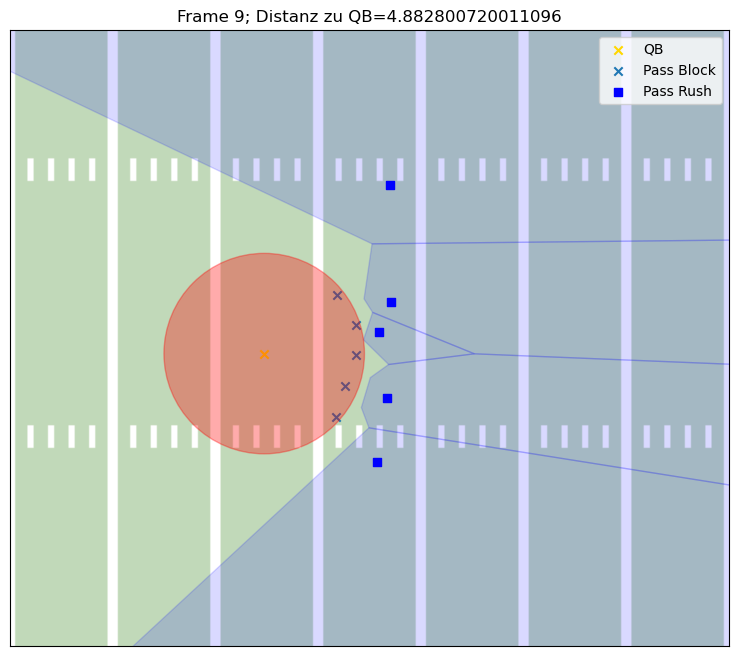

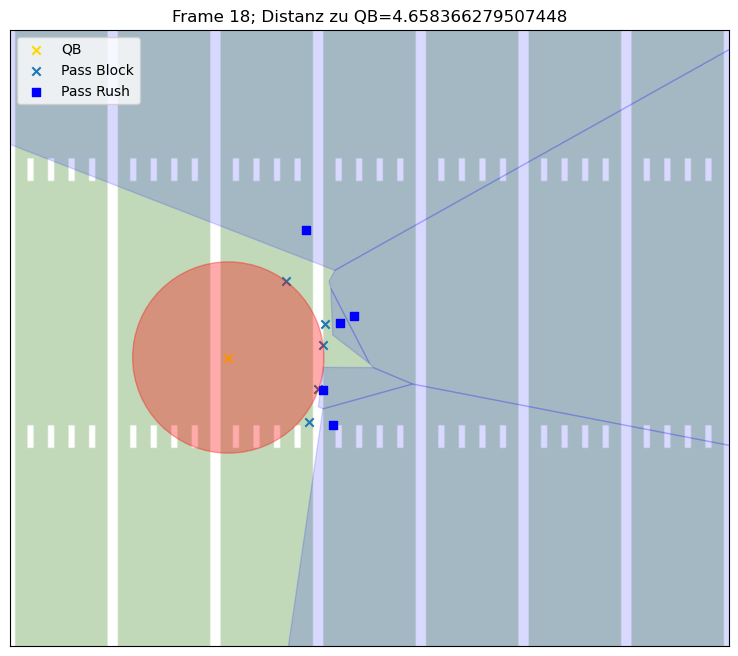

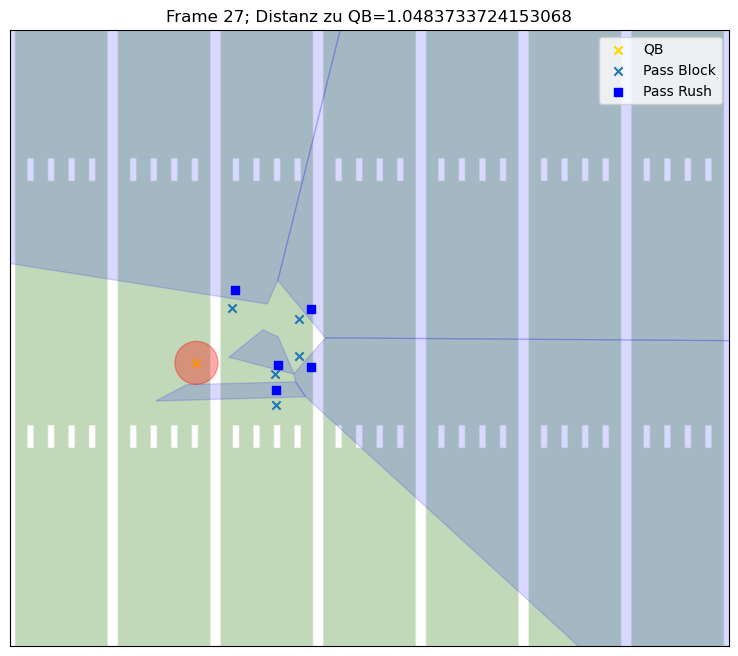

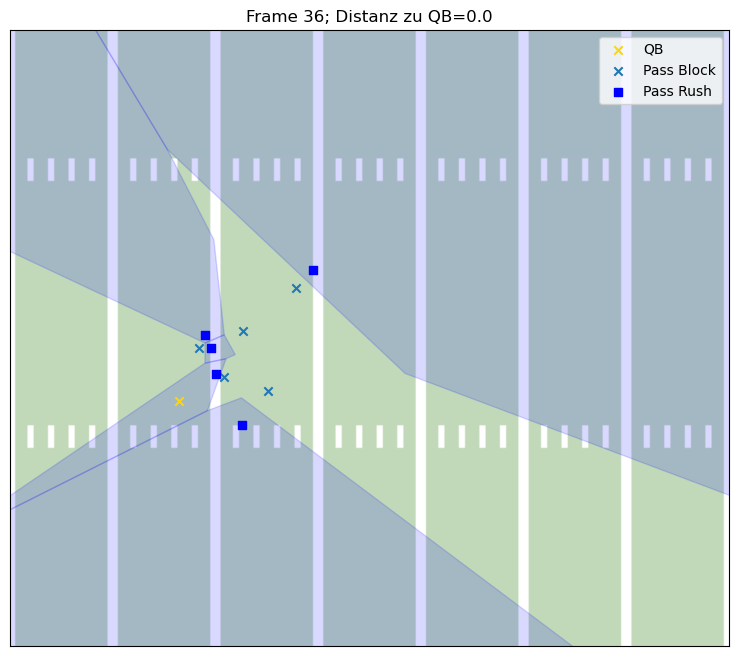

In [14]:
gameId = 2021090900
playId = 97

pdf = week_wscout[
    (week_wscout.gameId == gameId)
    & (week_wscout.playId == playId)
    & (week_wscout.pff_role.isin(["Pass", "Pass Rush", "Pass Block"]))
]

radii = []
pdists = []
for frameId in range(pdf.frameId.min(), pdf.frameId.max()):
    fdf = pdf[pdf.frameId == frameId]
    points = np.stack(
        [
            fdf[fdf.pff_role.isin(["Pass Block", "Pass Rush"])].x.to_numpy(),
            fdf[fdf.pff_role.isin(["Pass Block", "Pass Rush"])].y.to_numpy(),
        ],
        axis=-1,
    )

    # add dummy points for coloring
    points = np.append(
        points, [[999, 999], [-999, 999], [999, -999], [-999, -999]], axis=0
    )
    vor = Voronoi(points)
    # include dummy booleans for array shape to work
    def_line_regions = (
        fdf[fdf.pff_role.isin(["Pass Block", "Pass Rush"])].pff_role == "Pass Rush"
    ).to_numpy()
    regions = vor.point_region[np.concatenate([def_line_regions, [False] * 4])]

    def_pts = [[vor.vertices[vert] for vert in vor.regions[reg]] for reg in regions]
    def_pts = np.concatenate([np.stack(dpts, axis=0) for dpts in def_pts])

    def_polys = []
    for reg in regions:
        if len(vor.regions[reg]) > 2:
            def_polys.append(Polygon([vor.vertices[vert] for vert in vor.regions[reg]]))

    qb_coords = np.stack(
        [
            fdf[fdf.pff_role == "Pass"].x.to_numpy(),
            np.clip(fdf[fdf.pff_role == "Pass"].y.to_numpy(), 18, 35),
        ]
    ).T

    radius = distance.cdist(qb_coords, def_pts).min()
    qb_danger = def_line_regions[distance.cdist(qb_coords, points).argmin()]

    qb_pt = Point(qb_coords)
    polydist = min([poly.distance(qb_pt) for poly in def_polys])

    pdists.append(polydist)
    if qb_danger:
        radii.append(0.0)
    else:
        radii.append(radius)

    circle1 = plt.Circle(qb_coords[0] * 10, polydist * 10, color="r", alpha=0.33)

    if frameId % 9 == 0:
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.imshow(create_nfl_field(), alpha=0.3)
        # voronoi_plot_2d(vor, ax=ax)

        for reg in regions:
            ax.fill(
                [vor.vertices[vert][0] * 10 for vert in vor.regions[reg] if vert > -1],
                [vor.vertices[vert][1] * 10 for vert in vor.regions[reg] if vert > -1],
                alpha=0.15,
                color="blue",
            )

        ax.scatter(
            fdf[fdf.pff_role == "Pass"].x.to_numpy() * 10,
            fdf[fdf.pff_role == "Pass"].y.to_numpy() * 10,
            marker="x",
            label="QB",
            color="gold",
        )
        ax.scatter(
            fdf[fdf.pff_role == "Pass Block"].x.to_numpy() * 10,
            fdf[fdf.pff_role == "Pass Block"].y.to_numpy() * 10,
            marker="x",
            label="Pass Block",
        )
        ax.scatter(
            fdf[fdf.pff_role == "Pass Rush"].x.to_numpy() * 10,
            fdf[fdf.pff_role == "Pass Rush"].y.to_numpy() * 10,
            color="b",
            marker="s",
            label="Pass Rush",
        )
        ax.add_patch(circle1)
        plt.title(
            # f" frame {frameId}; radius: {radius:.4} yards; QB in danger: {qb_danger or radius<1.0}, polydist={polydist}"
            f"Frame {frameId}; Distanz zu QB={polydist}"
        )
        plt.xlim(250, 600)
        plt.ylim(100, 400)
        plt.xticks([])
        plt.yticks([])

        plt.legend()
        plt.show()

#### As we can see in the pictures, the dynamic of a collapsing pocket are represented in the Voronoi region. While Voronoi diagrams do not consider player speed or orientation, in this case this is a acceptable simplification as the players are not usually moving independently of each other but rather blockers try to get actively in the way of rushers leading to a dynamic where the main question is: can the blocker stay between the QB and the rusher. The Voronoi diagram maps this as "between" means closer -> Blocker is between iff the QB is in the blockers voronoi region rather than the rushers. 
#### If we check the history of the pocket size over the course of the play in the next plot, there is also an opportunity for more analysis in the temporal dynamics. 

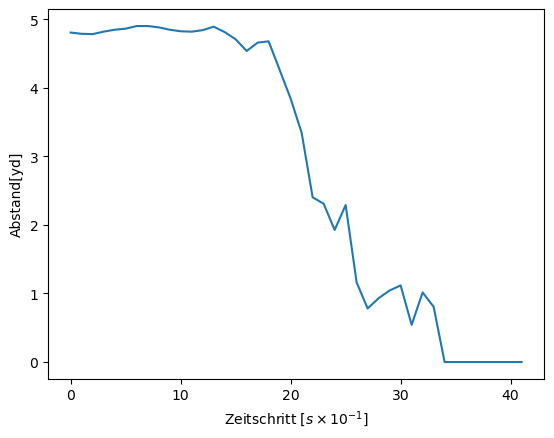

In [15]:
plt.plot(radii)
plt.xlabel(r"Zeitschritt [$s \times 10^{-1}$]")
plt.ylabel("Abstand[yd]")
plt.show()

In [16]:
if True:
    qb_spaces = pd.read_parquet("nfl-big-data-bowl-2023/qb_spaces_pre_noclip.parquet")
else:
    qb_spaces = (
        week_wscout[week_wscout.is_snapped == 1]
        .groupby(["gameId", "playId", "frameId"])
        .progress_apply(calc_qb_space)
        .reset_index()
    )
    qb_spaces["qb_radius"] = qb_spaces[0].progress_apply(lambda x: x["qb_radius"])
    qb_spaces["qb_danger"] = qb_spaces[0].progress_apply(lambda x: x["qb_danger"])
    qb_spaces["polydist"] = qb_spaces[0].progress_apply(lambda x: x["polydist"])
    qb_spaces = qb_spaces.drop(columns=0)
    qb_spaces.to_parquet("nfl-big-data-bowl-2023/qb_spaces_pre_noclip.parquet")

In [17]:
pass_abs_frames = (
    week_wscout[
        (week_wscout.event == "pass_forward")
        | ((week_wscout.event == "autoevent_passforward"))
    ]
    .drop_duplicates(["gameId", "playId"])[["gameId", "playId", "frameId"]]
    .rename(columns={"frameId": "pass_absolute_frame"})
)

In [18]:
poly_times = (
    qb_spaces.groupby(["gameId", "playId"])
    .apply(poly_frame)
    .reset_index()
    .rename(columns={0: "poly_frame"})
)

C:\Users\mschilling\AppData\Local\Temp\ipykernel_21088\550963575.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(poly_frame)


In [19]:
min_frames = (
    qb_spaces.groupby(["gameId", "playId"])
    .apply(min_frame)
    .reset_index()
    .rename(columns={0: "min_frame"})
)

C:\Users\mschilling\AppData\Local\Temp\ipykernel_21088\3324145867.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(min_frame)


In [20]:
pass_frames = (
    week_wscout.groupby(["gameId", "playId"])
    .apply(pass_frame)
    .reset_index()
    .rename(columns={0: "pass_frame"})
)

C:\Users\mschilling\AppData\Local\Temp\ipykernel_21088\652141453.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(pass_frame)


In [21]:
surv_time = (
    qb_spaces.groupby(["gameId", "playId"])
    .progress_apply(surv_frame)
    .reset_index()
    .rename(columns={0: "surv_frame"})
)

  0%|          | 0/8557 [00:00<?, ?it/s]

In [22]:
pwin = (
    qb_spaces.groupby(["gameId", "playId"])
    .progress_apply(pblockwin)
    .reset_index()
    .rename(columns={0: "p_blockwin"})
)

  0%|          | 0/8557 [00:00<?, ?it/s]

In [23]:
mean_polydists = (
    qb_spaces.groupby(["gameId", "playId"])
    .polydist.mean()
    .reset_index()
    .rename(columns={"polydist": "mean_polydists"})
)

In [24]:
plays_with_collapse = pd.merge(
    mean_polydists,
    plays[
        (plays.defendersInBox.between(4, 8))  ## pff true pass set
        & (plays.down < 4)
        & ~plays.offenseFormation.isin(["JUMBO", "WILDCAT"])
        & ~plays.dropBackType.isin(["DESIGNED_RUN", "UNKNOWN"])
    ][
        [
            "gameId",
            "playId",
            "playDescription",
            "pff_playAction",
            "passResult",
            "prePenaltyPlayResult",
            "defendersInBox",
            "personnelO",
            "personnelD",
            "dropBackType",
            "pff_passCoverage",
            "pff_passCoverageType",
            "offenseFormation",
            "yardsToGo",
            "down",
            "possessionTeam",
            "defensiveTeam",
            "ep",
            "epa",
            "qb_epa",
            "touchdown",
            "air_yards",
        ]
    ],
    how="inner",
    on=["gameId", "playId"],
)

In [25]:
plays_with_collapse["complete"] = plays_with_collapse.passResult == "C"
plays_with_collapse["incomplete"] = plays_with_collapse.passResult == "I"
plays_with_collapse["sack"] = plays_with_collapse.passResult == "S"

plays_with_collapse = plays_with_collapse.merge(
    pass_abs_frames, how="left", on=["gameId", "playId"]
)

plays_with_collapse = plays_with_collapse.merge(
    min_frames, how="left", on=["gameId", "playId"]
)

plays_with_collapse = plays_with_collapse.merge(
    poly_times, how="left", on=["gameId", "playId"]
)

plays_with_collapse = plays_with_collapse.merge(
    surv_time, how="left", on=["gameId", "playId"]
)

plays_with_collapse =  plays_with_collapse.merge(
    pass_frames, how="left", on=["gameId", "playId"]
)

plays_with_collapse = pd.merge(
    plays_with_collapse,
    qb_spaces[["gameId", "playId", "frameId", "polydist", "qb_radius"]],
    left_on=["gameId", "playId", "pass_absolute_frame"],
    right_on=["gameId", "playId", "frameId"],
    how="left",
)

plays_with_collapse = plays_with_collapse.merge(pwin, on=["gameId", "playId"])

In [26]:
max_frames = (
    qb_spaces.groupby(["gameId", "playId"])
    .frameId.max()
    .reset_index()
    .rename(columns={"frameId": "max_frame"})
)
plays_with_collapse = plays_with_collapse.merge(
    max_frames, on=["gameId", "playId"], how="left"
)


In [27]:
plays_with_collapse["survived"] = plays_with_collapse.poly_frame == -1 ## it survieved iff no collapse frame
plays_with_collapse["pass_thrown"] = plays_with_collapse.pass_frame > 0
plays_with_collapse["pocket_end_event"] = (1-plays_with_collapse["survived"]) | plays_with_collapse["pass_frame"].le(plays_with_collapse["surv_frame"])
plays_with_collapse["pocket_end"] = plays_with_collapse[["surv_frame", "pass_frame"]].min(axis=1)

plays_with_collapse["pocket_vol"] = (
    plays_with_collapse["mean_polydists"] * plays_with_collapse["surv_frame"]
)

In [28]:
plays_with_collapse["down1"] = plays_with_collapse.down==1
plays_with_collapse["down2"] = plays_with_collapse.down==2
plays_with_collapse["down3"] = plays_with_collapse.down==3
down_cols = ["down2", "down3"] 
plays_with_collapse["zone"] = plays_with_collapse.pff_passCoverageType == "Zone"
plays_with_collapse["man"] = plays_with_collapse.pff_passCoverageType == "Man"
mz_cols = ["zone", "man"]
plays_with_collapse["Cover-3"] = plays_with_collapse.pff_passCoverage == "Cover-3"
plays_with_collapse["Cover-1"] = plays_with_collapse.pff_passCoverage == "Cover-1"
plays_with_collapse["Cover-2"] = plays_with_collapse.pff_passCoverage == "Cover-2"
plays_with_collapse["Quarters"] = plays_with_collapse.pff_passCoverage == "Quarters"
plays_with_collapse["Cover-6"] = plays_with_collapse.pff_passCoverage == "Cover-6"
plays_with_collapse["RedZone"] = plays_with_collapse.pff_passCoverage == "Red Zone"
plays_with_collapse["Cover-0"] = plays_with_collapse.pff_passCoverage == "Cover-0"
plays_with_collapse["2-Man"] = plays_with_collapse.pff_passCoverage == "2-Man"
def_cols = ["Cover-3", "Cover-1", "Cover-2", "Cover-6", "Quarters", "Cover-0", "2-Man", "RedZone"]

In [29]:
plays_with_collapse["shotgun"] = plays_with_collapse.offenseFormation == "SHOTGUN"
plays_with_collapse["empty"] = plays_with_collapse.offenseFormation == "EMPTY"
plays_with_collapse["singleback"] = plays_with_collapse.offenseFormation == "SINGLEBACK"
plays_with_collapse["iform"] = plays_with_collapse.offenseFormation == "I_FORM"
off_cols = ["shotgun","empty","singleback","iform",]

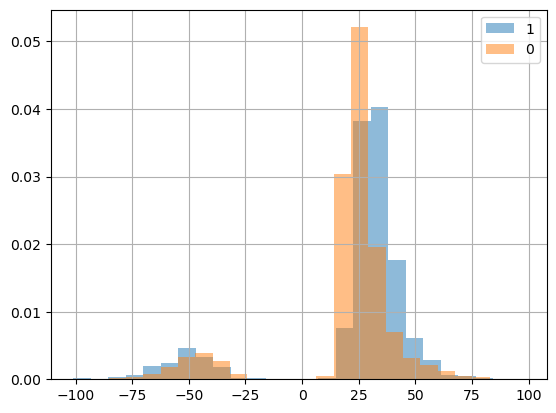

In [30]:
plays_with_collapse[plays_with_collapse.pff_playAction==1].pass_frame.hist(bins=25, alpha=.5, density=True, label="1")
plays_with_collapse[plays_with_collapse.pff_playAction==0].pass_frame.hist(bins=25, alpha=.5, density=True, label="0")
plt.legend()
plt.show()

In [31]:
plays_with_collapse["pass_frame"] = plays_with_collapse.pass_frame.abs()
plays_with_collapse["comp_air_yards"] = plays_with_collapse.air_yards * plays_with_collapse.complete
plays_with_collapse["safe_pass"] = (
    plays_with_collapse.surv_frame > plays_with_collapse.pass_frame
)


# effect of pocket survival on play outcome

#### quick overview of correlations between pocket survival_frame and some play outcome measures

In [32]:
plays_with_collapse.groupby("surv_frame").agg(
    sack=("sack", "mean"), epa=("epa", "mean"), comp_percentage=("complete", "mean"), ytg=("yardsToGo", "mean")
).reset_index().corr()

surv_frame      sack       epa  comp_percentage       ytg
surv_frame         1.000000 -0.465793  0.034267        -0.210061  0.188291
sack              -0.465793  1.000000 -0.039987         0.069100 -0.033642
epa                0.034267 -0.039987  1.000000         0.602567  0.018118
comp_percentage   -0.210061  0.069100  0.602567         1.000000  0.151237
ytg                0.188291 -0.033642  0.018118         0.151237  1.000000

#### is a "safe" pocket beneficial?

In [33]:
# aggregating plays by survival frame (independent of pocket safety)
sagg = (
    plays_with_collapse.groupby("surv_frame")
    .agg(
        {
            "sack": ["mean"],
            "complete": ["mean"],
            "epa": ["mean", lambda df: df.quantile(0.05), lambda df: df.quantile(0.95)],
            "prePenaltyPlayResult": ["mean", lambda df: df.quantile(0.05), lambda df: df.quantile(0.95)],
            "air_yards":["mean", lambda df: df.quantile(0.05), lambda df: df.quantile(0.95)],
            "comp_air_yards":["mean", lambda df: df.quantile(0.05), lambda df: df.quantile(0.95)],
        }
    )
    .reset_index()
)

# aggregating plays by survival frame (only passes from a safe pocket)
pass_surv_frame = (
    plays_with_collapse[(plays_with_collapse.surv_frame > plays_with_collapse.pass_frame) & plays_with_collapse.pass_thrown]
    .groupby("surv_frame")
    .agg(
        {
            "sack": ["mean"],
            "complete": ["mean"],
            "epa": ["mean", lambda df: df.quantile(0.05), lambda df: df.quantile(0.95)],
            "prePenaltyPlayResult": ["mean", lambda df: df.quantile(0.05), lambda df: df.quantile(0.95)],
            "air_yards":["mean", lambda df: df.quantile(0.05), lambda df: df.quantile(0.95)],
            "comp_air_yards":["mean", lambda df: df.quantile(0.05), lambda df: df.quantile(0.95)],
        }
    )
    .reset_index()
)

# aggregating plays by survival frame (excluding passes from a safe pocket)
pass_pressure_frame = (
    plays_with_collapse[
        ~((plays_with_collapse.surv_frame > plays_with_collapse.pass_frame) & (plays_with_collapse.pass_thrown))
    ]
    .groupby("surv_frame")
    .agg(
        {
            "sack": ["mean"],
            "complete": ["mean"],
            "epa": ["mean", lambda df: df.quantile(0.05), lambda df: df.quantile(0.95)],
            "prePenaltyPlayResult": ["mean", lambda df: df.quantile(0.05), lambda df: df.quantile(0.95)],
            "air_yards":["mean", lambda df: df.quantile(0.05), lambda df: df.quantile(0.95)],
            "comp_air_yards":["mean", lambda df: df.quantile(0.05), lambda df: df.quantile(0.95)],
        }
    )
    .reset_index()
)

#### we exclude the shortest and longest 5 percent of plays, since there is not enough data per frame in those situations

In [34]:
p05 = plays_with_collapse["surv_frame"].quantile(0.05)
p95 = plays_with_collapse["surv_frame"].quantile(0.95)
print(f"considered play durations: {p05/10:.1f}s - {p95/10:.1f}s")

considered play durations: 1.7s - 4.1s


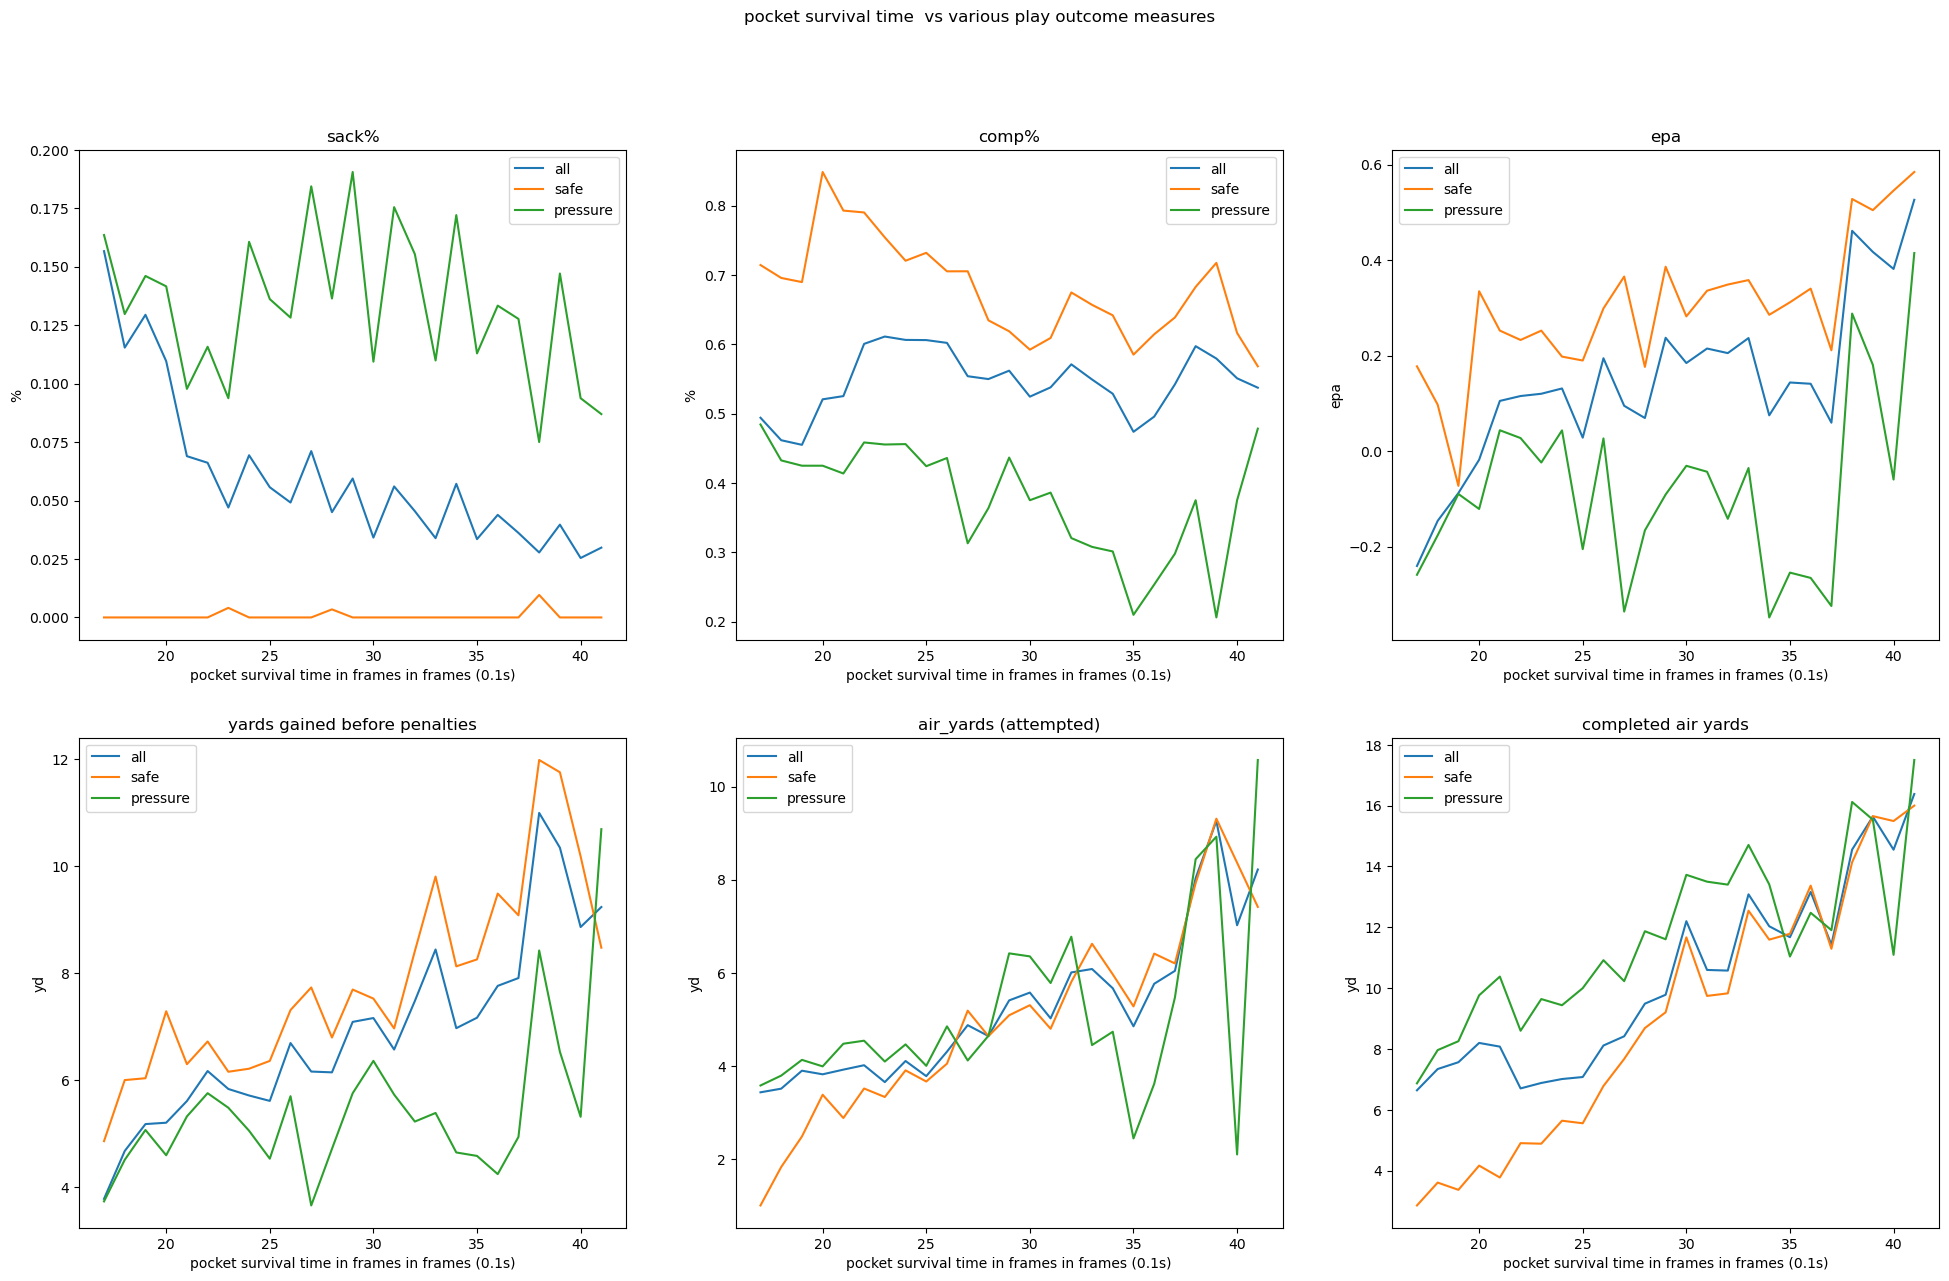

In [35]:
fig, ax = plt.subplots(2, 3, figsize=(24, 14))
sagg[sagg.surv_frame.between(p05, p95)].plot(
    x="surv_frame", y=("sack", "mean"), ax=ax[0,0], label="all"
)
pass_surv_frame[pass_surv_frame.surv_frame.between(p05, p95)].plot(
    x="surv_frame", y=("sack", "mean"), ax=ax[0,0], label="safe"
)
pass_pressure_frame[pass_pressure_frame.surv_frame.between(p05, p95)].plot(
    x="surv_frame", y=("sack", "mean"), ax=ax[0,0], label="pressure"
)
sagg[sagg.surv_frame.between(p05, p95)].plot(
    x="surv_frame", y=("complete", "mean"), ax=ax[0,1], label="all"
)
pass_surv_frame[pass_surv_frame.surv_frame.between(p05, p95)].plot(
    x="surv_frame", y=("complete", "mean"), ax=ax[0,1], label="safe"
)
pass_pressure_frame[pass_pressure_frame.surv_frame.between(p05, p95)].plot(
    x="surv_frame", y=("complete", "mean"), ax=ax[0,1], label="pressure"
)
sagg[sagg.surv_frame.between(p05, p95)].plot(
    x="surv_frame", y=("epa", "mean"), ax=ax[0,2], label="all"
)
pass_surv_frame[pass_surv_frame.surv_frame.between(p05, p95)].plot(
    x="surv_frame", y=("epa", "mean"), ax=ax[0,2], label="safe"
)
pass_pressure_frame[pass_pressure_frame.surv_frame.between(p05, p95)].plot(
    x="surv_frame", y=("epa", "mean"), ax=ax[0,2], label="pressure"
)


sagg[sagg.surv_frame.between(p05, p95)].plot(
    x="surv_frame", y=("prePenaltyPlayResult", "mean"), ax=ax[1,0], label="all"
)
pass_surv_frame[pass_surv_frame.surv_frame.between(p05, p95)].plot(
    x="surv_frame", y=("prePenaltyPlayResult", "mean"), ax=ax[1,0], label="safe"
)
pass_pressure_frame[pass_pressure_frame.surv_frame.between(p05, p95)].plot(
    x="surv_frame", y=("prePenaltyPlayResult", "mean"), ax=ax[1,0], label="pressure"
)
sagg[sagg.surv_frame.between(p05, p95)].plot(
    x="surv_frame", y=("comp_air_yards", "mean"), ax=ax[1,1], label="all"
)
pass_surv_frame[pass_surv_frame.surv_frame.between(p05, p95)].plot(
    x="surv_frame", y=("comp_air_yards", "mean"), ax=ax[1,1], label="safe"
)
pass_pressure_frame[pass_pressure_frame.surv_frame.between(p05, p95)].plot(
    x="surv_frame", y=("comp_air_yards", "mean"), ax=ax[1,1], label="pressure"
)
    
sagg[sagg.surv_frame.between(p05, p95)].plot(
    x="surv_frame", y=("air_yards", "mean"), ax=ax[1,2], label="all"
)
pass_surv_frame[pass_surv_frame.surv_frame.between(p05, p95)].plot(
    x="surv_frame", y=("air_yards", "mean"), ax=ax[1,2], label="safe"
)
pass_pressure_frame[pass_pressure_frame.surv_frame.between(p05, p95)].plot(
    x="surv_frame", y=("air_yards", "mean"), ax=ax[1,2], label="pressure"
)

plt.suptitle("pocket survival time  vs various play outcome measures")

ax[0,0].set_title("sack%")
ax[0,0].set_ylabel("%")
ax[0,0].set_xlabel("pocket survival time in frames in frames (0.1s)")
ax[0,1].set_title("comp%")
ax[0,1].set_ylabel("%")
ax[0,1].set_xlabel("pocket survival time in frames in frames (0.1s)")
ax[0,2].set_title("epa")
ax[0,2].set_ylabel("epa")
ax[0,2].set_xlabel("pocket survival time in frames in frames (0.1s)")
ax[1,0].set_title("yards gained before penalties")
ax[1,0].set_ylabel("yd")
ax[1,0].set_xlabel("pocket survival time in frames in frames (0.1s)")
ax[1,1].set_title("air_yards (attempted)")
ax[1,1].set_ylabel("yd")
ax[1,1].set_xlabel("pocket survival time in frames in frames (0.1s)")
ax[1,2].set_title("completed air yards")
ax[1,2].set_ylabel("yd")
ax[1,2].set_xlabel("pocket survival time in frames in frames (0.1s)")
plt.legend(loc="upper left")
plt.show()

## we can graphically see, that passes from a safe pocket seems to be better than froma collapsed on. But are these differences significant?

In [36]:

sdf = plays_with_collapse[
    plays_with_collapse.surv_frame > plays_with_collapse.pass_frame
]
pressdf = plays_with_collapse[
    plays_with_collapse.surv_frame <= plays_with_collapse.pass_frame
]
nopassdf = plays_with_collapse[~plays_with_collapse.pass_thrown]

In [37]:
print(stats.mannwhitneyu(sdf.epa, pressdf.epa).pvalue)
print(stats.mannwhitneyu(sdf.sack, pressdf.sack).pvalue)
print(stats.mannwhitneyu(sdf.complete, pressdf.complete).pvalue)
print(stats.mannwhitneyu(sdf.prePenaltyPlayResult, pressdf.prePenaltyPlayResult).pvalue)

7.055409085341786e-52
1.4457465893786036e-135
5.629256227573882e-138
2.1606620812309775e-70


## Yes, for completion percentage, sack rate, epa and prePenaltyPlayResult, the differenes are significant (and better for safe pockets)

### effect of mean pocket size on play outcome

#### we use two measures of pocket size: _mean pocket size_, a time independent version, and _pocket volume ~ mean pocket size * safe pocket duration_ which combines the time independent measure with the survival duration to take both how long and how big the pocket was into account

In [38]:
plays_with_collapse.loc[
    (plays_with_collapse.surv_frame.between(17, 41)),
    [
        "surv_frame",
        "mean_polydists",
        "pocket_vol",
        "polydist",
        "sack",
        "complete",
        "epa",
        "prePenaltyPlayResult",
        "yardsToGo",
    ],
].corr()

surv_frame  mean_polydists  pocket_vol  polydist  \
surv_frame              1.000000        0.266277    0.695491  0.140003   
mean_polydists          0.266277        1.000000    0.859888  0.713991   
pocket_vol              0.695491        0.859888    1.000000  0.587924   
polydist                0.140003        0.713991    0.587924  1.000000   
sack                   -0.087519       -0.306681   -0.265051 -0.052318   
complete                0.000375        0.243268    0.173579  0.158853   
epa                     0.060958        0.129950    0.130187  0.056355   
prePenaltyPlayResult    0.115937        0.137611    0.166484  0.037459   
yardsToGo               0.064697        0.016171    0.052301  0.003083   

                          sack  complete       epa  prePenaltyPlayResult  \
surv_frame           -0.087519  0.000375  0.060958              0.115937   
mean_polydists       -0.306681  0.243268  0.129950              0.137611   
pocket_vol           -0.265051  0.173579  0.130187              0.166484   
polydist             -0.052318  0.158853  0.056355              0.037459   
sack                  1.000000 -0.282243 -0.290899             -0.342466   
complete             -0.282243  1.000000  0.542989              0.602272   
epa                  -0.290899  0.542989  1.000000              0.713128   
prePenaltyPlayResult -0.342466  0.602272  0.713128              1.000000   
yardsToGo            -0.001767  0.028768 -0.019208              0.029141   

                      yardsToGo  
surv_frame             0.064697  
mean_polydists         0.016171  
pocket_vol             0.052301  
polydist               0.003083  
sack                  -0.001767  
complete               0.028768  
epa                   -0.019208  
prePenaltyPlayResult   0.029141  
yardsToGo              1.000000

#### looking at pocket volume and pocket size, wee see clear patterns. First of all, there seems to be only very rarely a volume over 200 pocket vol or 5 mean pocket size. Furthermore we see that the overall features are split into larger and safe versions, smaller and pressure version and especially no pass situations seem to occur on lower volume, smaller pockets. no pass and pressure pass are much more similar between each other than towards safe passes 

In [39]:
sdf.columns

Index(['gameId', 'playId', 'mean_polydists', 'playDescription',
       'pff_playAction', 'passResult', 'prePenaltyPlayResult',
       'defendersInBox', 'personnelO', 'personnelD', 'dropBackType',
       'pff_passCoverage', 'pff_passCoverageType', 'offenseFormation',
       'yardsToGo', 'down', 'possessionTeam', 'defensiveTeam', 'ep', 'epa',
       'qb_epa', 'touchdown', 'air_yards', 'complete', 'incomplete', 'sack',
       'pass_absolute_frame', 'min_frame', 'poly_frame', 'surv_frame',
       'pass_frame', 'frameId', 'polydist', 'qb_radius', 'p_blockwin',
       'max_frame', 'survived', 'pass_thrown', 'pocket_end_event',
       'pocket_end', 'pocket_vol', 'down1', 'down2', 'down3', 'zone', 'man',
       'Cover-3', 'Cover-1', 'Cover-2', 'Quarters', 'Cover-6', 'RedZone',
       'Cover-0', '2-Man', 'shotgun', 'empty', 'singleback', 'iform',
       'comp_air_yards', 'safe_pass'],
      dtype='object')

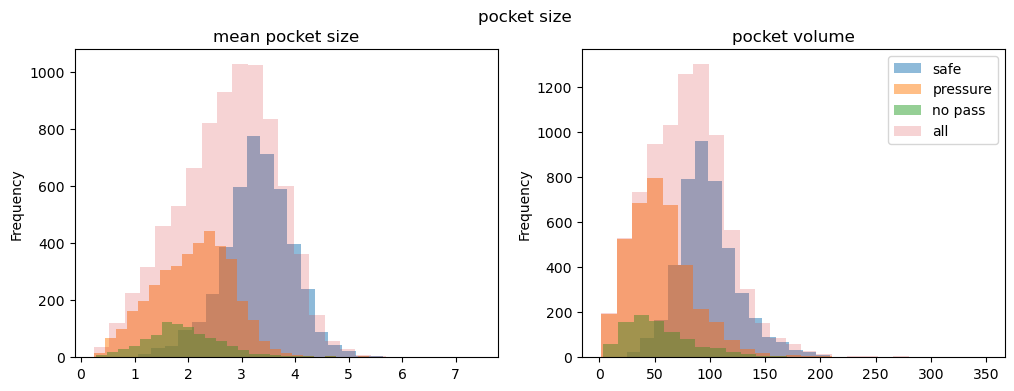

In [40]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
sdf.mean_polydists.plot.hist(bins=25, alpha=0.5, label="safe", ax=ax[0])
pressdf.mean_polydists.plot.hist(bins=25, alpha=0.5, label="pressure", ax=ax[0])
nopassdf.mean_polydists.plot.hist(bins=25, alpha=0.5, label="no pass", ax=ax[0])
plays_with_collapse.mean_polydists.plot.hist(bins=25, alpha=0.2, label="all", ax=ax[0])
ax[0].set_title("mean pocket size")

sdf.pocket_vol.plot.hist(bins=25, alpha=0.5, label="safe", ax=ax[1])
pressdf.pocket_vol.plot.hist(bins=25, alpha=0.5, label="pressure", ax=ax[1])
nopassdf.pocket_vol.plot.hist(bins=25, alpha=0.5, label="no pass", ax=ax[1])
plays_with_collapse.pocket_vol.plot.hist(bins=25, alpha=0.2, label="all", ax=ax[1])
ax[1].set_title("pocket volume")

plt.suptitle("pocket size")
plt.legend()
plt.show()

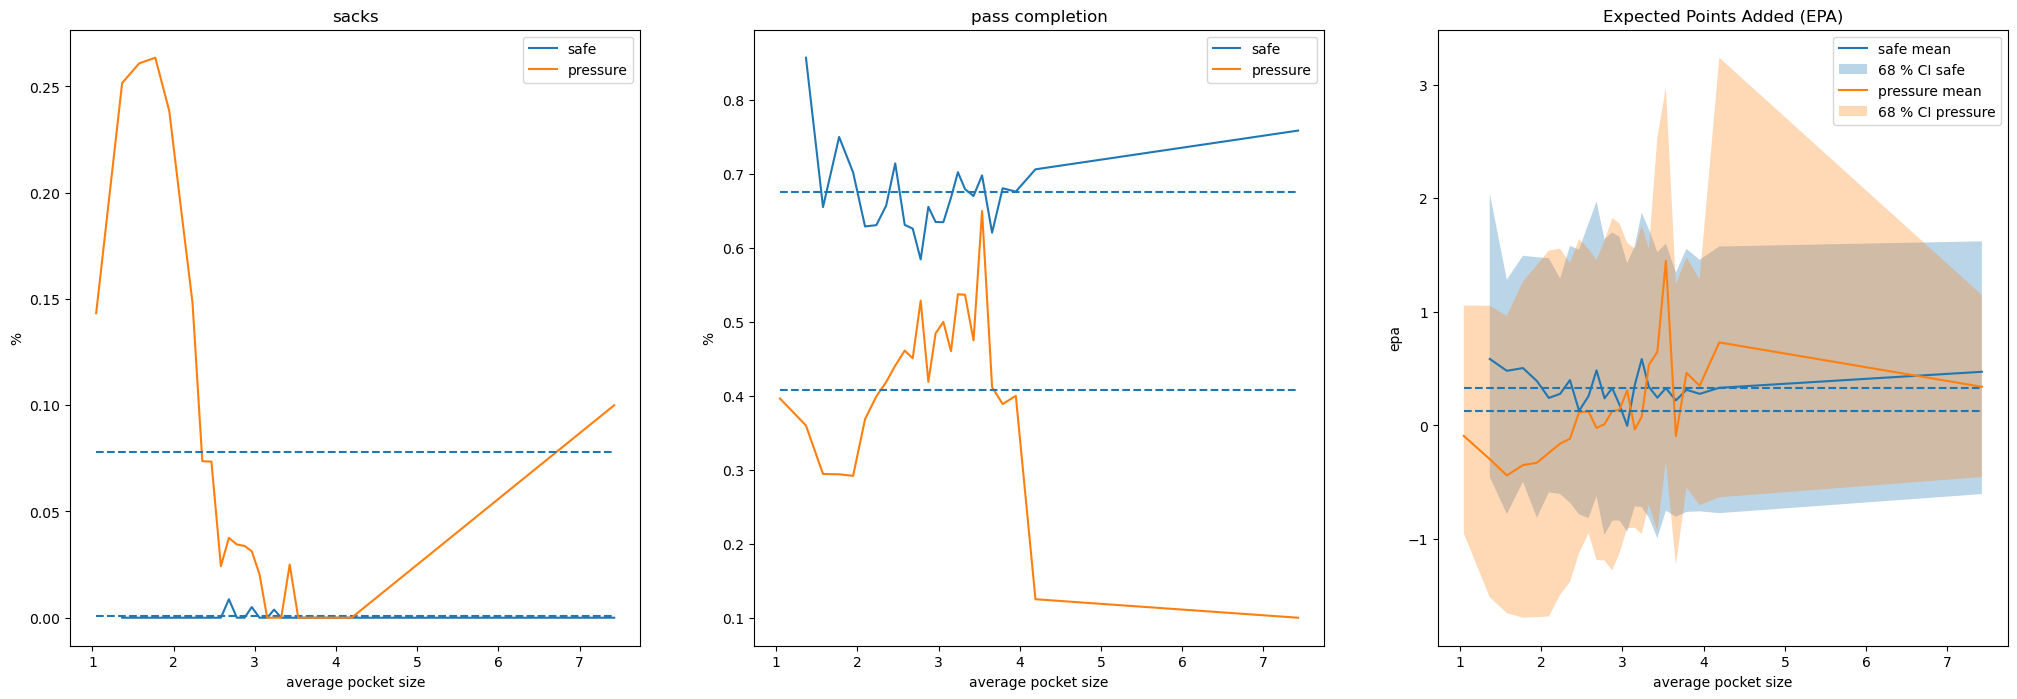

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(25, 8))

sdf = plays_with_collapse[plays_with_collapse.safe_pass]
pressdf = plays_with_collapse[~plays_with_collapse.safe_pass]
cats, bins = pd.qcut(plays_with_collapse.mean_polydists, 25, retbins=True)
for idf, lbl in zip([sdf, pressdf], ["safe", "pressure"]):
    cats, bins = pd.cut(idf.mean_polydists, bins, retbins=True)
    mpd = plays_with_collapse.groupby(cats, observed=False)[
        ["sack", "complete", "epa"]
    ].mean()
    mpd05 = plays_with_collapse.groupby(cats, observed=False)[["epa"]].quantile(0.16)
    mpd95 = plays_with_collapse.groupby(cats, observed=False)[["epa"]].quantile(0.84)

    ax[0].plot(bins[1:], mpd.sack, label=lbl)
    ax[0].hlines([np.mean(mpd.sack)], xmin=bins[1], xmax=bins[-1], linestyle="dashed")
    ax[1].plot(bins[1:], mpd.complete, label=lbl)
    ax[1].hlines(
        [np.mean(mpd.complete)], xmin=bins[1], xmax=bins[-1], linestyle="dashed"
    )
    ax[2].plot(bins[1:], mpd.epa, label=f"{lbl} mean")
    ax[2].hlines([np.mean(mpd.epa)], xmin=bins[1], xmax=bins[-1], linestyle="dashed")
    ax[2].fill_between(
        bins[1:], mpd05.epa, mpd95.epa, label=f"68 % CI {lbl}", alpha=0.3
    )

ax[0].set_title("sacks")
ax[0].set_ylabel("%")
ax[0].set_xlabel("average pocket size")
ax[1].set_title("pass completion")
ax[1].set_ylabel("%")
ax[1].set_xlabel("average pocket size")
ax[2].set_ylabel("epa")
ax[2].set_xlabel("average pocket size")
ax[2].set_title("Expected Points Added (EPA)")
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()

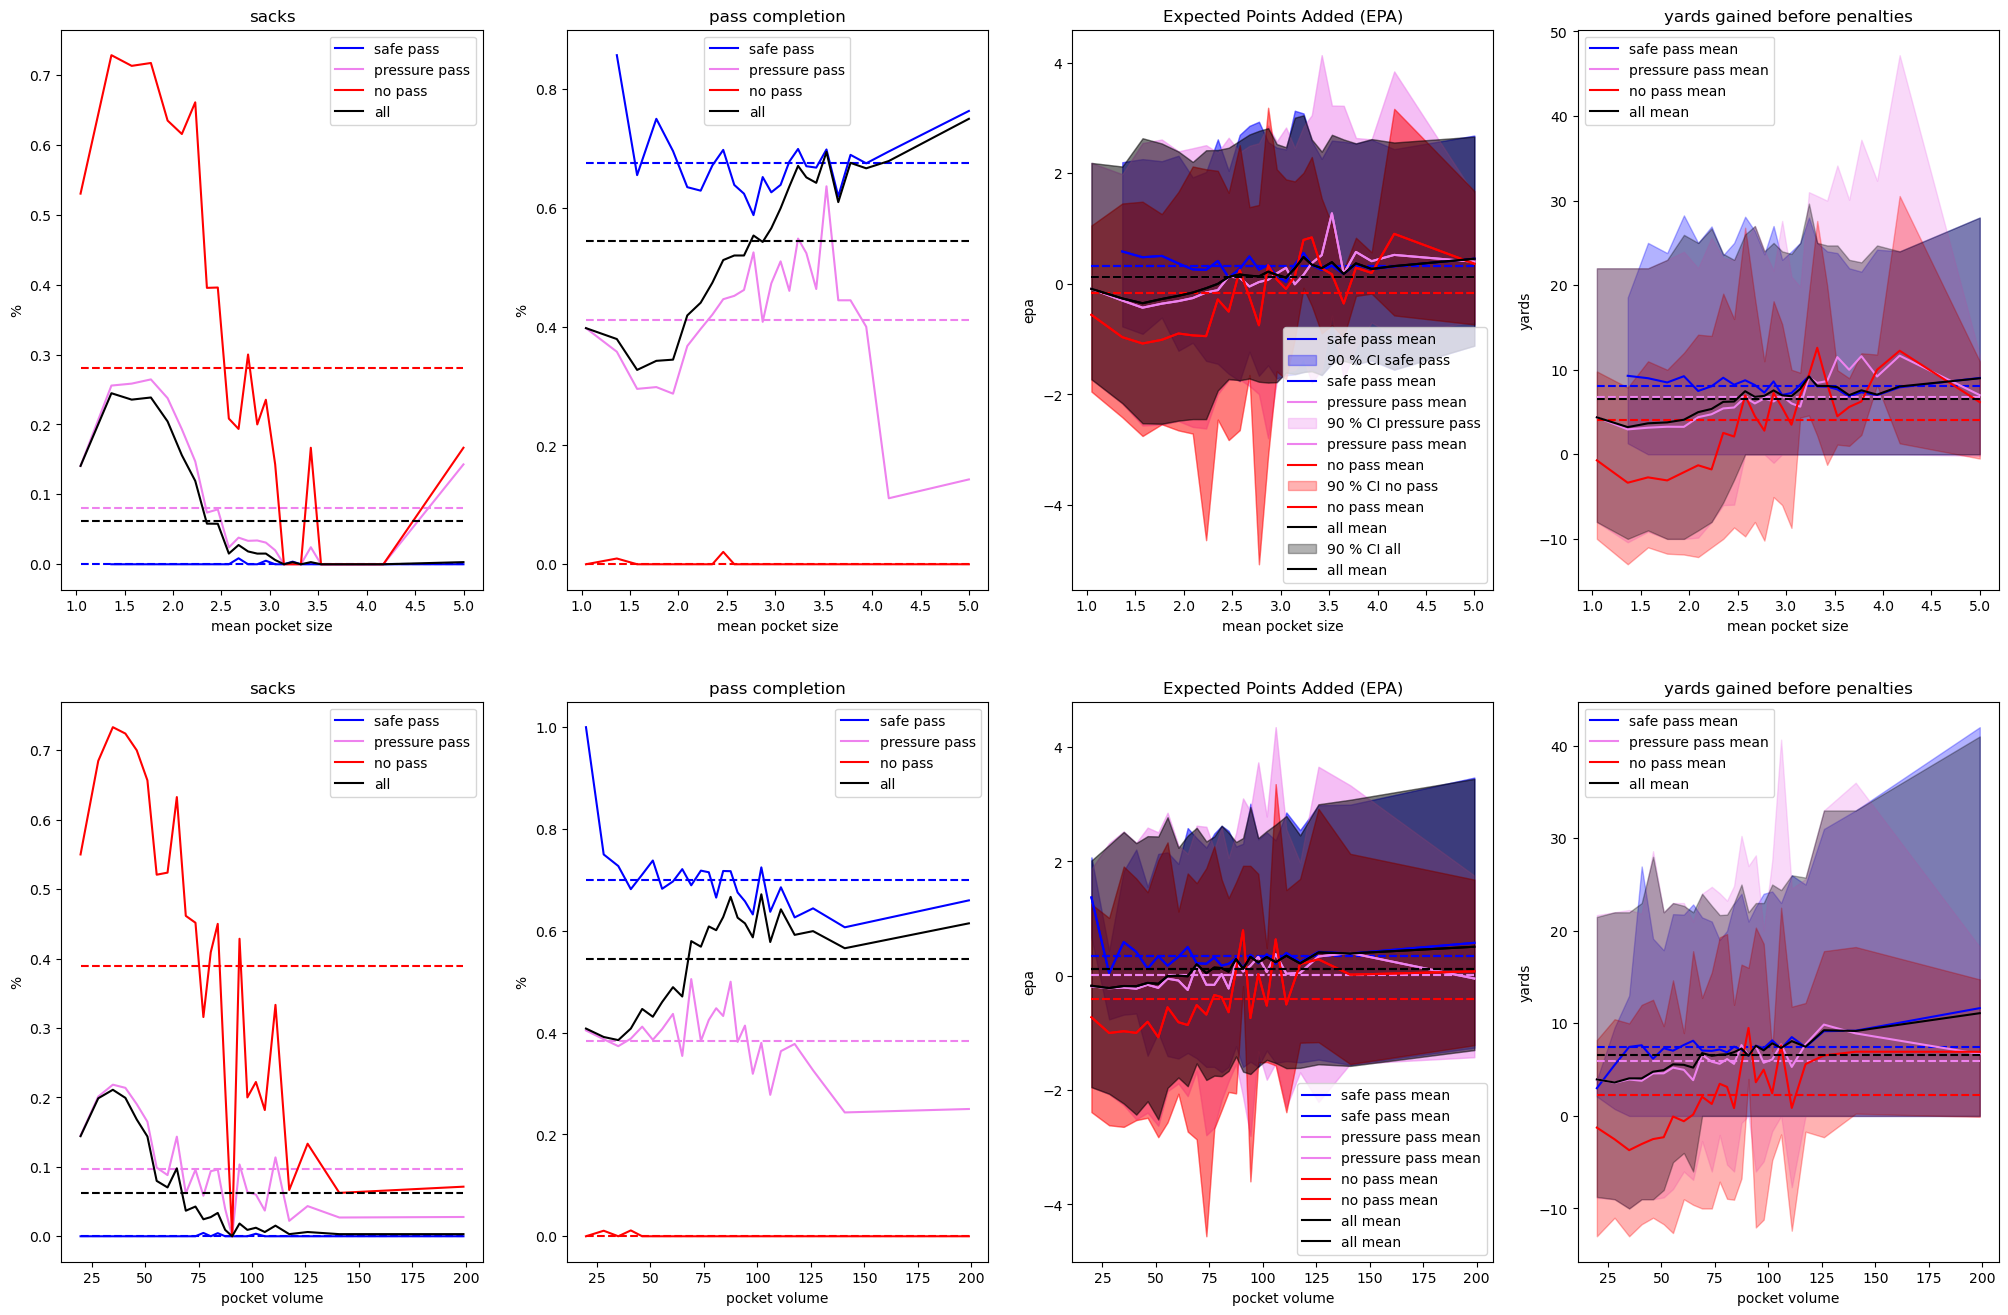

In [42]:
# based on the histogram, we set an upper threshold to 200 pocket volume
thrs = 200

#threshold for mean pocket size is set to 5
thrsd = 5

fig, ax = plt.subplots(2, 4, figsize=(25, 16))

vol_cats, vol_bins = pd.qcut(plays_with_collapse[plays_with_collapse.pocket_vol.le(thrs)].pocket_vol, 25, retbins=True)

cats, bins = pd.qcut(plays_with_collapse[plays_with_collapse.mean_polydists.le(thrsd)].mean_polydists, 25, retbins=True)

for idf, lbl, c in zip(
    [sdf, pressdf, nopassdf, plays_with_collapse],
    ["safe pass", "pressure pass", "no pass", "all"],
    ["blue", "violet", "red", "black"],
):
    # mean pocket size
    cats = pd.cut(idf[idf.mean_polydists.le(thrsd)].mean_polydists, bins, retbins=False)
    mpd = idf[idf.mean_polydists.le(thrsd)].groupby(cats, observed=False)[["sack", "complete", "epa", "prePenaltyPlayResult"]].mean()
    mpd05 = idf[idf.mean_polydists.le(thrsd)].groupby(cats, observed=False)[["epa", "prePenaltyPlayResult"]].quantile(0.05)
    mpd95 = idf[idf.mean_polydists.le(thrsd)].groupby(cats, observed=False)[["epa", "prePenaltyPlayResult"]].quantile(0.95)
    
    ax[0,0].plot(bins[1:], mpd.sack, label=lbl, color=c)
    ax[0,0].hlines(
        [np.mean(mpd.sack)],
        xmin=bins[1],
        xmax=bins[-1],
        linestyle="dashed",
        color=c,
    )

    ax[0,1].plot(bins[1:], mpd.complete, label=lbl, color=c)
    ax[0,1].hlines(
        [np.mean(mpd.complete)],
        xmin=bins[1],
        xmax=bins[-1],
        linestyle="dashed",
        color=c,
    )

    ax[0,2].plot(bins[1:], mpd.epa, label=f"{lbl} mean", color=c)
    ax[0,2].hlines(
        [np.mean(mpd.epa)],
        xmin=bins[1],
        xmax=bins[-1],
        linestyle="dashed",
        color=c,
    )
    ax[0,2].fill_between(
        bins[1:], mpd05.epa, mpd95.epa, label=f"90 % CI {lbl}", alpha=0.3, color=c
    )
    
    ax[0,2].plot(bins[1:], mpd.epa, label=f"{lbl} mean", color=c)
    ax[0,2].hlines(
        [np.mean(mpd.epa)],
        xmin=bins[1],
        xmax=bins[-1],
        linestyle="dashed",
        color=c,
    )
    ax[0,2].fill_between(
        bins[1:], mpd05.epa, mpd95.epa, alpha=0.3, color=c
    )
    
    ax[0,3].plot(bins[1:], mpd.prePenaltyPlayResult, label=f"{lbl} mean", color=c)
    ax[0,3].hlines(
        [np.mean(mpd.prePenaltyPlayResult)],
        xmin=bins[1],
        xmax=bins[-1],
        linestyle="dashed",
        color=c,
    )
    ax[0,3].fill_between(
        bins[1:], mpd05.prePenaltyPlayResult, mpd95.prePenaltyPlayResult, alpha=0.3, color=c
    )
    
    
    
    # pocket volume
    vol_cats = pd.cut(idf[idf.pocket_vol.le(thrs)].pocket_vol, vol_bins, retbins=False)
    vmpd = idf[idf.pocket_vol.le(thrs)].groupby(vol_cats, observed=True)[["sack", "complete", "epa", "prePenaltyPlayResult"]].mean()
    vmpd05 = idf[idf.pocket_vol.le(thrs)].groupby(vol_cats, observed=True)[["epa", "prePenaltyPlayResult"]].quantile(0.05)
    vmpd95 = idf[idf.pocket_vol.le(thrs)].groupby(vol_cats, observed=True)[["epa", "prePenaltyPlayResult"]].quantile(0.95)

    ax[1,0].plot(vol_bins[1:], vmpd.sack, label=lbl, color=c)
    ax[1,0].hlines(
        [np.mean(vmpd.sack)],
        xmin=vol_bins[1],
        xmax=vol_bins[-1],
        linestyle="dashed",
        color=c,
    )

    ax[1,1].plot(vol_bins[1:], vmpd.complete, label=lbl, color=c)
    ax[1,1].hlines(
        [np.mean(vmpd.complete)],
        xmin=vol_bins[1],
        xmax=vol_bins[-1],
        linestyle="dashed",
        color=c,
    )

    ax[1,2].plot(vol_bins[1:], vmpd.epa, label=f"{lbl} mean", color=c)
    ax[1,2].hlines(
        [np.mean(vmpd.epa)],
        xmin=vol_bins[1],
        xmax=vol_bins[-1],
        linestyle="dashed",
        color=c,
    )
    ax[1,2].fill_between(
        vol_bins[1:], vmpd05.epa, vmpd95.epa,  alpha=0.3, color=c
    )
    
    ax[1,2].plot(vol_bins[1:], vmpd.epa, label=f"{lbl} mean", color=c)
    ax[1,2].hlines(
        [np.mean(vmpd.epa)],
        xmin=vol_bins[1],
        xmax=vol_bins[-1],
        linestyle="dashed",
        color=c,
    )
    ax[1,2].fill_between(
        vol_bins[1:], vmpd05.epa, vmpd95.epa, alpha=0.3, color=c
    )
    
    ax[1,3].plot(vol_bins[1:], vmpd.prePenaltyPlayResult, label=f"{lbl} mean", color=c)
    ax[1,3].hlines(
        [np.mean(vmpd.prePenaltyPlayResult)],
        xmin=vol_bins[1],
        xmax=vol_bins[-1],
        linestyle="dashed",
        color=c,
    )
    ax[1,3].fill_between(
        vol_bins[1:], vmpd05.prePenaltyPlayResult, vmpd95.prePenaltyPlayResult, alpha=0.3, color=c
    )

ax[0,0].set_title("sacks")
ax[0,0].set_ylabel("%")
ax[0,0].set_xlabel("mean pocket size")
ax[0,1].set_title("pass completion")
ax[0,1].set_ylabel("%")
ax[0,1].set_xlabel("mean pocket size")
ax[0,2].set_ylabel("epa")
ax[0,2].set_xlabel("mean pocket size")
ax[0,2].set_title("Expected Points Added (EPA)")
ax[0,3].set_title("yards gained before penalties")
ax[0,3].set_xlabel("mean pocket size")
ax[0,3].set_ylabel("yards")
ax[0,0].legend()
ax[0,1].legend()
ax[0,2].legend()
ax[0,3].legend()

ax[1,0].set_title("sacks")
ax[1,0].set_ylabel("%")
ax[1,0].set_xlabel("pocket volume")
ax[1,1].set_title("pass completion")
ax[1,1].set_ylabel("%")
ax[1,1].set_xlabel("pocket volume")
ax[1,2].set_ylabel("epa")
ax[1,2].set_xlabel("pocket volume")
ax[1,2].set_title("Expected Points Added (EPA)")
ax[1,3].set_title("yards gained before penalties")
ax[1,3].set_xlabel("pocket volume")
ax[1,3].set_ylabel("yards")
ax[1,0].legend()
ax[1,1].legend()
ax[1,2].legend()
ax[1,3].legend()
plt.show()

In [43]:
# testing survival frame:

print("pvalue", stats.mannwhitneyu(sdf.epa, pressdf.epa).pvalue)
print("pvalue", stats.chi2_contingency([[sdf.complete.sum(), len(sdf) - sdf.complete.sum()],[pressdf.complete.sum(), len(pressdf)-pressdf.complete.sum()]]).pvalue)
print("pvalue", stats.chi2_contingency([[sdf.sack.sum(), len(sdf) - sdf.sack.sum()],[pressdf.sack.sum(), len(pressdf)-pressdf.sack.sum()]]).pvalue)
p_vals = np.ones(43)
p_vals1 = np.ones(43)
p_vals2 = np.ones(43)
for sf in trange(1, 43): 
    spi = sdf[sdf.surv_frame == sf]
    ppi = pressdf[pressdf.surv_frame == sf]
    _, pv = stats.mannwhitneyu(spi.epa, ppi.epa)
    if (np.array([[spi.complete.sum(), len(spi) - spi.complete.sum()],[ppi.complete.sum(), len(ppi)-ppi.complete.sum()]]) < 1).any(): 
        pc1 = 2
    else: 
        _, pc1, _, _ = stats.chi2_contingency([[spi.complete.sum(), len(spi) - spi.complete.sum()],[ppi.complete.sum(), len(ppi)-ppi.complete.sum()]])
    
    if (np.array([[spi.sack.sum(), len(spi) - spi.sack.sum()],[ppi.sack.sum(), len(ppi)-ppi.sack.sum()]]) < 1).any(): 
        pc2 = 2
    else: 
        _, pc2, _, _ = stats.chi2_contingency([[spi.sack.sum(), len(spi) - spi.sack.sum()],[ppi.sack.sum(), len(ppi)-ppi.sack.sum()]])
    if not np.isnan(pv):
        p_vals[sf] = pv
    if not np.isnan(pc1):
        p_vals1[sf] = pc1
    if not np.isnan(pc2):
        p_vals2[sf] = pc2

pvalue 7.055409085341786e-52
pvalue 9.450405867075952e-138
pvalue 4.334562698569275e-135


  0%|          | 0/42 [00:00<?, ?it/s]

C:\Users\mschilling\AppData\Local\Temp\ipykernel_21088\3644523075.py:12: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  _, pv = stats.mannwhitneyu(spi.epa, ppi.epa)


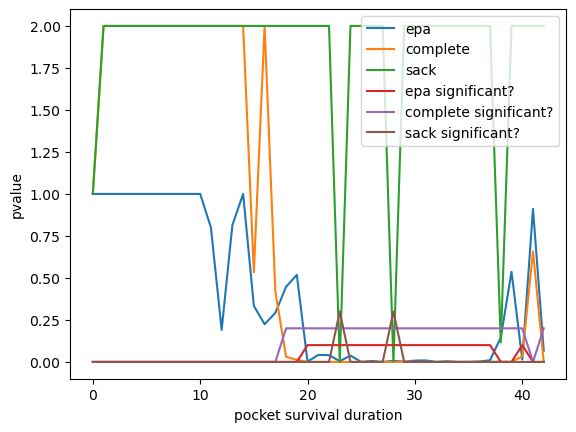

In [44]:
plt.plot(p_vals, label="epa")
plt.plot(p_vals1, label="complete")
plt.plot(p_vals2, label="sack")
plt.plot((p_vals < 0.05) * 0.1, label="epa significant?")
plt.plot((p_vals1 < 0.05) * 0.2, label="complete significant?")
plt.plot((p_vals2 < 0.05) * 0.3, label="sack significant?")
plt.xlabel("pocket survival duration")
plt.ylabel("pvalue")
plt.legend(loc="upper right")
plt.show()

### when correcting for survival frame, we can see significant differentes for completion and epa especially in the range f 19-41, which is where 90% of plays happen. sacks are mostly not occuring for safe passes, so we cannot properly test the difference, as indicated by the pvalue 2. 

pvalue 7.055409085341786e-52
pvalue 9.450405867075952e-138
pvalue 4.334562698569275e-135


  0%|          | 0/24 [00:00<?, ?it/s]

C:\Users\mschilling\AppData\Local\Temp\ipykernel_21088\963208824.py:34: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  _, pv = stats.mannwhitneyu(spi.epa, ppi.epa)


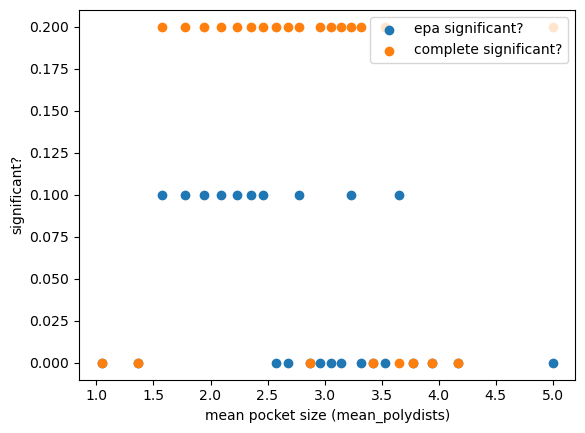

In [45]:
# testing pocket vol:
sdf = plays_with_collapse[
    plays_with_collapse.surv_frame > plays_with_collapse.pass_frame
]
pressdf = plays_with_collapse[
    ~(plays_with_collapse.surv_frame > plays_with_collapse.pass_frame)
]

print("pvalue", stats.mannwhitneyu(sdf.epa, pressdf.epa).pvalue)
print(
    "pvalue",
    stats.chi2_contingency(
        [
            [sdf.complete.sum(), len(sdf) - sdf.complete.sum()],
            [pressdf.complete.sum(), len(pressdf) - pressdf.complete.sum()],
        ]
    ).pvalue,
)
print(
    "pvalue",
    stats.chi2_contingency(
        [
            [sdf.sack.sum(), len(sdf) - sdf.sack.sum()],
            [pressdf.sack.sum(), len(pressdf) - pressdf.sack.sum()],
        ]
    ).pvalue,
)
p_vals = np.ones(25)
p_vals1 = np.ones(25)
p_vals2 = np.ones(25)
for i in trange(1, 25):
    spi = sdf[sdf.mean_polydists.between(bins[i - 1], bins[i])]
    ppi = pressdf[pressdf.mean_polydists.between(bins[i - 1], bins[i])]
    _, pv = stats.mannwhitneyu(spi.epa, ppi.epa)
    if (
        np.array(
            [
                [spi.complete.sum(), len(spi) - spi.complete.sum()],
                [ppi.complete.sum(), len(ppi) - ppi.complete.sum()],
            ]
        )
        < 1
    ).any():
        pc1 = 2
    else:
        _, pc1, _, _ = stats.chi2_contingency(
            [
                [spi.complete.sum(), len(spi) - spi.complete.sum()],
                [ppi.complete.sum(), len(ppi) - ppi.complete.sum()],
            ]
        )

    if (
        np.array(
            [
                [spi.sack.sum(), len(spi) - spi.sack.sum()],
                [ppi.sack.sum(), len(ppi) - ppi.sack.sum()],
            ]
        )
        < 1
    ).any():
        pc2 = 2
    else:
        _, pc2, _, _ = stats.chi2_contingency(
            [
                [spi.sack.sum(), len(spi) - spi.sack.sum()],
                [ppi.sack.sum(), len(ppi) - ppi.sack.sum()],
            ]
        )
    if not np.isnan(pv):
        p_vals[i] = pv
    if not np.isnan(pc1):
        p_vals1[i] = pc1
    if not np.isnan(pc2):
        p_vals2[i] = pc2

# plt.plot(p_vals, label="epa")
# plt.plot(p_vals1, label="complete")
# plt.plot(p_vals2, label="sack")
plt.scatter(bins[1:], (p_vals < 0.05) * 0.1, label="epa significant?")
plt.scatter(bins[1:], (p_vals1 < 0.05) * 0.2, label="complete significant?")
# plt.plot((p_vals2<0.05)*0.3, label="sack significant?")
plt.xlabel("mean pocket size (mean_polydists)")
plt.ylabel("significant?")
plt.legend(loc="upper right")
plt.show()

### there seems to be a significant difference between safe and non safe passes for pocket size 

pvalue 7.055409085341786e-52
pvalue 9.450405867075952e-138
pvalue 4.334562698569275e-135


  0%|          | 0/24 [00:00<?, ?it/s]

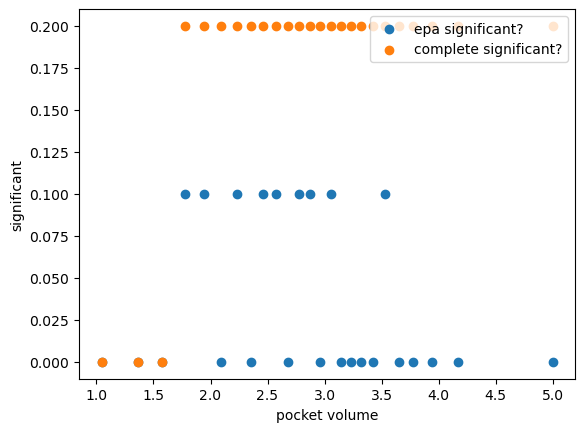

In [46]:
# testing pocket vol:
sdf = plays_with_collapse[
    plays_with_collapse.surv_frame > plays_with_collapse.pass_frame
]
pressdf = plays_with_collapse[
    ~(plays_with_collapse.surv_frame > plays_with_collapse.pass_frame)
]

print("pvalue", stats.mannwhitneyu(sdf.epa, pressdf.epa).pvalue)
print(
    "pvalue",
    stats.chi2_contingency(
        [
            [sdf.complete.sum(), len(sdf) - sdf.complete.sum()],
            [pressdf.complete.sum(), len(pressdf) - pressdf.complete.sum()],
        ]
    ).pvalue,
)
print(
    "pvalue",
    stats.chi2_contingency(
        [
            [sdf.sack.sum(), len(sdf) - sdf.sack.sum()],
            [pressdf.sack.sum(), len(pressdf) - pressdf.sack.sum()],
        ]
    ).pvalue,
)
p_vals = np.ones(25)
p_vals1 = np.ones(25)
p_vals2 = np.ones(25)
for i in trange(1, 25):
    spi = sdf[sdf.pocket_vol.between(vol_bins[i - 1], vol_bins[i])]
    ppi = pressdf[pressdf.pocket_vol.between(vol_bins[i - 1], vol_bins[i])]
    _, pv = stats.mannwhitneyu(spi.epa, ppi.epa)
    if (
        np.array(
            [
                [spi.complete.sum(), len(spi) - spi.complete.sum()],
                [ppi.complete.sum(), len(ppi) - ppi.complete.sum()],
            ]
        )
        < 1
    ).any():
        pc1 = 2
    else:
        _, pc1, _, _ = stats.chi2_contingency(
            [
                [spi.complete.sum(), len(spi) - spi.complete.sum()],
                [ppi.complete.sum(), len(ppi) - ppi.complete.sum()],
            ]
        )

    if (
        np.array(
            [
                [spi.sack.sum(), len(spi) - spi.sack.sum()],
                [ppi.sack.sum(), len(ppi) - ppi.sack.sum()],
            ]
        )
        < 1
    ).any():
        pc2 = 2
    else:
        _, pc2, _, _ = stats.chi2_contingency(
            [
                [spi.sack.sum(), len(spi) - spi.sack.sum()],
                [ppi.sack.sum(), len(ppi) - ppi.sack.sum()],
            ]
        )
    if not np.isnan(pv):
        p_vals[i] = pv
    if not np.isnan(pc1):
        p_vals1[i] = pc1
    if not np.isnan(pc2):
        p_vals2[i] = pc2

# plt.plot(p_vals, label="epa")
# plt.plot(p_vals1, label="complete")
# plt.plot(p_vals2, label="sack")
plt.scatter(bins[1:], (p_vals < 0.05) * 0.1, label="epa significant?")
plt.scatter(bins[1:], (p_vals1 < 0.05) * 0.2, label="complete significant?")
# plt.plot((p_vals2<0.05)*0.3, label="sack significant?")
plt.xlabel("pocket volume")
plt.ylabel("significant")
plt.legend(loc="upper right")
plt.show()

### pocket volume has significant effect on completion percentage as well as to a lesser degree epa

#### wee see, that there is a clear difference for sacks and comp percentage, but the CI for EPA is too large, suggesting that while there is a clear difference between safe passes and others for some target variables, epa is depending on other stuff as well. As a sanity check, we observe that sacks don't happen on large pockets and whenever there is a pass, there is no sack and when there is no pass, the completion percentage is 0. 

In [47]:
features = [
    "max_frame",
    "surv_frame",
    "mean_polydists",
    "safe_pass",
    "survived",
    "pocket_vol",
]
targets = ["complete", "sack", "epa", "prePenaltyPlayResult"]
models = [
    LogisticRegression,
    LogisticRegression,
    LinearRegression,
    LinearRegression,
]
subsets = [
    [],
    ["max_frame"],
    ["surv_frame"],
    ["mean_polydists"],
    ["pocket_vol"],
    ["max_frame", "safe_pass"],
    ["surv_frame", "safe_pass"],
    ["surv_frame", "mean_polydists"],
    ["surv_frame", "safe_pass", "mean_polydists"],
    ["max_frame", "safe_pass", "pocket_vol"],
    ["max_frame", "mean_polydists", "surv_frame", "safe_pass"]
]

In [48]:
aux_features = ["defendersInBox", "pff_playAction", "possessionTeam",]


In [49]:
plays_with_collapse.pff_passCoverage.value_counts()

pff_passCoverage
Cover-3          2593
Cover-1          1928
Cover-2          1061
Quarters         1006
Cover-6           796
Red Zone          342
Cover-0           229
2-Man             190
Bracket            42
Prevent             9
Miscellaneous       8
Name: count, dtype: int64

### we fit some linear models (logistic regression for binary targets, linear for continuous) to see how the features are connected to the outcomes

In [50]:
acc = []
for i in trange(100):
    X = pd.get_dummies(plays_with_collapse[["max_frame", "mean_polydists", "surv_frame", "safe_pass"]+aux_features], columns=["possessionTeam"])
    
    X[["max_frame", "mean_polydists", "surv_frame",]] = (X[["max_frame", "mean_polydists", "surv_frame",]]-X[["max_frame", "mean_polydists", "surv_frame",]].mean()) / X[["max_frame", "mean_polydists", "surv_frame",]].std()
    
    y = plays_with_collapse["prePenaltyPlayResult"]
    X_train, X_test, y_train, y_test = train_test_split(X.index, y, test_size=0.2)
    # scaler = StandardScaler()
    # scaler.fit(X.iloc[X_train])
    # Xs = scaler.transform(X.iloc[X_train])
    # Xts = scaler.transform(X.iloc[X_test])

    pocket_cushion = LinearRegression()
    pocket_cushion.fit(X=X.iloc[X_train], y=y_train)

    acc.append(pocket_cushion.score(X=X.iloc[X_test], y=y_test))
    
print("target: prePenaltyPlayResult")
print(f"mean R²: {np.mean(acc)}, std: {np.std(acc)}")
print(plays_with_collapse[["max_frame", "mean_polydists", "surv_frame",]].std())
print("coefficients:" ,{t:float(c) for c, t in zip(np.stack(pocket_cushion.coef_), ["max_frame", "mean_polydists", "surv_frame", "safe_pass"] + aux_features[:-1] + ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN',
       'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LA', 'LAC', 'LV', 'MIA', 'MIN',
       'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN',
       'WAS'])})

  0%|          | 0/100 [00:00<?, ?it/s]

target: prePenaltyPlayResult
mean R²: 0.03803520901501496, std: 0.01234613282406979
max_frame         12.446334
mean_polydists     0.905516
surv_frame         7.627351
dtype: float64
coefficients: {'max_frame': -0.49593269802500756, 'mean_polydists': 1.0253708490430677, 'surv_frame': 0.7493316361445413, 'safe_pass': 1.0786015307074441, 'defendersInBox': -0.12484900055953871, 'pff_playAction': 3.07498108810307, 'ARI': -0.359772084992026, 'ATL': -0.019372660404609266, 'BAL': 0.4950164688367594, 'BUF': 0.7326713664156449, 'CAR': -0.812409558039984, 'CHI': -2.095019186549774, 'CIN': 1.397806213859495, 'CLE': -0.578090856555665, 'DAL': 1.518746133047608, 'DEN': -0.01775707264856936, 'DET': -0.8118554511897313, 'GB': -0.1649193532781713, 'HOU': -0.023967198587464517, 'IND': -0.4426528852804921, 'JAX': -0.5056537496055702, 'KC': 0.5314938460844767, 'LA': 1.188584525288805, 'LAC': -0.23736800398236585, 'LV': 1.5725222426773815, 'MIA': -1.0928993603059798, 'MIN': 0.7288843559119663, 'NE': -0.10

In [51]:
acc = []
for i in trange(100):
    X = pd.get_dummies(plays_with_collapse[["max_frame", "mean_polydists", "surv_frame", "safe_pass"]+aux_features], columns=["possessionTeam"])
    
    y = plays_with_collapse["epa"]
    X_train, X_test, y_train, y_test = train_test_split(X.index, y, test_size=0.2)
    scaler = StandardScaler()
    scaler.fit(X.iloc[X_train])
    Xs = scaler.transform(X.iloc[X_train])
    Xts = scaler.transform(X.iloc[X_test])
    # Xs = X.iloc[X_train]
    # Xts = X.iloc[X_test]

    pocket_cushion = LinearRegression()
    pocket_cushion.fit(X=Xs, y=y_train)

    acc.append(pocket_cushion.score(X=Xts, y=y_test))

print("target: EPA")
print(f"mean R²: {np.mean(acc)}, std: {np.std(acc)}")
print(plays_with_collapse[["max_frame", "mean_polydists", "surv_frame",]].std())
print("coefficients:" ,{t:float(c) for c, t in zip(np.stack(pocket_cushion.coef_), ["max_frame", "mean_polydists", "surv_frame", "safe_pass"] + aux_features[:-1] + ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN',
       'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LA', 'LAC', 'LV', 'MIA', 'MIN',
       'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN',
       'WAS'])})

  0%|          | 0/100 [00:00<?, ?it/s]

target: EPA
mean R²: 0.022638988397551393, std: 0.008432270364798196
max_frame         12.446334
mean_polydists     0.905516
surv_frame         7.627351
dtype: float64
coefficients: {'max_frame': -0.07076346171694817, 'mean_polydists': 0.14562815624570177, 'surv_frame': 0.032347726662961776, 'safe_pass': 0.07416582688530637, 'defendersInBox': 0.012996487781237619, 'pff_playAction': 0.12157930086187597, 'ARI': 0.01037714707592327, 'ATL': -0.008938513207112312, 'BAL': 0.01734057179575739, 'BUF': 0.027800672106346434, 'CAR': -0.018054365505803964, 'CHI': -0.002455302120339471, 'CIN': 0.01597814037254326, 'CLE': -0.017774922412510556, 'DAL': 0.03195621017581738, 'DEN': 0.0012777439346236643, 'DET': -0.037571293521260415, 'GB': 0.011665774446135811, 'HOU': -0.014171982868022067, 'IND': 0.00791066978281926, 'JAX': -0.02897161239245384, 'KC': 0.0035732819996731136, 'LA': 0.0302202678252185, 'LAC': 0.007734917587923096, 'LV': 0.03706879010351157, 'MIA': -0.029939203369269276, 'MIN': 0.02295989

In [52]:
model_results = []
num_feat = ["max_frame",
    "surv_frame",
    "mean_polydists",
    "pocket_vol",
    ]

for tgt, modl in zip(targets, models):
    for feature_set in tqdm(subsets[1:]):
        acc = []
        aics = []
        coefs = []
        intercpts = []
        X = pd.get_dummies(
            plays_with_collapse[feature_set + aux_features], columns=["possessionTeam"]
        )
        y = plays_with_collapse[tgt].to_numpy(dtype="float32")
        for i in range(100):
            numeric_features = list (set(num_feat).intersection(feature_set))
            X[numeric_features] = (
                X[numeric_features] - X[numeric_features].mean()
            ) / X[numeric_features].std()
            
            X_train, X_test, y_train, y_test = train_test_split(
                X.index, y, test_size=0.2
            )

            Xs = X.iloc[X_train]
            Xts =X.iloc[X_test]

            if tgt in ["complete", "sack"]:
                pocket_cushion = modl(class_weight="balanced", max_iter=1000)
            else:
                pocket_cushion = modl()

            pocket_cushion.fit(X=Xs, y=y_train)

            acc.append(pocket_cushion.score(X=Xts, y=y_test))
            aics.append(
                calc_aic(
                    y_test,
                    Xts,
                    pocket_cushion.predict(Xts),
                    len(pocket_cushion.coef_) + 1,
                )
            )
            coefs.append(pocket_cushion.coef_)
            intercpts.append(pocket_cushion.intercept_)
        model_results.append(
            {
                "model": type(pocket_cushion).__name__,
                "target": tgt,
                "features": feature_set,
                "aic": np.round(np.mean(aics), 5),
                "score_mean": np.round(np.mean(acc), 3),
                "score_std": np.round(np.std(acc), 3),
                "coef": [np.round(f, decimals=5) for f in np.mean(coefs, axis=0)],
                "interc": np.round(np.mean(intercpts), 5),
                "max_frame": "max_frame" in feature_set,
                "surv_frame": "surv_frame" in feature_set,
                "mean_polydists": "mean_polydists" in feature_set,
                "safe_pass": "safe_pass" in feature_set,
                "survived": "survived" in feature_set,
                "pocket_vol": "pocket_vol" in feature_set,
            }
        )

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [53]:
print(
    f"baseline: comp% {plays_with_collapse.complete.mean():.5f}, sack% {plays_with_collapse.sack.mean():.5f}, mean epa {plays_with_collapse.epa.mean():.5f}, mean pppr {plays_with_collapse.prePenaltyPlayResult.mean():.5f}"
)

baseline: comp% 0.54473, sack% 0.06229, mean epa 0.12259, mean pppr 6.57838


In [54]:
resdf = pd.DataFrame(model_results).sort_values("aic")
resdf.head()

model target  \
10  LogisticRegression   sack   
16  LogisticRegression   sack   
19  LogisticRegression   sack   
12  LogisticRegression   sack   
18  LogisticRegression   sack   

                                             features         aic  score_mean  \
10                                        [max_frame]  2011.57104       0.801   
16                       [surv_frame, mean_polydists]  2152.92204       0.783   
19  [max_frame, mean_polydists, surv_frame, safe_p...  2161.74853       0.782   
12                                   [mean_polydists]  2172.12839       0.780   
18                 [max_frame, safe_pass, pocket_vol]  2216.35592       0.774   

    score_std                                               coef   interc  \
10      0.009  [[1.46709, 0.02965, -0.53934, 0.39852, -0.1836... -0.68298   
16      0.010  [[0.34923, -2.45039, -0.23203, -1.43304, 1.406...  0.19165   
19      0.010  [[0.46813, -1.40817, 0.13884, -3.47854, -0.105...  0.19940   
12      0.010  [[-2.24207, -0.23974, -1.24149, 1.46187, -0.40...  0.29495   
18      0.011  [[0.91143, -3.46039, -0.9526, -0.04858, -0.826... -0.02635   

    max_frame  surv_frame  mean_polydists  safe_pass  survived  pocket_vol  
10       True       False           False      False     False       False  
16      False        True            True      False     False       False  
19       True        True            True       True     False       False  
12      False       False            True      False     False       False  
18       True       False           False       True     False        True

In [55]:
resdf[resdf.target == "complete"].head()

model    target  \
4  LogisticRegression  complete   
8  LogisticRegression  complete   
9  LogisticRegression  complete   
5  LogisticRegression  complete   
7  LogisticRegression  complete   

                                            features         aic  score_mean  \
4                             [max_frame, safe_pass]  2926.86677       0.652   
8                 [max_frame, safe_pass, pocket_vol]  2934.29433       0.651   
9  [max_frame, mean_polydists, surv_frame, safe_p...  2969.91999       0.643   
5                            [surv_frame, safe_pass]  2985.05782       0.640   
7            [surv_frame, safe_pass, mean_polydists]  3015.60313       0.633   

   score_std                                               coef   interc  \
4      0.010  [[-0.53569, 0.76406, -0.10431, 0.53255, 0.0371...  0.08131   
8      0.010  [[-0.57626, 0.63847, 0.08797, -0.09555, 0.5463...  0.08750   
9      0.012  [[-0.39644, 0.24552, -0.12234, 0.66246, -0.083... -0.00639   
5      0.011  [[-0.26651, 1.35361, -0.09824, 0.44491, -0.025... -0.22589   
7      0.011  [[-0.34165, 0.91286, 0.40058, -0.07244, 0.6553... -0.19410   

   max_frame  surv_frame  mean_polydists  safe_pass  survived  pocket_vol  
4       True       False           False       True     False       False  
8       True       False           False       True     False        True  
9       True        True            True       True     False       False  
5      False        True           False       True     False       False  
7      False        True            True       True     False       False

In [56]:
resdf[resdf.target == "epa"].sort_values("score_mean", ascending=False).head()

model target  \
28  LinearRegression    epa   
27  LinearRegression    epa   
29  LinearRegression    epa   
22  LinearRegression    epa   
26  LinearRegression    epa   

                                             features         aic  score_mean  \
28                 [max_frame, safe_pass, pocket_vol]  6145.44455       0.023   
27            [surv_frame, safe_pass, mean_polydists]  6124.76097       0.022   
29  [max_frame, mean_polydists, surv_frame, safe_p...  6139.56995       0.022   
22                                   [mean_polydists]  6150.12915       0.022   
26                       [surv_frame, mean_polydists]  6144.17042       0.019   

    score_std                                               coef   interc  \
28      0.009  [-0.11013, 0.16358, 0.15124, 0.01635, 0.22327,... -0.11392   
27      0.008  [-0.00245, 0.20507, 0.18278, 0.02203, 0.27605,... -0.18381   
29      0.008  [-0.07245, 0.15657, 0.03755, 0.15204, 0.02074,... -0.14545   
22      0.007  [0.25357, 0.03035, 0.28313, 0.02588, 0.01337, ... -0.12335   
26      0.008  [0.005, 0.25404, 0.03142, 0.28106, 0.0175, 0.0... -0.13192   

    max_frame  surv_frame  mean_polydists  safe_pass  survived  pocket_vol  
28       True       False           False       True     False        True  
27      False        True            True       True     False       False  
29       True        True            True       True     False       False  
22      False       False            True      False     False       False  
26      False        True            True      False     False       False

In [57]:
resdf[resdf.target == "prePenaltyPlayResult"].sort_values("score_mean", ascending=False).head()

model                target  \
38  LinearRegression  prePenaltyPlayResult   
39  LinearRegression  prePenaltyPlayResult   
37  LinearRegression  prePenaltyPlayResult   
36  LinearRegression  prePenaltyPlayResult   
33  LinearRegression  prePenaltyPlayResult   

                                             features          aic  \
38                 [max_frame, safe_pass, pocket_vol]  12280.95567   
39  [max_frame, mean_polydists, surv_frame, safe_p...  12251.49763   
37            [surv_frame, safe_pass, mean_polydists]  12281.00862   
36                       [surv_frame, mean_polydists]  12288.30677   
33                                       [pocket_vol]  12304.56567   

    score_mean  score_std                                               coef  \
38       0.042      0.011  [-0.58917, 0.90121, 1.55995, -0.11974, 2.66752...   
39       0.039      0.012  [-0.60832, 1.00977, 0.90668, 0.88928, -0.11328...   
37       0.038      0.011  [0.56173, 1.32201, 1.24317, -0.11405, 2.8494, ...   
36       0.037      0.010  [0.62053, 1.68216, -0.05548, 2.85753, -0.19589...   
33       0.035      0.011  [1.86302, -0.06789, 2.24653, -0.0985, 0.07906,...   

     interc  max_frame  surv_frame  mean_polydists  safe_pass  survived  \
38  6.19895       True       False           False       True     False   
39  6.15502       True        True            True       True     False   
37  5.89915      False        True            True       True     False   
36  6.24703      False        True            True      False     False   
33  6.46209      False       False           False      False     False   

    pocket_vol  
38        True  
39       False  
37       False  
36       False  
33        True

### so we can connect the various features to the play outcomes, however: our models show that pocket size or duration only accounts for a small portion of the play outcome, which can be expected given the complexity of the sport and different pieces involved. We only use a small number of game situation aspects in these models, such as a  play_action flag, as play action tends to make a large difference in outcome: 

In [58]:
plays_with_collapse.groupby("pff_playAction").epa.mean()

pff_playAction
0    0.095539
1    0.208725
Name: epa, dtype: float64

### looking at the correlation betweeen featuers and outcomes, we can see that there is some correlation but mostly it is on the weaker side (i.e. sacks are predicted by pocket size and survival duration) 

In [59]:
plays_with_collapse[["polydist", "surv_frame", "max_frame", "mean_polydists", "survived", "pocket_vol", "pff_playAction", "epa", "sack"]].corr()

polydist  surv_frame  max_frame  mean_polydists  survived  \
polydist        1.000000    0.152689  -0.322699        0.708692  0.734418   
surv_frame      0.152689    1.000000   0.344129        0.308704  0.247966   
max_frame      -0.322699    0.344129   1.000000       -0.431238 -0.376774   
mean_polydists  0.708692    0.308704  -0.431238        1.000000  0.620703   
survived        0.734418    0.247966  -0.376774        0.620703  1.000000   
pocket_vol      0.553603    0.762851  -0.069223        0.821284  0.547675   
pff_playAction -0.078853    0.090897   0.192342       -0.317150 -0.130705   
epa             0.070251    0.060220  -0.088195        0.135203  0.105426   
sack           -0.051799   -0.081041   0.267852       -0.293782 -0.213820   

                pocket_vol  pff_playAction       epa      sack  
polydist          0.553603       -0.078853  0.070251 -0.051799  
surv_frame        0.762851        0.090897  0.060220 -0.081041  
max_frame        -0.069223        0.192342 -0.088195  0.267852  
mean_polydists    0.821284       -0.317150  0.135203 -0.293782  
survived          0.547675       -0.130705  0.105426 -0.213820  
pocket_vol        1.000000       -0.117030  0.127178 -0.237272  
pff_playAction   -0.117030        1.000000  0.031011  0.004560  
epa               0.127178        0.031011  1.000000 -0.296354  
sack             -0.237272        0.004560 -0.296354  1.000000

In [60]:
resdf[(resdf.target == "prePenaltyPlayResult") & (resdf.surv_frame) & (resdf.pocket_vol==False) & resdf.mean_polydists]

model                target  \
39  LinearRegression  prePenaltyPlayResult   
37  LinearRegression  prePenaltyPlayResult   
36  LinearRegression  prePenaltyPlayResult   

                                             features          aic  \
39  [max_frame, mean_polydists, surv_frame, safe_p...  12251.49763   
37            [surv_frame, safe_pass, mean_polydists]  12281.00862   
36                       [surv_frame, mean_polydists]  12288.30677   

    score_mean  score_std                                               coef  \
39       0.039      0.012  [-0.60832, 1.00977, 0.90668, 0.88928, -0.11328...   
37       0.038      0.011  [0.56173, 1.32201, 1.24317, -0.11405, 2.8494, ...   
36       0.037      0.010  [0.62053, 1.68216, -0.05548, 2.85753, -0.19589...   

     interc  max_frame  surv_frame  mean_polydists  safe_pass  survived  \
39  6.15502       True        True            True       True     False   
37  5.89915      False        True            True       True     False   
36  6.24703      False        True            True      False     False   

    pocket_vol  
39       False  
37       False  
36       False

In [61]:
resdf[resdf.target == "prePenaltyPlayResult"].sort_values("score_mean", ascending=False).head(5)

model                target  \
38  LinearRegression  prePenaltyPlayResult   
39  LinearRegression  prePenaltyPlayResult   
37  LinearRegression  prePenaltyPlayResult   
36  LinearRegression  prePenaltyPlayResult   
33  LinearRegression  prePenaltyPlayResult   

                                             features          aic  \
38                 [max_frame, safe_pass, pocket_vol]  12280.95567   
39  [max_frame, mean_polydists, surv_frame, safe_p...  12251.49763   
37            [surv_frame, safe_pass, mean_polydists]  12281.00862   
36                       [surv_frame, mean_polydists]  12288.30677   
33                                       [pocket_vol]  12304.56567   

    score_mean  score_std                                               coef  \
38       0.042      0.011  [-0.58917, 0.90121, 1.55995, -0.11974, 2.66752...   
39       0.039      0.012  [-0.60832, 1.00977, 0.90668, 0.88928, -0.11328...   
37       0.038      0.011  [0.56173, 1.32201, 1.24317, -0.11405, 2.8494, ...   
36       0.037      0.010  [0.62053, 1.68216, -0.05548, 2.85753, -0.19589...   
33       0.035      0.011  [1.86302, -0.06789, 2.24653, -0.0985, 0.07906,...   

     interc  max_frame  surv_frame  mean_polydists  safe_pass  survived  \
38  6.19895       True       False           False       True     False   
39  6.15502       True        True            True       True     False   
37  5.89915      False        True            True       True     False   
36  6.24703      False        True            True      False     False   
33  6.46209      False       False           False      False     False   

    pocket_vol  
38        True  
39       False  
37       False  
36       False  
33        True

#### predicting play outcome based on the survival frame or pocket size can be visualized 

In [62]:
px.scatter(plays_with_collapse, x="surv_frame", y="prePenaltyPlayResult", trendline="ols")

In [63]:
px.scatter(plays_with_collapse, x="surv_frame", y="prePenaltyPlayResult", color="safe_pass", trendline="ols")

In [64]:
px.scatter(plays_with_collapse, x="mean_polydists", y="epa", trendline="ols")

#### 

#### overall difference between safe and non safe passes. What about if corrected for survival frame, mean pocket size and pocket volume?

## now that we showed the utility of pocket size, duration and survival for predicting play outcome as well as wether the pocket is intact at the time of the pass (if there is a pass) we can use this to perform further analysis 
### as an example: team differences 

#### correlations of different features _by offense/defense_ indicate actionable insights: 
##### Offense split

In [65]:
plays_with_collapse.loc[
    plays_with_collapse.surv_frame.between(p05, p95),
    [
        "sack",
        "complete",
        "epa",
        "polydist",
        "mean_polydists",
        "surv_frame",
        "pocket_vol",
        "prePenaltyPlayResult",
        "air_yards",
        "comp_air_yards",
    ],
].corr()

sack  complete       epa  polydist  mean_polydists  \
sack                  1.000000 -0.282243 -0.290899 -0.052318       -0.306681   
complete             -0.282243  1.000000  0.542989  0.158853        0.243268   
epa                  -0.290899  0.542989  1.000000  0.056355        0.129950   
polydist             -0.052318  0.158853  0.056355  1.000000        0.713991   
mean_polydists       -0.306681  0.243268  0.129950  0.713991        1.000000   
surv_frame           -0.087519  0.000375  0.060958  0.140003        0.266277   
pocket_vol           -0.265051  0.173579  0.130187  0.587924        0.859888   
prePenaltyPlayResult -0.342466  0.602272  0.713128  0.037459        0.137611   
air_yards                  NaN -0.249574  0.128240 -0.103979       -0.044412   
comp_air_yards             NaN  0.485668  0.672333  0.003952        0.027515   

                      surv_frame  pocket_vol  prePenaltyPlayResult  air_yards  \
sack                   -0.087519   -0.265051             -0.342466        NaN   
complete                0.000375    0.173579              0.602272  -0.249574   
epa                     0.060958    0.130187              0.713128   0.128240   
polydist                0.140003    0.587924              0.037459  -0.103979   
mean_polydists          0.266277    0.859888              0.137611  -0.044412   
surv_frame              1.000000    0.695491              0.115937   0.223000   
pocket_vol              0.695491    1.000000              0.166484   0.101685   
prePenaltyPlayResult    0.115937    0.166484              1.000000   0.285836   
air_yards               0.223000    0.101685              0.285836   1.000000   
comp_air_yards          0.137997    0.102554              0.858112   0.454587   

                      comp_air_yards  
sack                             NaN  
complete                    0.485668  
epa                         0.672333  
polydist                    0.003952  
mean_polydists              0.027515  
surv_frame                  0.137997  
pocket_vol                  0.102554  
prePenaltyPlayResult        0.858112  
air_yards                   0.454587  
comp_air_yards              1.000000

In [66]:
cdf = plays_with_collapse.loc[
    plays_with_collapse.surv_frame.between(p05, p95),
    [
        "sack",
        "possessionTeam",
        "defendersInBox", 
        "pff_playAction",
    ],
].groupby(["possessionTeam", "defendersInBox", "pff_playAction"]).count().reset_index()
cdf[cdf.possessionTeam.isin(["KC", "CLE", "PHI"])].rename(columns={"sack":"number_of_plays"})

possessionTeam  defendersInBox  pff_playAction  number_of_plays
63             CLE             4.0               0               11
64             CLE             5.0               0               40
65             CLE             5.0               1                3
66             CLE             6.0               0               78
67             CLE             6.0               1               15
68             CLE             7.0               0               27
69             CLE             7.0               1               26
70             CLE             8.0               0                3
71             CLE             8.0               1               11
133             KC             4.0               0               43
134             KC             5.0               0              115
135             KC             6.0               0               83
136             KC             6.0               1               36
137             KC             7.0               0                5
138             KC             7.0               1               14
139             KC             8.0               0                1
140             KC             8.0               1                2
219            PHI             4.0               0               19
220            PHI             4.0               1                1
221            PHI             5.0               0               31
222            PHI             5.0               1                3
223            PHI             6.0               0               79
224            PHI             6.0               1               18
225            PHI             7.0               0               35
226            PHI             7.0               1               13
227            PHI             8.0               0                5
228            PHI             8.0               1                2

In [67]:
# correlation with surv_frame
cdf2 = plays_with_collapse.loc[
    plays_with_collapse.surv_frame.between(p05, p95),
    [
        # "sack",
        # "complete",
        "epa",
        "polydist",
        "mean_polydists",
        "surv_frame",
        # "pocket_vol",
        "prePenaltyPlayResult",
        # "air_yards",
        "comp_air_yards",
        "possessionTeam",
        "defendersInBox", 
        "pff_playAction",
    ],
].groupby(["possessionTeam", "defendersInBox", "pff_playAction"]).progress_apply(
    lambda df: df.drop(columns=["possessionTeam", "epa", "defendersInBox", "pff_playAction"]).corrwith(df.epa)
).reset_index().dropna()
cdf2 = pd.merge(cdf2, cdf, on=["possessionTeam", "defendersInBox", "pff_playAction"], how="left")
print(cdf2[cdf2.possessionTeam.isin(["KC", "CLE", "PHI"]) & (cdf2.sack>10)].sort_values(["possessionTeam", "defendersInBox", "pff_playAction"]).to_markdown())

  0%|          | 0/281 [00:00<?, ?it/s]

c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\numpy\lib\_function_base_impl.py:3037: RuntimeWarning:

Degrees of freedom <= 0 for slice

c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\numpy\lib\_function_base_impl.py:2894: RuntimeWarning:

divide by zero encountered in divide

c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\numpy\lib\_function_base_impl.py:2894: RuntimeWarning:

invalid value encountered in multiply

c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\numpy\lib\_function_base_impl.py:3037: RuntimeWarning:

Degrees of freedom <= 0 for slice

c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\numpy\lib\_function_base_impl.py:2894: RuntimeWarning:

divide by zero encountered in divide

c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\numpy\lib\_function_base_impl.py:2894: RuntimeWarning:

invalid value encountered in multiply

c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: Ru

|     | possessionTeam   |   defendersInBox |   pff_playAction |   polydist |   mean_polydists |   surv_frame |   prePenaltyPlayResult |   comp_air_yards |   sack |
|----:|:-----------------|-----------------:|-----------------:|-----------:|-----------------:|-------------:|-----------------------:|-----------------:|-------:|
|  51 | CLE              |                4 |                0 | -0.198095  |       -0.376025  |  -0.100322   |               0.908013 |         0.990491 |     11 |
|  52 | CLE              |                5 |                0 | -0.218462  |        0.0474629 |   0.0300391  |               0.799234 |         0.717615 |     40 |
|  54 | CLE              |                6 |                0 |  0.25897   |        0.443097  |   0.0214797  |               0.743266 |         0.748909 |     78 |
|  55 | CLE              |                6 |                1 |  0.251366  |        0.191981  |   0.00626296 |               0.213594 |        -0.109938 |     15 |
|  56 | CL

c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\numpy\lib\_function_base_impl.py:3037: RuntimeWarning:

Degrees of freedom <= 0 for slice

c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\numpy\lib\_function_base_impl.py:2894: RuntimeWarning:

divide by zero encountered in divide

c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\numpy\lib\_function_base_impl.py:2894: RuntimeWarning:

invalid value encountered in multiply

c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning:

invalid value encountered in divide

c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning:

invalid value encountered in divide

c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\numpy\lib\_function_base_impl.py:3037: RuntimeWarning:

Degrees of freedom <= 0 for slice

c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\numpy\lib\_function_base_impl.py:2894: Runti

In [68]:
# correlation with surv_frame by offense
plays_with_collapse.loc[
    plays_with_collapse.surv_frame.between(p05, p95),
    [
        "sack",
        "complete",
        "epa",
        "polydist",
        "mean_polydists",
        "surv_frame",
        "pocket_vol",
        "prePenaltyPlayResult",
        "air_yards",
        "comp_air_yards",
        "possessionTeam",
    ],
].groupby("possessionTeam").progress_apply(
    lambda df: df.drop(columns=["possessionTeam", "surv_frame"]).corrwith(df.surv_frame)
).reset_index().sort_values(
    "epa"
)

  0%|          | 0/32 [00:00<?, ?it/s]

possessionTeam      sack  complete       epa  polydist  mean_polydists  \
15             KC -0.020612 -0.188374 -0.182602  0.026102        0.114967   
14            JAX  0.006301 -0.081490 -0.143233  0.191651        0.333271   
26            PIT  0.148088 -0.241033 -0.120902  0.097276        0.031315   
29             TB -0.032604 -0.060305 -0.062895  0.055598        0.088311   
22             NO -0.035498 -0.029839 -0.034962  0.102777        0.216363   
6             CIN -0.136266 -0.036939 -0.029929  0.127112        0.295655   
12            HOU -0.172223 -0.020631 -0.026344  0.112867        0.198869   
8             DAL -0.137876  0.031055 -0.010343  0.280550        0.368754   
4             CAR -0.041309 -0.133081 -0.005579  0.199958        0.326854   
0             ARI -0.068510  0.069037  0.048514  0.177559        0.394540   
7             CLE -0.179913 -0.031699  0.058768  0.074061        0.307919   
21             NE -0.023795 -0.049495  0.059448  0.122988        0.229361   
24            NYJ -0.060025  0.070443  0.062002  0.262733        0.330444   
9             DEN -0.156390 -0.060321  0.064052  0.086552        0.270282   
10            DET -0.148100  0.038269  0.070655  0.176465        0.336560   
19            MIA -0.170175 -0.002338  0.074571  0.052598        0.192638   
23            NYG -0.089855  0.094474  0.080285  0.206424        0.332362   
17            LAC -0.143654  0.066537  0.082509  0.249218        0.323836   
1             ATL -0.009867 -0.037439  0.089477  0.329301        0.319916   
31            WAS -0.029601 -0.079923  0.091369  0.079865        0.225413   
30            TEN -0.192903  0.123778  0.098011  0.196878        0.393901   
28             SF -0.031803  0.076877  0.112865  0.122329        0.208669   
18             LV -0.149330 -0.038109  0.118336  0.131900        0.310906   
27            SEA -0.121176  0.099348  0.124551  0.314329        0.309499   
3             BUF  0.033928  0.085631  0.128691  0.190221        0.226267   
5             CHI -0.107970  0.041370  0.140165  0.038738        0.278916   
20            MIN -0.034658  0.136882  0.162361  0.224323        0.309523   
16             LA -0.029325 -0.039658  0.166436  0.053158        0.301216   
13            IND -0.229269  0.082371  0.200369  0.067915        0.236627   
25            PHI -0.112579  0.125761  0.204418  0.194241        0.271885   
11             GB -0.054499  0.060939  0.213086 -0.032052        0.209087   
2             BAL -0.101841  0.156139  0.215791 -0.007605        0.298473   

    pocket_vol  prePenaltyPlayResult  air_yards  comp_air_yards  
15    0.632301             -0.043419   0.273763       -0.022435  
14    0.722677             -0.101180   0.057873       -0.073190  
26    0.672137             -0.012833   0.224338        0.103624  
29    0.657818              0.042150   0.289145        0.139910  
22    0.641677              0.130772   0.299187        0.126466  
6     0.709770             -0.006245   0.090842        0.030940  
12    0.660859              0.040807   0.249085        0.017657  
8     0.749568              0.063426   0.174430        0.078583  
4     0.722039             -0.016582   0.190745       -0.019321  
0     0.768735              0.095155   0.208863        0.077072  
7     0.698512              0.155454   0.303129        0.211012  
21    0.673607              0.053968   0.190012        0.130793  
24    0.691646              0.153690   0.125389        0.149149  
9     0.688865              0.124613   0.368433        0.107819  
10    0.725303              0.134126   0.111322        0.177923  
19    0.669664              0.126771   0.267469        0.079247  
23    0.764271              0.166428   0.235865        0.211130  
17    0.703198              0.118361   0.266934        0.156389  
1     0.730018              0.047790   0.220477        0.081927  
31    0.709673              0.006488   0.090290        0.102081  
30    0.756436              0.229519   0.272035        0.169926  
28    0.6

In [69]:
# correlation with surv_frame by defense
plays_with_collapse.loc[
    plays_with_collapse.surv_frame.between(p05, p95),
    [
        "sack",
        "complete",
        "epa",
        "polydist",
        "mean_polydists",
        "surv_frame",
        "pocket_vol",
        "prePenaltyPlayResult",
        "air_yards",
        "comp_air_yards",
        "defensiveTeam",
    ],
].groupby("defensiveTeam").progress_apply(
    lambda df: df.drop(columns=["defensiveTeam", "surv_frame"]).corrwith(df.surv_frame)
).reset_index().sort_values(
    "epa"
)

  0%|          | 0/32 [00:00<?, ?it/s]

defensiveTeam      sack  complete       epa  polydist  mean_polydists  \
9            DEN -0.083107 -0.053594 -0.052048  0.068297        0.188963   
25           PHI -0.149048 -0.114418 -0.050885  0.158532        0.167474   
31           WAS -0.014477 -0.078783 -0.041481  0.077635        0.260816   
3            BUF -0.183748 -0.038430 -0.030753  0.145948        0.195695   
30           TEN -0.065135 -0.057165 -0.025575  0.167426        0.266868   
22            NO  0.057312 -0.056499 -0.011224  0.073991        0.217165   
12           HOU -0.048102  0.014274 -0.007949  0.243131        0.428199   
11            GB -0.006952 -0.065826 -0.002954 -0.027587        0.149063   
18            LV -0.082543 -0.016711  0.019348  0.150629        0.224309   
27           SEA -0.048833 -0.081838  0.020973  0.219553        0.316392   
23           NYG  0.041426 -0.068116  0.032807  0.066345        0.229161   
28            SF -0.048761 -0.066005  0.039554  0.190715        0.309689   
7            CLE -0.007602 -0.016920  0.044627  0.088807        0.255826   
21            NE -0.115514  0.103686  0.048448  0.258101        0.339550   
14           JAX -0.102311  0.089968  0.063523  0.197371        0.349639   
20           MIN -0.206378  0.062458  0.064485  0.250305        0.415229   
17           LAC -0.158038 -0.092479  0.084260  0.129170        0.241351   
8            DAL -0.117872 -0.023569  0.089144  0.126820        0.220926   
4            CAR -0.170880  0.012812  0.089453  0.232229        0.334401   
24           NYJ -0.034431  0.008944  0.095358  0.184728        0.236633   
2            BAL -0.151219  0.058895  0.100190  0.087019        0.264759   
16            LA -0.129204  0.090084  0.102695  0.132685        0.284219   
29            TB  0.028553  0.040629  0.104293  0.161953        0.238857   
26           PIT -0.173621 -0.020320  0.109307  0.101596        0.198943   
15            KC -0.060296 -0.011975  0.122425  0.168628        0.284535   
0            ARI -0.171622  0.135104  0.123399 -0.109906        0.114717   
1            ATL -0.106615  0.140121  0.125853  0.160858        0.243357   
10           DET -0.006294  0.042473  0.140040  0.133618        0.306228   
19           MIA -0.127567  0.057783  0.147278  0.139609        0.288587   
5            CHI -0.162073 -0.006091  0.151059  0.027348        0.278181   
13           IND -0.267456  0.086845  0.153880  0.242684        0.357707   
6            CIN  0.016228  0.003461  0.153940  0.055283        0.127998   

    pocket_vol  prePenaltyPlayResult  air_yards  comp_air_yards  
9     0.658338              0.052969   0.259422        0.084505  
25    0.604028              0.009044   0.089779       -0.039090  
31    0.686993              0.005169   0.229406        0.065022  
3     0.664765              0.069321   0.180834        0.017639  
30    0.672051              0.063375   0.201632        0.089108  
22    0.680385              0.037903   0.149684        0.102399  
12    0.761022              0.090794   0.185874        0.130160  
11    0.639992             -0.033105   0.246686        0.072017  
18    0.680045              0.128058   0.328544        0.122285  
27    0.742412              0.165440   0.257208        0.101190  
23    0.664703              0.088955   0.279237        0.143760  
28    0.697947              0.078068   0.239719        0.053322  
7     0.724718              0.049035   0.229084        0.092154  
21    0.712548              0.139844   0.155158        0.119078  
14    0.700951              0.120291   0.166281        0.095875  
20    0.763238              0.039358   0.066601        0.053104  
17    0.726514              0.178242   0.326650        0.175580  
8     0.659910              0.081374   0.231853        0.096063  
4     0.740590              0.130935   0.241496        0.174149  
24    0.661454              0.084821   0.152346        0.081288  
2     0.675048              0.093512   0.164623        0.097215  
16    0.697673              0.271270   0.2

### correlation with pocket volume (duration * size)
#### here: more pocket space for longer translates to higher completion percentage. Some teams are profiting more (SEA, CHI, PHI) than others (TB, CAR, PIT). 
#### Similarly, better pocket ~ more epa for most teams, especially GB, CHI and PHI, but for some others the connection is less pronounced (TB, NYG). Interestingly, TB (tom brady's offense) has both a low correlation to completion and epa, suggesting he might be less affected by pressure but also less able to profit from non-pressure, where as Jacksonvilles rookie QB trevor lawrence shows improved completion percentage with better pockets but basically no more epa. on the other hand, panthers QB cam newton doesn't post higher completion but higher epa with better pockets


In [70]:
# correlation with pocket_vol by offense
plays_with_collapse.loc[
    plays_with_collapse.surv_frame.between(p05, p95),
    [
        "sack",
        "complete",
        "epa",
        "polydist",
        "mean_polydists",
        "surv_frame",
        "pocket_vol",
        "prePenaltyPlayResult",
        "air_yards",
        "comp_air_yards",
        "possessionTeam",
    ],
].groupby("possessionTeam").progress_apply(
    lambda df: df.drop(columns=["possessionTeam", "pocket_vol"]).corrwith(df.pocket_vol)
).reset_index().sort_values(
    "epa"
)

  0%|          | 0/32 [00:00<?, ?it/s]

possessionTeam      sack  complete       epa  polydist  mean_polydists  \
15             KC -0.181831  0.105195 -0.056920  0.621440        0.823506   
14            JAX -0.203067  0.119555 -0.028498  0.565183        0.876242   
29             TB -0.177330  0.025395 -0.026602  0.541597        0.793030   
22             NO -0.213320  0.157693  0.022247  0.620693        0.872411   
26            PIT -0.271497  0.022352  0.047485  0.553209        0.744148   
12            HOU -0.345208  0.202178  0.051506  0.610501        0.848022   
23            NYG -0.204030  0.178818  0.052289  0.631099        0.843979   
4             CAR -0.214808  0.028346  0.091817  0.561047        0.873426   
24            NYJ -0.279902  0.282916  0.111817  0.650921        0.895144   
6             CIN -0.388756  0.168404  0.112582  0.611771        0.865684   
1             ATL -0.134394  0.091632  0.112712  0.618002        0.865653   
8             DAL -0.238130  0.241884  0.116248  0.711306        0.871430   
0             ARI -0.247612  0.274277  0.117874  0.616674        0.871516   
19            MIA -0.335473  0.156212  0.123270  0.589396        0.839384   
21             NE -0.205171  0.101392  0.123482  0.514022        0.856202   
31            WAS -0.226334  0.145518  0.125101  0.541869        0.828445   
3             BUF -0.139129  0.212726  0.131790  0.611387        0.831402   
17            LAC -0.253637  0.145085  0.144592  0.671769        0.885830   
9             DEN -0.371952  0.134467  0.155325  0.529136        0.869387   
10            DET -0.311831  0.182989  0.165433  0.605822        0.876734   
30            TEN -0.308189  0.285312  0.180269  0.592329        0.880544   
18             LV -0.296618  0.120651  0.185958  0.511365        0.862255   
7             CLE -0.350117  0.200442  0.190840  0.559225        0.876587   
13            IND -0.377596  0.209256  0.192396  0.627329        0.862095   
25            PHI -0.287023  0.291602  0.192614  0.702428        0.872903   
28             SF -0.235699  0.217850  0.194145  0.598136        0.846141   
20            MIN -0.226159  0.224588  0.197570  0.561703        0.888211   
2             BAL -0.322154  0.305069  0.205551  0.487740        0.845870   
5             CHI -0.355100  0.279311  0.209845  0.518165        0.864431   
27            SEA -0.330073  0.321036  0.217220  0.756724        0.893142   
16             LA -0.147466  0.132490  0.219963  0.473744        0.837213   
11             GB -0.284471  0.242776  0.295188  0.465023        0.857399   

    surv_frame  prePenaltyPlayResult  air_yards  comp_air_yards  
15    0.632301             -0.016071   0.026136       -0.059988  
14    0.722677              0.018620  -0.055039       -0.038777  
29    0.657818              0.021147   0.081769        0.003894  
22    0.641677              0.109024   0.181709        0.078082  
26    0.672137              0.094493   0.058471        0.007211  
12    0.660859              0.109830   0.051512       -0.053566  
23    0.764271              0.147636   0.139686        0.130980  
4     0.722039              0.053110   0.153589       -0.008286  
24    0.691646              0.211349  -0.058851        0.038319  
6     0.709770              0.130568   0.005493        0.062832  
1     0.730018              0.112616   0.092367        0.062371  
8     0.749568              0.178536   0.068716        0.105651  
0     0.768735              0.198929   0.124565        0.091199  
19    0.669664              0.179034   0.234186        0.110719  
21    0.673607              0.147103   0.128416        0.185177  
31    0.709673              0.079881   0.021783        0.046382  
3     0.706969              0.168032   0.038328        0.131821  
17    0.703198              0.098439   0.061249        0.069746  
9     0.688865              0.235685   0.288993        0.141474  
10    0.725303              0.179092   0.080202        0.217917  
30    0.756436              0.240526   0.139821        0.137925  
18    0.7

### correlation with mean_polydists
#### here: bigger pocket (independent of duration) translates to higher completion percentage. Some teams are profiting more (SEA, CHI, PHI) than others (TB, CAR, NE, ATL). 
#### Similarly, bigger pocket ~ more epa for most teams, especially GB, CHI and SEA, but for some others the connection is less pronounced (TB, NYG). Interestingly, TB (tom brady's offense) has both a low correlation to completion and epa, suggesting he might be less affected by pressure but also less able to profit from non-pressure, where as others like GBs Aaron rodgers are more affected by it but are also able to use the space given. Then there are the Carolina Panthers, which under pressure produce higher epa but comparatively little correlation to completion percentage.This is of course very similar to the results from pocket vol, as they are related variables. 


In [71]:
# correlation between mean pocket size by offense
plays_with_collapse.loc[
    plays_with_collapse.surv_frame.between(p05, p95),
    [
        "complete",
        "epa",
        "polydist",
        "mean_polydists",
        "surv_frame",
        "pocket_vol",
        "prePenaltyPlayResult",
        "air_yards",
        "comp_air_yards",
        "possessionTeam",
    ],
].groupby("possessionTeam").progress_apply(
    lambda df: df.drop(columns=["possessionTeam", "mean_polydists"]).corrwith(df.mean_polydists)
).reset_index().sort_values(
    "epa"
)

  0%|          | 0/32 [00:00<?, ?it/s]

possessionTeam  complete       epa  polydist  surv_frame  pocket_vol  \
23            NYG  0.190464  0.022691  0.749537    0.332362    0.843979   
22             NO  0.229663  0.023186  0.716702    0.216363    0.872411   
29             TB  0.114462  0.032179  0.718926    0.088311    0.793030   
15             KC  0.286346  0.053617  0.807630    0.114967    0.823506   
14            JAX  0.227415  0.062256  0.656649    0.333271    0.876242   
3             BUF  0.257519  0.074414  0.715284    0.226267    0.831402   
31            WAS  0.271841  0.083944  0.731521    0.225413    0.828445   
0             ARI  0.337295  0.086908  0.780778    0.394540    0.871516   
12            HOU  0.314518  0.098386  0.728323    0.198869    0.848022   
1             ATL  0.158313  0.099352  0.625135    0.319916    0.865653   
21             NE  0.165986  0.104971  0.625657    0.229361    0.856202   
24            NYJ  0.337210  0.105925  0.726408    0.330444    0.895144   
25            PHI  0.307065  0.106972  0.815437    0.271885    0.872903   
4             CAR  0.126551  0.116081  0.653677    0.326854    0.873426   
19            MIA  0.233069  0.123811  0.775160    0.192638    0.839384   
13            IND  0.252547  0.128674  0.766795    0.236627    0.862095   
2             BAL  0.339385  0.133390  0.737900    0.298473    0.845870   
17            LAC  0.169446  0.139958  0.746940    0.323836    0.885830   
16             LA  0.183377  0.150474  0.670824    0.301216    0.837213   
26            PIT  0.254142  0.159924  0.757724    0.031315    0.744148   
8             DAL  0.325436  0.168892  0.806900    0.368754    0.871430   
6             CIN  0.270717  0.169546  0.760912    0.295655    0.865684   
20            MIN  0.223910  0.171963  0.609650    0.309523    0.888211   
28             SF  0.235772  0.172502  0.730651    0.208669    0.846141   
9             DEN  0.239682  0.175007  0.672500    0.270282    0.869387   
10            DET  0.228489  0.176921  0.721913    0.336560    0.876734   
18             LV  0.208489  0.179072  0.637732    0.310906    0.862255   
5             CHI  0.350939  0.179298  0.679426    0.278916    0.864431   
30            TEN  0.324987  0.186552  0.694254    0.393901    0.880544   
7             CLE  0.277014  0.206093  0.721143    0.307919    0.876587   
27            SEA  0.372245  0.216533  0.784715    0.309499    0.893142   
11             GB  0.268735  0.235639  0.683114    0.209087    0.857399   

    prePenaltyPlayResult  air_yards  comp_air_yards  
23              0.095086   0.009449        0.035960  
22              0.053290   0.020113        0.001338  
29              0.005097  -0.149180       -0.110757  
15              0.009698  -0.172818       -0.079318  
14              0.082852  -0.158398       -0.012955  
3               0.073281  -0.136115       -0.041941  
31              0.077527  -0.060110       -0.036186  
0               0.162174  -0.012199        0.014986  
12              0.128206  -0.172925       -0.100328  
1               0.136099  -0.012583        0.051040  
21              0.140900   0.023921        0.137273  
24              0.187631  -0.162043       -0.028382  
25              0.158298  -0.204810       -0.012538  
4               0.057122   0.054699       -0.014994  
19              0.174952   0.074030        0.085797  
13              0.115848  -0.196251       -0.108044  
2               0.157189  -0.000706       -0.024634  
17              0.054939  -0.102302       -0.023902  
16              0.155282   0.023930        0.138624  
26              0.141956  -0.156275       -0.083620  
8               0.197451  -0.047135        0.079528  
6               0.173325  -0.100187        0.045670  
20              0.164383  -0.003426        0.119086  
28              0.074768  -0.065341       -0.014267  
9               0.243224   0.106133        0.115415  
10              0.138902   0.018745        0.160618  
18              0.165366  -0.056730        0.012143  
5              

## example observation for actionable insights (offense play calling): 
Some teams, e.g. ARI have no correlation between surv_frame and epa, meaning, they do not profit from staying intact longer. As a coach this would mean to not prioritize the blitz. 
On the other hand most teams, most notably the Bears (+0.347), Lions(+0.297) or Seahawks(+0.292) show positive correlation between survival time and epa meaning the profit from longer surviving pocket. Rushing the QB to collapse the pocket quicker will be more useful.  

##### by defense

In [72]:
for team_ in plays_with_collapse.possessionTeam.unique():
    print(team_)
    print(
        plays_with_collapse.loc[
            (plays_with_collapse.defensiveTeam == team_)
            & (plays_with_collapse.surv_frame.between(p05, p95)),
            [
                "sack",
                "complete",
                "epa",
                "polydist",
                "mean_polydists",
                "surv_frame",
                "pocket_vol",
                "prePenaltyPlayResult",
                "air_yards",
                "comp_air_yards",
            ],
        ]
        .corr(method="spearman")
        .to_markdown()
    )

TB
|                      |       sack |   complete |        epa |    polydist |   mean_polydists |   surv_frame |   pocket_vol |   prePenaltyPlayResult |   air_yards |   comp_air_yards |
|:---------------------|-----------:|-----------:|-----------:|------------:|-----------------:|-------------:|-------------:|-----------------------:|------------:|-----------------:|
| sack                 |   1        | -0.257476  | -0.302273  | nan         |       -0.284019  |    0.020152  |  -0.230827   |             -0.361122  | nan         |     nan          |
| complete             |  -0.257476 |  1         |  0.590535  |   0.215379  |        0.27753   |    0.0478493 |   0.236035   |              0.777954  |  -0.251999  |       0.627713   |
| epa                  |  -0.302273 |  0.590535  |  1         |   0.0562709 |        0.0992802 |    0.0512263 |   0.112162   |              0.798234  |   0.160076  |       0.770915   |
| polydist             | nan        |  0.215379  |  0.0562709 |   1     

## example observation for actionable insights (defense play calling): 
From the perspective of the defense, we can also deduce useful information. Many teams show a moderate positive correlation between survival time and epa, meaning the opponents offense produces higher epa when the pocket is allowed to survive longer. Conversely, this means those teams should look to apply pressure to the opposing QB. Examples here include the Colts (+0.158) and Rams(+0.128). On the other hand, teams with slight negative correlations (Seahawks) or no correlation (Titans) between epa and survival time can rely more on the secondary covering the WRs and do not have to rely on the pass rush as heavily.

In [73]:
px.scatter(plays_with_collapse[plays_with_collapse.surv_frame.between(p05,p95) & (plays_with_collapse.possessionTeam == "PHI")], x="surv_frame", y="prePenaltyPlayResult", height=500, trendline="ols")

In [74]:
px.scatter(plays_with_collapse[plays_with_collapse.surv_frame.between(p05,p95) & (plays_with_collapse.possessionTeam == "PHI")], x="surv_frame", y="epa", height=500, trendline="ols")

### here we can see, that each extra frame the pocket survives for the Philadelpha Eagles means 0.07 expected higer EPA, and about half a yard more gained per play. 

There are more insights to be gathered from the various combinations of correlations, but for now we move on to survival analysis.

### Next step: Survival analysis of the pocket

The main goal of the offensive line in a pass play is to protect the QB until he throws a pass. This means, preventing the pass rushing players from tackling / pressuring the QB in order to give im time and space to make a play. However, the play dictates how long the pocket needs to hold. As an example, if the QB wants to throw a short pass, the pocket might only need to survive for 1.5-2.5 seconds, where as a longer and deeper pass requires 3.0-4.0 seconds of a clean pocket. This means we cannot simply use the average pocket duration as a performance indicator. We therefore use survival analysis to model the pocket life. This enables a comparison of the pocket based on incomplete observations and observations where the pocket held or collapsed at different play durations. 

##### Kaplan Meier Estimator
The Kaplan Meier estimator describes the portion of the initial observations that survive to a given point point, starting with 100% at the initial t0 and ending with a low percentage at the last observed timestep. the curve is calculated as #survived after t_n / #alive at the start of t_n. As an example, we show the survival curve of the eagles offensive line compared to the league average and the browns pass rush compared to the league average 

#### Life Expectancy
The Kaplan Meier Estimator can also be used to estimate the life expectancy of the pocket (shown in frames (0.1s duration)) to break the curve down into a single number. Overall, the curve of a better oline should be above the average, meaning a higher portion of the pockets survived that many timesteps and therefore have a longer live expectancy. A good pass rush shows the opposite, with the pocket collapsing quicker than the average and thus the curve being below the average. 

In [75]:
# life expectancy
def life_expectancy(x, y):
    auc = x[0] * y[0]
    for i in range(1, len(x)):
        auc += (x[i] - x[i - 1]) * y[i]
    return auc

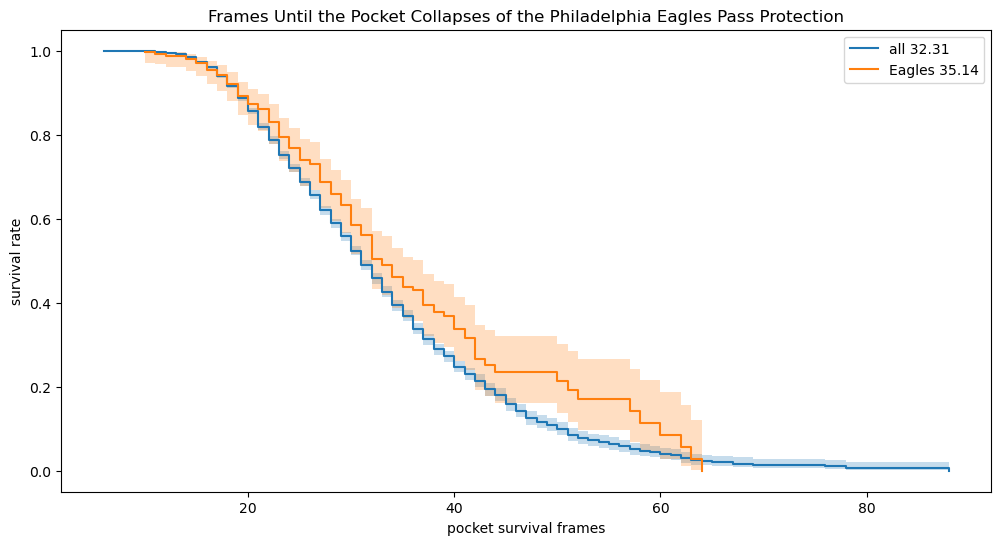

In [76]:
plt.figure(figsize=(12, 6))
x, y, conf_int = kaplan_meier_estimator(
    (
        plays_with_collapse[plays_with_collapse.surv_frame.notna()].poly_frame > -1
    ).to_numpy(),
    plays_with_collapse[plays_with_collapse.surv_frame.notna()].surv_frame.to_numpy(),
    conf_type="log-log",
)
le = life_expectancy(x, y)
plt.step(x, y, where="post", label=f"all {le:3.2f}")
plt.fill_between(x, conf_int[0], conf_int[1], alpha=0.25, step="post")


x, y, conf_int = kaplan_meier_estimator(
    (
        plays_with_collapse[
            plays_with_collapse.surv_frame.notna()
            & (plays_with_collapse.possessionTeam == "PHI")
        ].poly_frame
        > -1
    ).to_numpy(),
    plays_with_collapse[
        plays_with_collapse.surv_frame.notna()
        & (plays_with_collapse.possessionTeam == "PHI")
    ].surv_frame.to_numpy(),
    conf_type="log-log",
)
le = life_expectancy(x, y)
plt.step(x, y, where="post", label=f"Eagles {le:3.2f}")
plt.fill_between(x, conf_int[0], conf_int[1], alpha=0.25, step="post")


plt.xlabel("pocket survival frames")
plt.ylabel("survival rate")
plt.title(
    "Frames Until the Pocket Collapses of the Philadelphia Eagles Pass Protection"
)
plt.legend()
plt.show()

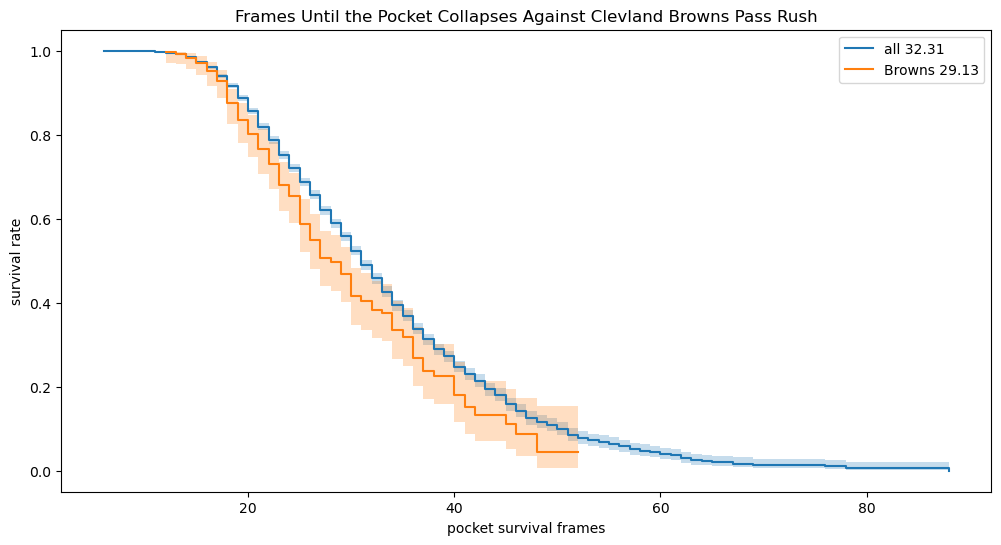

In [77]:
plt.figure(figsize=(12, 6))
x, y, conf_int = kaplan_meier_estimator(
    (
        plays_with_collapse[plays_with_collapse.surv_frame.notna()].poly_frame > -1
    ).to_numpy(),
    plays_with_collapse[plays_with_collapse.surv_frame.notna()].surv_frame.to_numpy(),
    conf_type="log-log",
)
le = life_expectancy(x, y)
plt.step(x, y, where="post", label=f"all {le:3.2f}")
plt.fill_between(x, conf_int[0], conf_int[1], alpha=0.25, step="post")


x, y, conf_int = kaplan_meier_estimator(
    (
        plays_with_collapse[
            plays_with_collapse.surv_frame.notna()
            & (plays_with_collapse.defensiveTeam == "CLE")
        ].poly_frame
        > -1
    ).to_numpy(),
    plays_with_collapse[
        plays_with_collapse.surv_frame.notna()
        & (plays_with_collapse.defensiveTeam == "CLE")
    ].surv_frame.to_numpy(),
    conf_type="log-log",
)
le = life_expectancy(x, y)
plt.step(x, y, where="post", label=f"Browns {le:3.2f}")
plt.fill_between(x, conf_int[0], conf_int[1], alpha=0.25, step="post")

plt.xlabel("pocket survival frames")
plt.ylabel("survival rate")
plt.title("Frames Until the Pocket Collapses Against Clevland Browns Pass Rush")
plt.legend()
plt.show()

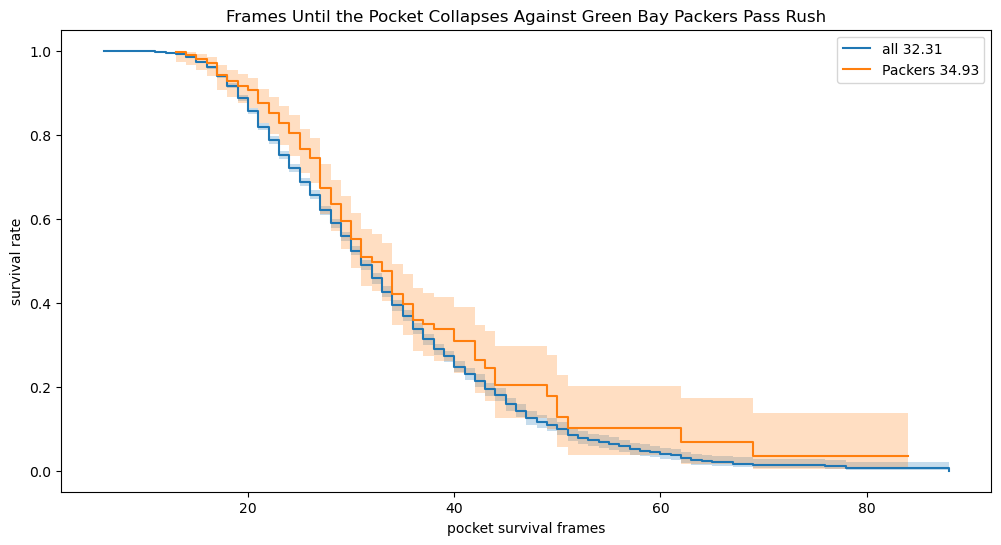

In [78]:
plt.figure(figsize=(12, 6))
x, y, conf_int = kaplan_meier_estimator(
    (
        plays_with_collapse[plays_with_collapse.surv_frame.notna()].poly_frame > -1
    ).to_numpy(),
    plays_with_collapse[plays_with_collapse.surv_frame.notna()].surv_frame.to_numpy(),
    conf_type="log-log",
)
le = life_expectancy(x, y)
plt.step(x, y, where="post", label=f"all {le:3.2f}")
plt.fill_between(x, conf_int[0], conf_int[1], alpha=0.25, step="post")


x, y, conf_int = kaplan_meier_estimator(
    (
        plays_with_collapse[
            plays_with_collapse.surv_frame.notna()
            & (plays_with_collapse.defensiveTeam == "GB")
        ].poly_frame
        > -1
    ).to_numpy(),
    plays_with_collapse[
        plays_with_collapse.surv_frame.notna()
        & (plays_with_collapse.defensiveTeam == "GB")
    ].surv_frame.to_numpy(),
    conf_type="log-log",
)
le = life_expectancy(x, y)
plt.step(x, y, where="post", label=f"Packers {le:3.2f}")
plt.fill_between(x, conf_int[0], conf_int[1], alpha=0.25, step="post")

plt.xlabel("pocket survival frames")
plt.ylabel("survival rate")
plt.title("Frames Until the Pocket Collapses Against Green Bay Packers Pass Rush")
plt.legend()
plt.show()

### we can now do two things: 1. compare the curves directly, and 2. use the life expectancy as proxy quantifying survival of a team or player by all plays of that team or player

### Naive life expectancy of teams: 

In [79]:
les = []
for team in plays_with_collapse.possessionTeam.unique():
    x, y, conf_int = kaplan_meier_estimator(
        (
            plays_with_collapse[
                plays_with_collapse.surv_frame.notna()
                & (plays_with_collapse.defensiveTeam == team)
            ].poly_frame
            > -1
        ).to_numpy(),
        plays_with_collapse[
            plays_with_collapse.surv_frame.notna()
            & (plays_with_collapse.defensiveTeam == team)
        ].surv_frame.to_numpy(),
        conf_type="log-log",
    )
    le_def = life_expectancy(x, y)
    pval_def = compare_survival(
        plays_with_collapse[["survived", "surv_frame"]].to_records(index=False),
        (plays_with_collapse.defensiveTeam == team).to_numpy(),
    )[1]

    x, y, conf_int = kaplan_meier_estimator(
        (
            plays_with_collapse[
                plays_with_collapse.surv_frame.notna()
                & (plays_with_collapse.possessionTeam == team)
            ].poly_frame
            > -1
        ).to_numpy(),
        plays_with_collapse[
            plays_with_collapse.surv_frame.notna()
            & (plays_with_collapse.possessionTeam == team)
        ].surv_frame.to_numpy(),
        conf_type="log-log",
    )
    le_off = life_expectancy(x, y)

    pval_off = compare_survival(
        plays_with_collapse[["survived", "surv_frame"]].to_records(index=False),
        (plays_with_collapse.possessionTeam == team).to_numpy(),
    )[1]

    les.append(
        {
            "team": team,
            "life_expectancy_defense": le_def,
            "sig_diff_def": pval_def < 0.05,
            "life_expectancy_offense": le_off,
            "sig_diff_off": pval_off < 0.05,
            "mean_polydist_off": plays_with_collapse[
                plays_with_collapse.surv_frame.notna()
                & (plays_with_collapse.possessionTeam == team)
            ].mean_polydists.mean(),
            "mean_polydist_def": plays_with_collapse[
                plays_with_collapse.surv_frame.notna()
                & (plays_with_collapse.defensiveTeam == team)
            ].mean_polydists.mean(),
        }
    )

### in the following dataframes, for each team the life expectancy of the opposing pocket is indicated by _life expectancy def_, wether there is a significant (alpha=.05) difference to the league avg, and the _life expectancy offense_ describes the offensive lines pocket and the significant difference to league average is again indicated. The dataframe is shown twice, first sorted by defense then by offense

In [80]:
le_df = pd.DataFrame(les)
le_df.sort_values("life_expectancy_defense")

team  life_expectancy_defense  sig_diff_def  life_expectancy_offense  \
7   CAR                28.181299         False                31.292867   
3   PHI                28.358525         False                35.135125   
20  CLE                29.129604         False                34.569171   
23  MIA                29.718155         False                29.987420   
19  WAS                29.859379          True                32.912098   
5   PIT                30.123296         False                30.132605   
12  HOU                30.808643         False                29.359838   
29   LA                30.815801         False                31.898762   
0    TB                30.860472         False                32.744066   
8   MIN                31.146239         False                30.908015   
21   KC                31.441035         False                31.705495   
15  SEA                31.450858         False                29.539262   
18  LAC                31.528439          True                30.572119   
16  TEN                31.628602         False                31.124483   
31  BAL                31.783156         False                33.775811   
1   DAL                31.878280         False                31.945788   
4   BUF                31.924797         False                31.744694   
27  DEN                32.005239         False                32.200936   
2   ATL                32.052377          True                29.567030   
9   CIN                32.054750         False                34.605525   
11   SF                32.085830         False                34.333768   
6   NYJ                32.267174          True                30.098959   
14  IND                32.276430         False                30.948070   
13  JAX                32.328720         False                29.381058   
17  ARI                32.500640         False                32.911731   
28  CHI                32.549189         False                31.621403   
10  DET                32.905509          True                30.770195   
26  NYG                32.939296         False                32.376395   
30   LV                33.227504         False                29.482517   
24   NO                33.309166         False                31.943394   
22   NE                33.617779         False                29.833654   
25   GB                34.932079         False                33.316166   

    sig_diff_off  mean_polydist_off  mean_polydist_def  
7          False           2.675107           2.546456  
3           True           2.795686           2.547152  
20         False           2.894205           2.620001  
23         False           2.759100           2.644993  
19          True           2.741191           2.678469  
5           True           3.163252           2.791515  
12         False           2.663734           2.685622  
29         False           2.980088           2.776305  
0           True           3.071593           2.709252  
8          False           2.343423           2.758647  
21         False           2.917417           2.797076  
15         False           2.600390           2.774508  
18          True           2.616391           2.785601  
16          True           2.615677           2.753662  
31          True           3.132546           2.657475  
1          False           2.664904           2.764082  
4          False           2.826517           2.745762  
27         False           2.517115           2.909224  
2           True           2.558250           2.847733  
9           True           2.711971           2.819067  
11         False           2.789223           2.800057  
6          False           2.628662           2.590952  
14          True           2.645995           2.712177  
13         False           2.607585           2.744079  
17          True           3.041942           2.888719  
28         False           2.714091          

In [81]:
le_df.sort_values("life_expectancy_offense", ascending=False)

team  life_expectancy_defense  sig_diff_def  life_expectancy_offense  \
3   PHI                28.358525         False                35.135125   
9   CIN                32.054750         False                34.605525   
20  CLE                29.129604         False                34.569171   
11   SF                32.085830         False                34.333768   
31  BAL                31.783156         False                33.775811   
25   GB                34.932079         False                33.316166   
19  WAS                29.859379          True                32.912098   
17  ARI                32.500640         False                32.911731   
0    TB                30.860472         False                32.744066   
26  NYG                32.939296         False                32.376395   
27  DEN                32.005239         False                32.200936   
1   DAL                31.878280         False                31.945788   
24   NO                33.309166         False                31.943394   
29   LA                30.815801         False                31.898762   
4   BUF                31.924797         False                31.744694   
21   KC                31.441035         False                31.705495   
28  CHI                32.549189         False                31.621403   
7   CAR                28.181299         False                31.292867   
16  TEN                31.628602         False                31.124483   
14  IND                32.276430         False                30.948070   
8   MIN                31.146239         False                30.908015   
10  DET                32.905509          True                30.770195   
18  LAC                31.528439          True                30.572119   
5   PIT                30.123296         False                30.132605   
6   NYJ                32.267174          True                30.098959   
23  MIA                29.718155         False                29.987420   
22   NE                33.617779         False                29.833654   
2   ATL                32.052377          True                29.567030   
15  SEA                31.450858         False                29.539262   
30   LV                33.227504         False                29.482517   
13  JAX                32.328720         False                29.381058   
12  HOU                30.808643         False                29.359838   

    sig_diff_off  mean_polydist_off  mean_polydist_def  
3           True           2.795686           2.547152  
9           True           2.711971           2.819067  
20         False           2.894205           2.620001  
11         False           2.789223           2.800057  
31          True           3.132546           2.657475  
25         False           2.807185           2.859725  
19          True           2.741191           2.678469  
17          True           3.041942           2.888719  
0           True           3.071593           2.709252  
26         False           2.793056           2.850076  
27         False           2.517115           2.909224  
1          False           2.664904           2.764082  
24          True           2.804720           2.827512  
29         False           2.980088           2.776305  
4          False           2.826517           2.745762  
21         False           2.917417           2.797076  
28         False           2.714091           2.801088  
7          False           2.675107           2.546456  
16          True           2.615677           2.753662  
14          True           2.645995           2.712177  
8          False           2.343423           2.758647  
10         False           2.613690           2.773700  
18          True           2.616391           2.785601  
5           True           3.163252           2.791515  
6          False           2.628662           2.590952  
23         False           2.759100          

In [82]:
le_df.corr(numeric_only=True)

life_expectancy_defense  sig_diff_def  \
life_expectancy_defense                 1.000000      0.031796   
sig_diff_def                            0.031796      1.000000   
life_expectancy_offense                -0.176257     -0.224973   
sig_diff_off                           -0.045795      0.169764   
mean_polydist_off                      -0.159741     -0.281384   
mean_polydist_def                       0.683992     -0.066022   

                         life_expectancy_offense  sig_diff_off  \
life_expectancy_defense                -0.176257     -0.045795   
sig_diff_def                           -0.224973      0.169764   
life_expectancy_offense                 1.000000      0.184061   
sig_diff_off                            0.184061      1.000000   
mean_polydist_off                       0.425992      0.290282   
mean_polydist_def                      -0.049977      0.057561   

                         mean_polydist_off  mean_polydist_def  
life_expectancy_defense          -0.159741           0.683992  
sig_diff_def                     -0.281384          -0.066022  
life_expectancy_offense           0.425992          -0.049977  
sig_diff_off                      0.290282           0.057561  
mean_polydist_off                 1.000000          -0.038276  
mean_polydist_def                -0.038276           1.000000

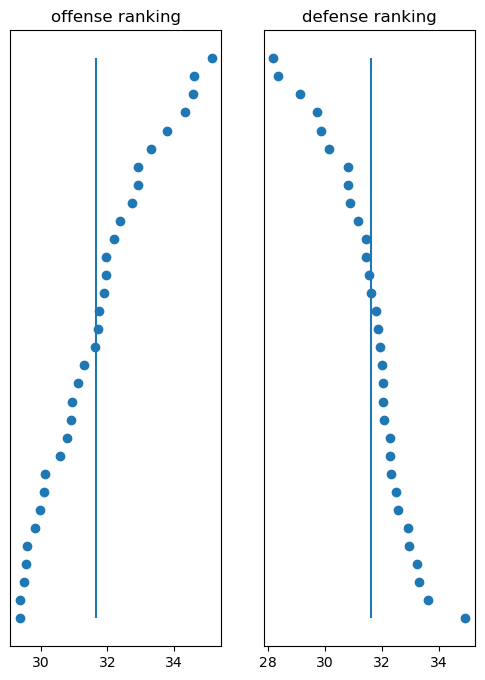

In [83]:
fig, ax = plt.subplots(1, 2, figsize=(6, 8))
ax[0].scatter(
    x=le_df.sort_values(
        "life_expectancy_offense", ascending=True
    ).life_expectancy_offense,
    y=np.arange(32),
)
ax[0].vlines([le_df.life_expectancy_offense.mean()], ymin=0, ymax=31)
ax[0].set_title("offense ranking")
ax[0].set_yticks([])

ax[1].scatter(
    x=le_df.sort_values(
        "life_expectancy_defense", ascending=False
    ).life_expectancy_defense,
    y=np.arange(32),
)
ax[1].vlines([le_df.life_expectancy_defense.mean()], ymin=0, ymax=31)
ax[1].set_title("defense ranking")
ax[1].set_yticks([])
plt.show()

### Looking at that table, we can see that the eagles have very good offensive and defensive lines in pass plays, as does cleveland. On the other hand, the Panthers have a good defensive line but an average offensive line. An interesting special case here are the Green Bay Packers. Their pass rush performns mostly worse than league average in long or short possessions, but around average in medium length plays, leading to a worse life expectancy but no significant different survival rate than league average in general.   

In [84]:
players_with_collapse = pd.merge(
    scouting[scouting.pff_role.isin(["Pass", "Pass Rush", "Pass Block"])][
        ["gameId", "playId", "nflId", "pff_role"]
    ],
    plays_with_collapse,
    how="right",
    on=["gameId", "playId"],
)

In [85]:
ple_qb = []
for plyr in tqdm(
    players_with_collapse[(players_with_collapse.pff_role == "Pass" ) & players_with_collapse.pass_frame.notna()].nflId.unique()
):
    tdf = players_with_collapse[
        (players_with_collapse.nflId == plyr) & players_with_collapse.pass_frame.notna()
    ]
    x, y, conf_int = kaplan_meier_estimator(
        (tdf.pass_frame < 0 ).to_numpy(),
        tdf.pass_frame.abs().to_numpy(),
        conf_type="log-log",
    )
    le = life_expectancy(x, y)
    ple_qb.append(
        {
            "nflId": plyr,
            "life expectancy": le,
            "num_snaps": tdf.shape[0],
            "team": tdf.possessionTeam.iat[0],
        }
    )

  0%|          | 0/60 [00:00<?, ?it/s]

In [86]:
qb_df = pd.DataFrame(ple_qb).merge(players, on="nflId")
qb_df[(qb_df.num_snaps > 50)].sort_values(
    "life expectancy", ascending=1
).head(60)

nflId  life expectancy  num_snaps team height  weight   birthDate  \
8   38632             57.0        245  MIN    6-3     202  1988-08-19   
26  52413             61.0        135  MIA    6-1     218  1998-03-02   
25  53444             62.0        275   NE    6-3     214        None   
30  47789             62.0        268  NYG    6-5     220  1997-05-27   
17  38538             63.0        267  TEN    6-4     207  1988-07-27   
38  53496             63.0        197  HOU    6-4     225        None   
1   43424             65.0        208  DAL    6-2     238  1993-07-29   
33  34452             66.0        240   LA    6-3     220  1988-02-07   
44  39987             66.0         96  SEA    6-3     221  1990-10-10   
0   25511             68.0        298   TB    6-4     225  1977-08-03   
10  43290             69.0        311  DET    6-4     223  1994-10-14   
2   33084             74.0        273  ATL    6-4     217  1985-05-17   
15  43291             74.0        239  IND    6-5     237  1992-12-30   
52  46240             75.0         74  NYJ    6-4     225  1995-03-25   
31  41258             76.0        254  DEN    6-2     215  1992-11-10   
34  41265             77.0        253   LV    6-3     210  1991-03-28   
37  53440             79.0        188  CHI    6-3     223        None   
7   46072             80.0        272  CAR    6-3     225  1997-06-05   
22  46070             80.0        201  CLE    6-1     215  1995-04-14   
9   52409             81.0        244  CIN    6-4     216  1996-12-10   
19  52414             81.0        259  LAC    6-6     237  1998-03-10   
11  41291             82.0        158   SF    6-2     225  1991-11-02   
16  38605             83.0        125  SEA   5-11     215  1988-11-29   
23  44822             86.0        315   KC    6-3     230  1995-09-17   
40  43380             87.0        161  MIA    6-4     235  1992-12-11   
3   52461             87.0        243  PHI    6-2     218  1998-08-07   
27  42344             87.0        164   NO    6-4     231  1994-01-06   
4   46076             91.0        244  BUF    6-5     237  1996-05-21   
14  53430             91.0        245  JAX    6-6     220        None   
12  53432             92.0         53   SF    6-4     226        None   
35  46101             93.0        254  BAL    6-2     212  1997-01-07   
28  29851             94.0        212   GB    6-2     225  1983-12-02   
5   28963             98.0        229  PIT    6-5     240  1982-03-02   
21  42831             98.0        277  WAS    6-1     210  03/15/1993   
18  47784             98.0        229  ARI   5-10     207  1997-08-07   
6   53431            101.0        185  NYJ    6-2     208        None   

             collegeName officialPosition         displayName  
8         Michigan State               QB        Kirk Cousins  
26               Alabama               QB      Tua Tagovailoa  
25                  None               QB           Mac Jones  
30                  Duke               QB        Daniel Jones  
17         Texas A&amp;M               QB      Ryan Tannehill  
38                  None               QB         Davis Mills  
1      Mississippi State               QB        Dak Prescott  
33               Georgia               QB    Matthew Stafford  
44         West Virginia               QB          Geno Smith  
0               Michigan               QB           Tom Brady  
10            California               QB          Jared Goff  
2         Boston College               QB           Matt Ryan  
15    North Dakota State               QB        Carson Wentz  
52      Western Kentucky               QB          Mike White  
31            Louisville               QB   Teddy Bridgewater  
34          Fresno State               QB          Derek Carr  
37                  None               QB       Justin Fields  
7    Southern California               QB         Sam Darnold  
22              Oklahoma               QB      Baker Mayfield  
9        Louisiana Sta

In [87]:
### QB throwing tendencies
qb_throw_times = players_with_collapse[players_with_collapse.pff_role=="Pass"].groupby("nflId").agg({"pass_frame":"mean", "playDescription":"count", "possessionTeam":"first"}).sort_values("pass_frame").merge(players[["nflId", "displayName"]], on="nflId").rename(columns={"playDescription":"num_snaps"})
qb_throw_times[qb_throw_times.num_snaps > 25]

nflId  pass_frame  num_snaps possessionTeam         displayName
4   28963   26.572052        229            PIT  Ben Roethlisberger
9   46240   27.418919         74            NYJ          Mike White
10  25511   27.714765        298             TB           Tom Brady
11  53444   28.007273        275             NE           Mac Jones
12  45536   28.086957         46            DAL         Cooper Rush
13  33084   28.267399        273            ATL           Matt Ryan
15  52413   28.888889        135            MIA      Tua Tagovailoa
17  38538   29.056180        267            TEN      Ryan Tannehill
18  37110   29.240000         50            CHI         Andy Dalton
19  52409   29.389344        244            CIN          Joe Burrow
20  47789   29.544776        268            NYG        Daniel Jones
21  34452   29.545833        240             LA    Matthew Stafford
22  38632   29.697959        245            MIN        Kirk Cousins
23  41291   29.772152        158             SF     Jimmy Garoppolo
24  52414   29.876448        259            LAC      Justin Herbert
25  41265   29.984190        253             LV          Derek Carr
26  38937   30.000000         29            CLE         Case Keenum
27  42593   30.000000         27             NO      Trevor Siemian
28  43424   30.024038        208            DAL        Dak Prescott
29  43290   30.392283        311            DET          Jared Goff
30  53496   30.406091        197            HOU         Davis Mills
33  41258   31.216535        254            DEN   Teddy Bridgewater
34  53430   31.726531        245            JAX     Trevor Lawrence
35  29851   31.773585        212             GB       Aaron Rodgers
36  46072   31.827206        272            CAR         Sam Darnold
38  37255   32.184211         38            HOU        Tyrod Taylor
39  46076   32.327869        244            BUF          Josh Allen
40  38605   32.328000        125            SEA      Russell Wilson
42  43380   32.366460        161            MIA     Jacoby Brissett
44  43291   32.836820        239            IND        Carson Wentz
45  53440   32.904255        188            CHI       Justin Fields
47  39987   33.156250         96            SEA          Geno Smith
48  46070   33.208955        201            CLE      Baker Mayfield
49  42831   33.335740        277            WAS     Taylor Heinicke
50  44822   33.526984        315             KC     Patrick Mahomes
52  47784   34.235808        229            ARI        Kyler Murray
53  42344   34.719512        164             NO      Jameis Winston
54  53431   34.972973        185            NYJ         Zach Wilson
55  46101   35.051181        254            BAL       Lamar Jackson
56  52461   35.728395        243            PHI         Jalen Hurts
58  53432   37.283019         53             SF          Trey Lance

In [88]:
ple_off = []
for plyr in tqdm(
    players_with_collapse[players_with_collapse.pff_role == "Pass Block"].nflId.unique()
):
    tdf = players_with_collapse[
        players_with_collapse.surv_frame.notna() & (players_with_collapse.nflId == plyr)
    ]
    x, y, conf_int = kaplan_meier_estimator(
        (tdf.poly_frame > -1).to_numpy(),
        tdf.surv_frame.to_numpy(),
        conf_type="log-log",
    )
    le = life_expectancy(x, y)
    ple_off.append(
        {
            "nflId": plyr,
            "life expectancy": le,
            "num_snaps": tdf.shape[0],
            "team": tdf.possessionTeam.iat[0],
        }
    )

  0%|          | 0/528 [00:00<?, ?it/s]

In [89]:
pb_df = pd.DataFrame(ple_off).merge(players, on="nflId")
pb_df[(pb_df.num_snaps > 50) & (pb_df.officialPosition == "C")].sort_values(
    "life expectancy", ascending=False
).head(5)

nflId  life expectancy  num_snaps team height  weight   birthDate  \
27   37266        35.135125        243  PHI    6-3     295  1987-11-05   
195  40070        34.569171        231  CLE    6-4     307  1991-02-12   
84   41619        34.516051        244  CIN    6-3     316  1992-07-06   
103  34472        34.252275        210   SF    6-4     311  1985-11-19   
306  46284        34.053377        247  BAL    6-5     317  1994-11-24   

    collegeName officialPosition      displayName  
27   Cincinnati                C      Jason Kelce  
195     Cornell                C     J.C. Tretter  
84        Texas                C     Trey Hopkins  
103  California                C        Alex Mack  
306     Alabama                C  Bradley Bozeman

In [90]:
pb_df[(pb_df.num_snaps > 50) & (pb_df.officialPosition == "G")].sort_values(
    "life expectancy", ascending=False
).head(5)

nflId  life expectancy  num_snaps team height  weight   birthDate  \
30   43368        37.052295         78  PHI    6-4     303  1993-10-29   
349  53466        34.760694        203  PHI    6-6     325        None   
85   43045        34.605525        246  CIN    6-4     330  1991-08-07   
198  46235        34.569171        231  CLE    6-4     315  1994-11-21   
196  41264        34.569171        231  CLE    6-4     320  1991-10-11   

       collegeName officialPosition       displayName  
30    Oregon State                G     Isaac Seumalo  
349           None                G  Landon Dickerson  
85   West Virginia                G     Quinton Spain  
198  Virginia Tech                G      Wyatt Teller  
196         Nevada                G      Joel Bitonio

In [91]:
pb_df[(pb_df.num_snaps > 50) & (pb_df.officialPosition == "T")].sort_values(
    "life expectancy", ascending=False
).head(5)

nflId  life expectancy  num_snaps team height  weight   birthDate  \
29   39950        38.404533        126  PHI    6-6     317  1990-05-08   
197  43297        35.754130        144  CLE    6-6     308  1994-08-17   
31   46302        35.265444        165  PHI    6-8     344  1997-03-31   
104  35443        34.863467        170   SF    6-5     320  1988-07-19   
86   47794        34.605525        246  CIN    6-4     305  1997-11-17   

        collegeName officialPosition     displayName  
29         Oklahoma                T    Lane Johnson  
197  Michigan State                T    Jack Conklin  
31       No College                T  Jordan Mailata  
104        Oklahoma                T  Trent Williams  
86          Alabama                T  Jonah Williams

#### looking at these player rankings, we can see that some expected names (Jason Kelce, Trent Williams, Alejandro Villanueva, Joel Bitonio) show up but also some unexpected names like Landon Dickerson and Sam Cosmi. A similar ranking (grouped by position) can now be created for the defensive positions. 

In [92]:
ple_def = []
for plyr in tqdm(
    players_with_collapse[players_with_collapse.pff_role == "Pass Rush"].nflId.unique()
):
    tdf = players_with_collapse[
        players_with_collapse.surv_frame.notna()
        & (players_with_collapse.nflId == plyr)
        & (players_with_collapse.pff_role == "Pass Rush")
    ]
    x, y, conf_int = kaplan_meier_estimator(
        (tdf.poly_frame > -1).to_numpy(),
        tdf.surv_frame.to_numpy(),
        conf_type="log-log",
    )
    le = life_expectancy(x, y)
    ple_def.append(
        {
            "nflId": plyr,
            "life expectancy": le,
            "num_snaps": tdf.shape[0],
            "team": tdf.defensiveTeam.iat[0],
        }
    )

  0%|          | 0/692 [00:00<?, ?it/s]

In [93]:
pr_df = pd.DataFrame(ple_def).merge(players, on="nflId")
pr_df[(pr_df.num_snaps > 50) & (pr_df.officialPosition == "DE")].sort_values(
    "life expectancy"
).head(5)

nflId  life expectancy  num_snaps team height  weight   birthDate  \
90  52446        25.286761         51  CAR    6-5     264  1998-02-26   
33  44826        27.494407        155  PHI    6-3     259  1996-06-25   
80  47799        27.719098        195  CAR    6-5     250  1998-04-23   
79  43791        27.770828        140  CAR    6-3     275  1994-09-12   
34  37089        27.870959         86  PHI    6-4     265  1988-08-16   

              collegeName officialPosition        displayName  
90             Penn State               DE  Yetur Gross-Matos  
33              Tennessee               DE      Derek Barnett  
80          Florida State               DE        Brian Burns  
79  Colorado State-Pueblo               DE         Morgan Fox  
34                 Purdue               DE      Ryan Kerrigan

In [94]:
pr_df[(pr_df.num_snaps > 50) & (pr_df.officialPosition == "DT")].sort_values(
    "life expectancy"
).head(5)

nflId  life expectancy  num_snaps team height  weight   birthDate  \
312  46307        27.188329         86  MIA    6-6     290  1995-09-07   
81   52415        27.364482        152  CAR    6-5     318  1998-04-15   
31   38542        27.450804        173  PHI    6-4     310  1990-12-13   
173  52481        27.508067         57  JAX    6-4     310  1997-02-01   
32   43378        27.784866        165  PHI    6-2     305  1993-02-07   

              collegeName officialPosition     displayName  
312          Ferris State               DT     Zach Sieler  
81                 Auburn               DT   Derrick Brown  
31      Mississippi State               DT    Fletcher Cox  
173            Ohio State               DT  Davon Hamilton  
32   South Carolina State               DT  Javon Hargrave

In [95]:
pr_df[(pr_df.num_snaps > 50) & (pr_df.officialPosition == "NT")].sort_values(
    "life expectancy"
).head(5)

nflId  life expectancy  num_snaps team height  weight   birthDate  \
92   47786        28.547700        148  NYJ    6-3     303  1997-12-21   
8    46081        28.957868        190   TB    6-4     347  1995-02-05   
567  42382        29.080525         56  CHI    6-3     320  1994-01-06   
301  52464        29.305710         54  MIA    6-7     310        None   
308  40030        29.525594         51  MIA    6-3     327  1989-07-11   

       collegeName officialPosition       displayName  
92         Alabama               NT  Quinnen Williams  
8       Washington               NT          Vita Vea  
567  Florida State               NT     Eddie Goldman  
301        Alabama               NT     Raekwon Davis  
308        Georgia               NT      John Jenkins

# Comparison with pff grades 

In [96]:
import plotly.express as px

In [97]:
pff_pr_df = pd.read_csv("pass_rush_summary.csv")

In [98]:
pff_pb_df = pd.read_csv("offense_pass_blocking.csv")

In [99]:
pr_comp = pff_pr_df.merge(pr_df, how="inner", left_on="player", right_on="displayName")
print(pr_comp.shape)
pb_comp = pff_pb_df.merge(pb_df, how="inner", left_on="player", right_on="displayName")
print(pb_comp.shape)

(633, 44)
(496, 40)


In [100]:
pr_comp.columns

Index(['player', 'player_id', 'position', 'team_name', 'player_game_count',
       'batted_passes', 'declined_penalties', 'franchise_id',
       'grades_pass_rush_defense', 'hits', 'hurries', 'pass_rush_opp',
       'pass_rush_percent', 'pass_rush_win_rate', 'pass_rush_wins',
       'penalties', 'prp', 'sacks', 'snap_counts_pass_play',
       'snap_counts_pass_rush', 'total_pressures',
       'true_pass_set_batted_passes', 'true_pass_set_grades_pass_rush_defense',
       'true_pass_set_hits', 'true_pass_set_hurries',
       'true_pass_set_pass_rush_opp', 'true_pass_set_pass_rush_percent',
       'true_pass_set_pass_rush_win_rate', 'true_pass_set_pass_rush_wins',
       'true_pass_set_prp', 'true_pass_set_sacks',
       'true_pass_set_snap_counts_pass_play',
       'true_pass_set_snap_counts_pass_rush', 'true_pass_set_total_pressures',
       'nflId', 'life expectancy', 'num_snaps', 'team', 'height', 'weight',
       'birthDate', 'collegeName', 'officialPosition', 'displayName'],
      

In [101]:
pb_comp.columns

Index(['player', 'player_id', 'position', 'team_name', 'player_game_count',
       'declined_penalties', 'franchise_id', 'grades_pass_block',
       'hits_allowed', 'hurries_allowed', 'non_spike_pass_block',
       'non_spike_pass_block_percentage', 'pass_block_percent', 'pbe',
       'penalties', 'pressures_allowed', 'sacks_allowed',
       'snap_counts_pass_block', 'snap_counts_pass_play',
       'true_pass_set_grades_pass_block', 'true_pass_set_hits_allowed',
       'true_pass_set_hurries_allowed', 'true_pass_set_non_spike_pass_block',
       'true_pass_set_non_spike_pass_block_percentage',
       'true_pass_set_pass_block_percent', 'true_pass_set_pbe',
       'true_pass_set_pressures_allowed', 'true_pass_set_sacks_allowed',
       'true_pass_set_snap_counts_pass_block',
       'true_pass_set_snap_counts_pass_play', 'nflId', 'life expectancy',
       'num_snaps', 'team', 'height', 'weight', 'birthDate', 'collegeName',
       'officialPosition', 'displayName'],
      dtype='object')

In [102]:
px.scatter(
    pr_comp[pr_comp.num_snaps > 50],
    x="life expectancy",
    y="grades_pass_rush_defense",
    size="num_snaps",
    hover_data=["num_snaps", "player", "position", "team_name"],
    height=800,
    title="pass rush grades vs life expectancy (at least 50 snaps), size is num of snaps",
    trendline="ols",
)

#### the visualization of defensive life expectancy vs pass rush grades shows a trend with a slight negative correlation. We can especially identify some special cases: Devin White, by far the lowest life expectancy, is a LB which means if he is rushing, it is probably a blitz. This makes sense then that his pass rushing leads to faster pocket collapse but he is not a elite pass rusher. on the other hand, Trevis gipson, a Bears EDGE, hasa a good grade but does not seem to collapse the pocket quickly, which might be due to him being on one of the worse pass rushing teams. Also we can identify elite pass rushers in the top left (high grade, low enemy pocket life expectancy). This group consists of Micah Parsons, Myles Garret, Aaron Donald and Javon Hargrave, some of the most well regarded pass rushers. It has to be noted on the defensive end however, that our approach currently does not correct for number of snaps played or type of plays a player takes part in. This means that a lot of pass rushing succes of a LB might be due to them being part of high pressure calls where they would otherwise not pass rush but rather defend a receiver. On the other hand, a NT will almost always be pass rushing, (one need only think of 3rd and long situations, with only 1-3 rushers going up against a full front 5, thus having much more trouble to collapse the pocket) this is reflected in the pocket collapse outcomes, leading to low correlation between grades and our metric. 

In [103]:
px.scatter(
    pb_comp[pb_comp.num_snaps > 50],
    x="life expectancy",
    y="grades_pass_block",
    hover_data=["player", "position", "team_name", "num_snaps"],
    height=800,
    title="pass block grades vs life expectancy (at least 50 snaps)",
    trendline="ols",
)

#### visualizing the player grades assigned by pff, we can se a moderate correlation for offensive players, there are some with high life expectancy but lower grades  (josh jones, daniel brunskill which might be weaker players on otherwise good lines, incidentally arz and sf are among the top 5 life expectancies) where as the opposite case, high grade and low life expectancy, kevin dotson and jake matthews are both from bottom 3 offensive lines, suggesting their individual play might have been solid but they could not make up for an overall bad line or play calling. Conversely, top players like jc tretter and joel bitonio are also among the players with the highest life expectancies, and alex leatherwood and jalen mayfield have very bad grades and among the worst life expectancies.

## life expectancy relative to team performance.

#### as just argued, life expectancy is somewhat of a team dependand stat 

In [104]:
pr_comp = pr_comp.merge(le_df, how="inner", left_on="team_name", right_on="team")
pr_comp["team_rel_le"] = pr_comp["life expectancy"] - pr_comp["life_expectancy_defense"]
print(pr_comp.shape)
pb_comp = pb_comp.merge(le_df, how="inner", left_on="team_name", right_on="team")
pb_comp["team_rel_le"] = pb_comp["life expectancy"] - pb_comp["life_expectancy_offense"]
print(pb_comp.shape)

(547, 52)
(430, 48)


In [105]:
team = "PHI"
pb_comp.loc[
    (pb_comp.team_name == team) & (pb_comp.num_snaps > 15),
    ["nflId", "player", "position", "num_snaps", "life expectancy", "team_rel_le", "grades_pass_block"],
].sort_values("team_rel_le").merge(
    players_with_collapse.loc[
        (players_with_collapse["possessionTeam"] == team)
        & (players_with_collapse.pff_role == "Pass Block"),
        ["nflId", "prePenaltyPlayResult", "defendersInBox"],
    ]
    .groupby("nflId")
    .mean()
    .reset_index(),
    on="nflId",
    how="left",
)

nflId            player position  num_snaps  life expectancy  team_rel_le  \
0  47836     Miles Sanders       HB         20        26.361422    -8.773703   
1  52553     Jack Driscoll        G        144        31.991615    -3.143511   
2  47805     Andre Dillard        T        151        32.372792    -2.762333   
3  48513       Nate Herbig        G         67        33.809989    -1.325137   
4  53466  Landon Dickerson        G        203        34.760694    -0.374432   
5  37266       Jason Kelce        C        243        35.135125     0.000000   
6  46302    Jordan Mailata        T        165        35.265444     0.130319   
7  38606    Brandon Brooks        G         38        35.473556     0.338430   
8  43368     Isaac Seumalo        G         78        37.052295     1.917170   
9  39950      Lane Johnson        T        126        38.404533     3.269408   

   grades_pass_block  prePenaltyPlayResult  defendersInBox  
0               46.0              4.150000        6.300000  
1               73.9              5.722222        5.854167  
2               71.7              5.947020        6.013245  
3               63.9              7.611940        6.238806  
4               57.1              6.709360        6.000000  
5               67.7              6.786008        5.991770  
6               83.3              6.745455        5.896970  
7               62.8              7.026316        5.921053  
8               82.9              7.705128        6.115385  
9               81.2              8.103175        6.047619

### connecting to the earlier analysis (for PHI, each extra survived frame for the pocket we expect an extra half a yard gained and 0.064 epa gained), with the eagles as a nice team because they rotate their OL presonel allowing us to have several players with a good sample of sanps played. Here we can see that the extra 2.4 frames in life expectancy when Lane Johnson plays over Jordan Mailata translates to about 1.3 more yards, and the the extra 4.7 frames between Lane Johnson and Andre Dillard leads to an extra 2.5 yards gained before penalties. An intersting exception here is Nate Herbig, who has a below average life expectancy but a higher expected yards gained per play than Dickerson, Kelce and Mailata however in his 68 Snaps he also played on average against 0.3-0.5 more pass rushers per play, suggesting that in his case the defense was bringing pressure and while that lead to a quicker pocket collapse, the pocket held long enough for Hurts to make a good play.  

In [106]:
px.scatter(
    pr_comp[pr_comp.num_snaps > 50],
    x="team_rel_le",
    y="grades_pass_rush_defense",
    size="num_snaps",
    hover_data=["num_snaps", "player", "position", "team_name"],
    height=800,
    title="pass rush grades vs team relative life expectancy (at least 50 snaps), size is num of snaps",
    trendline="ols",
)

### looking at team relative life expectancy vs pass rush grades gives another perspective, which is which players improve their teams time to collapse the pocket. Again, Micah parsons is one of the top players, however many of the better known pass rushers like aaron donald, maxx crosby and chris jones tend to play a lot of snaps (239 for AD vs Micahs 96, so it is more difficult to perform better than the team average, if you play almost every snap). interesting here are trevis gipson with a top grade but leading to a longer pocket life expectancy on one hand and devin white, with a average grade but a massive -4.6 frames quicker pocket collapse on the 69 snaps he's played on compared to team average.  

In [107]:
px.scatter(
    pb_comp[pb_comp.num_snaps > 50],
    x="team_rel_le",
    y="grades_pass_block",
    size="num_snaps",
    hover_data=["num_snaps", "player", "position", "team_name"],
    height=800,
    title="team relative pass block grades vs life expectancy (at least 50 snaps)",
    trendline="ols",
)

#### for offensive lines, much more so than defensive players, there are a lot of players who just play (almost) every snap. This means on one hand, that the performance of the team is more reflective of team success / play calling and formation does not play as much of a role as for defensive players but also it is more difficult to assign credit or blame to individual players. however, we have some interesting special cases here. Lane Johnson and Isaac Seumalo are providing massive value to the Eagles front when they play, which is also reflected in their grade, however jack driscoll and andre dillard pay the price in terms of life expectancy when they have to fill in.elijah wilkinson was only playing 52 snaps, and didn't achieve average performance in terms of pff grading, but during his snaps the line held up 1.74 frames longer on average, which is good for third behind the two eagles players. 

## pff grades related to other features

In [108]:
players_with_collapse.columns

Index(['gameId', 'playId', 'nflId', 'pff_role', 'mean_polydists',
       'playDescription', 'pff_playAction', 'passResult',
       'prePenaltyPlayResult', 'defendersInBox', 'personnelO', 'personnelD',
       'dropBackType', 'pff_passCoverage', 'pff_passCoverageType',
       'offenseFormation', 'yardsToGo', 'down', 'possessionTeam',
       'defensiveTeam', 'ep', 'epa', 'qb_epa', 'touchdown', 'air_yards',
       'complete', 'incomplete', 'sack', 'pass_absolute_frame', 'min_frame',
       'poly_frame', 'surv_frame', 'pass_frame', 'frameId', 'polydist',
       'qb_radius', 'p_blockwin', 'max_frame', 'survived', 'pass_thrown',
       'pocket_end_event', 'pocket_end', 'pocket_vol', 'down1', 'down2',
       'down3', 'zone', 'man', 'Cover-3', 'Cover-1', 'Cover-2', 'Quarters',
       'Cover-6', 'RedZone', 'Cover-0', '2-Man', 'shotgun', 'empty',
       'singleback', 'iform', 'comp_air_yards', 'safe_pass'],
      dtype='object')

In [109]:
mean_stuff = players_with_collapse.groupby("nflId").agg({
        "sack":"mean",
        "complete":"mean",
        "epa":"mean",
        "polydist":"mean",
        "mean_polydists":"mean",
        "surv_frame":"mean",
        "pocket_vol":"mean",
        "prePenaltyPlayResult":"mean",
        "air_yards":"mean",
        "comp_air_yards":"mean",
        "p_blockwin":"mean",
    "playDescription":"count"}).reset_index().rename(columns={"playDescription":"num_snaps"}).sort_values(["mean_polydists", "num_snaps"])

In [110]:
mean_stuff = mean_stuff.merge(players[players.officialPosition != "QB"], on="nflId", how="left")

In [111]:
off_comp = pd.merge(mean_stuff, pff_pb_df, how="inner", left_on="displayName", right_on="player")
off_comp = pd.merge(off_comp, pb_df[["nflId", "life expectancy"]], on="nflId")
print(off_comp.shape)
def_comp = pd.merge(mean_stuff, pff_pr_df, how="inner", left_on="displayName", right_on="player")
def_comp = pd.merge(def_comp, pr_df[["nflId", "life expectancy"]], on="nflId")
print(def_comp.shape)

(495, 50)
(633, 54)


In [112]:
off_comp["norm_grades"] = (off_comp["grades_pass_block"] - off_comp["grades_pass_block"].mean())/off_comp["grades_pass_block"].std()
def_comp["norm_grades"] = (def_comp["grades_pass_rush_defense"] - def_comp["grades_pass_rush_defense"].mean())/def_comp["grades_pass_rush_defense"].std()

## comparing the correlations of pff grades with common performance indicators (i.e. targets from earlier)

#### when looking at the correlations betwenn offensive play results and life expectancy and pass blocking grades, we can see that life expectancy is clearly more correlated to measures of play outcome. This suggests that life expectancy is a better measure of pass protection than pass blocking grade. on the other hand, defense seems a more tricky topic, as it is difficult to for a single measure to account for the different dynamics in formation and playcalling. _Given the metric is a good measurement of offensive protection, it is initself valuable to know, which player is able to interfere with the protection capabilities the most_ 

In [113]:
oc = off_comp.loc[
    off_comp.num_snaps > 20,
    [
        "sack",
        "complete",
        "epa",
        "prePenaltyPlayResult",
        "air_yards",
        "comp_air_yards",
        "p_blockwin",
        "mean_polydists",
        "surv_frame",
        "pocket_vol",
        "life expectancy",
        "grades_pass_block",
    ],
].corr()[["life expectancy", "grades_pass_block", "mean_polydists", "pocket_vol"]]
oc["max_corr"] = oc.abs().idxmax(axis=1)
oc

life expectancy  grades_pass_block  mean_polydists  \
sack                        -0.220535          -0.126947       -0.109458   
complete                    -0.056063           0.023913       -0.016737   
epa                          0.135003           0.031743        0.083857   
prePenaltyPlayResult         0.295979           0.036977        0.100162   
air_yards                    0.295122           0.008741        0.077316   
comp_air_yards               0.141922          -0.080940       -0.004534   
p_blockwin                   0.685656           0.205450        0.388583   
mean_polydists               0.497853           0.287790        1.000000   
surv_frame                   0.761226           0.190543        0.318601   
pocket_vol                   0.734139           0.287820        0.854939   
life expectancy              1.000000           0.354580        0.497853   
grades_pass_block            0.354580           1.000000        0.287790   

                      pocket_vol           max_corr  
sack                   -0.131269    life expectancy  
complete               -0.149589         pocket_vol  
epa                     0.138531         pocket_vol  
prePenaltyPlayResult    0.266765    life expectancy  
air_yards               0.384283         pocket_vol  
comp_air_yards          0.189719         pocket_vol  
p_blockwin              0.606685    life expectancy  
mean_polydists          0.854939     mean_polydists  
surv_frame              0.748207    life expectancy  
pocket_vol              1.000000         pocket_vol  
life expectancy         0.734139    life expectancy  
grades_pass_block       0.287820  grades_pass_block

In [114]:
dc = def_comp.loc[
    def_comp.num_snaps > 20,
    [
        "sack",
        "hurries", 
        "hits",
        "pass_rush_win_rate",
        "complete",
        "epa",
        "prePenaltyPlayResult",
        "air_yards",
        "p_blockwin",
        "comp_air_yards",
        "mean_polydists",
        "surv_frame",
        "pocket_vol",
        "life expectancy",
        "grades_pass_rush_defense",
    ],
].corr()[["life expectancy", "grades_pass_rush_defense", "mean_polydists", "pocket_vol"]]
dc["max_corr"] = dc.abs().idxmax(axis=1)
dc

life expectancy  grades_pass_rush_defense  \
sack                            -0.295760                  0.193810   
hurries                          0.156173                  0.613237   
hits                             0.105928                  0.536811   
pass_rush_win_rate              -0.081931                  0.850083   
complete                         0.163089                 -0.136693   
epa                              0.019855                 -0.120400   
prePenaltyPlayResult             0.150044                 -0.153127   
air_yards                        0.050873                 -0.032492   
p_blockwin                       0.772697                 -0.102211   
comp_air_yards                  -0.065511                 -0.012165   
mean_polydists                   0.550174                 -0.111079   
surv_frame                       0.861957                 -0.165389   
pocket_vol                       0.801713                 -0.163569   
life expectancy                  1.000000                 -0.084016   
grades_pass_rush_defense        -0.084016                  1.000000   

                          mean_polydists  pocket_vol                  max_corr  
sack                           -0.186982   -0.250137           life expectancy  
hurries                         0.063012    0.014210  grades_pass_rush_defense  
hits                            0.023271   -0.033121  grades_pass_rush_defense  
pass_rush_win_rate             -0.040713   -0.109158  grades_pass_rush_defense  
complete                        0.070775    0.102203           life expectancy  
epa                            -0.042903    0.018796  grades_pass_rush_defense  
prePenaltyPlayResult            0.034555    0.133344  grades_pass_rush_defense  
air_yards                      -0.040847    0.113295                pocket_vol  
p_blockwin                      0.613185    0.778219                pocket_vol  
comp_air_yards                 -0.082353   -0.034449            mean_polydists  
mean_polydists                  1.000000    0.865645            mean_polydists  
surv_frame                      0.589848    0.899321                pocket_vol  
pocket_vol                      0.865645    1.000000                pocket_vol  
life expectancy                 0.550174    0.801713           life expectancy  
grades_pass_rush_defense       -0.111079   -0.163569  grades_pass_rush_defense

## we can se here, that an increase in life expectancy of 2 frames means practically for the average offense: 0.5% less likely to result  in a sack, 0.05 higher epa on average, 

In [115]:
px.scatter(
    off_comp[off_comp.num_snaps > 130],
    x="life expectancy",
    y=["epa", "complete", "sack"],
    hover_data=["player", "position", "team_name", "num_snaps"],
    height=800,
    title="pass block grades vs mean poly dists (at least 50 snaps)",
    trendline="ols",
)

In [116]:
off_comp["norm_le"] = off_comp["life expectancy"]-off_comp["life expectancy"].min()
off_comp["norm_le"] = off_comp["norm_le"] / off_comp["norm_le"].max()

off_comp["minmax_grades"] = off_comp["grades_pass_block"]-off_comp["grades_pass_block"].min()
off_comp["minmax_grades"] = off_comp["minmax_grades"] / off_comp["minmax_grades"].max()
px.scatter(
    off_comp[off_comp.num_snaps > 50],
    x=["norm_le", "minmax_grades"],
    y="epa",
    hover_data=["player", "position", "team_name", "num_snaps"],
    height=800,
    title="pass block grades vs mean poly dists (at least 50 snaps)",
    trendline="ols",
)
    

In [117]:
px.scatter(
    off_comp[off_comp.num_snaps > 50],
    x="surv_frame",    
    y="grades_pass_block",
    hover_data=["player", "position", "team_name", "num_snaps"],
    height=800,
    title="pass block grades vs mean cpocket volume (at least 50 snaps)",
    trendline="ols",
)

In [118]:
px.scatter(
    off_comp[off_comp.num_snaps > 50],
    x="pocket_vol",
    y="grades_pass_block",
    hover_data=["player", "position", "team_name", "num_snaps"],
    height=800,
    title="pass block grades vs mean cpocket volume (at least 50 snaps)",
    trendline="ols",
)

In [119]:
px.scatter(
    off_comp[off_comp.num_snaps > 50],
    x="p_blockwin",    
    y="grades_pass_block",
    hover_data=["player", "position", "team_name", "num_snaps"],
    height=800,
    title="pass block grades vs mean cpocket volume (at least 50 snaps)",
    trendline="ols",
)

In [120]:
px.scatter(
    off_comp[off_comp.num_snaps > 50],
    x="p_blockwin",    
    y="pressures_allowed",
    hover_data=["player", "position", "team_name", "num_snaps"],
    height=800,
    title="pass block grades vs mean cpocket volume (at least 50 snaps)",
    trendline="ols",
)

## defense 

In [121]:
px.scatter(
    def_comp[def_comp.num_snaps > 50],
    x="mean_polydists",
    y="grades_pass_rush_defense",
    hover_data=["player", "position", "team_name", "num_snaps"],
    height=800,
    title="pass block grades vs mean poly dists (at least 50 snaps)",
    trendline="ols",
)

In [122]:
px.scatter(
    def_comp[def_comp.num_snaps > 50],
    x="surv_frame",    
    y="grades_pass_rush_defense",
    hover_data=["player", "position", "team_name", "num_snaps"],
    height=800,
    title="pass block grades vs mean cpocket volume (at least 50 snaps)",
    trendline="ols",
)

In [123]:
px.scatter(
    def_comp[def_comp.num_snaps > 50],
    x="pocket_vol",    
    y="grades_pass_rush_defense",
    hover_data=["player", "position", "team_name", "num_snaps"],
    height=800,
    title="pass block grades vs mean cpocket volume (at least 50 snaps)",
    trendline="ols",
)

In [124]:
px.scatter(
    def_comp[def_comp.num_snaps > 50],
    x="p_blockwin",
    y="grades_pass_rush_defense",
    hover_data=["player", "position", "team_name", "num_snaps"],
    height=800,
    title="pass block grades vs mean cpocket volume (at least 50 snaps)",
    trendline="ols",
)

In [125]:
def_comp.columns

Index(['nflId', 'sack', 'complete', 'epa', 'polydist', 'mean_polydists',
       'surv_frame', 'pocket_vol', 'prePenaltyPlayResult', 'air_yards',
       'comp_air_yards', 'p_blockwin', 'num_snaps', 'height', 'weight',
       'birthDate', 'collegeName', 'officialPosition', 'displayName', 'player',
       'player_id', 'position', 'team_name', 'player_game_count',
       'batted_passes', 'declined_penalties', 'franchise_id',
       'grades_pass_rush_defense', 'hits', 'hurries', 'pass_rush_opp',
       'pass_rush_percent', 'pass_rush_win_rate', 'pass_rush_wins',
       'penalties', 'prp', 'sacks', 'snap_counts_pass_play',
       'snap_counts_pass_rush', 'total_pressures',
       'true_pass_set_batted_passes', 'true_pass_set_grades_pass_rush_defense',
       'true_pass_set_hits', 'true_pass_set_hurries',
       'true_pass_set_pass_rush_opp', 'true_pass_set_pass_rush_percent',
       'true_pass_set_pass_rush_win_rate', 'true_pass_set_pass_rush_wins',
       'true_pass_set_prp', 'true_pass_set

In [126]:
px.scatter(
    def_comp[def_comp.num_snaps > 50],
    x="p_blockwin",
    y="pass_rush_win_rate",
    hover_data=["player", "position", "team_name", "num_snaps"],
    height=800,
    title="pass block grades vs mean pocket volume (at least 50 snaps)",
    trendline="ols",
)

In [127]:
plays_with_collapse.groupby("possessionTeam")[["mean_polydists", "polydist", "pocket_vol"]].mean().sort_values("mean_polydists")

mean_polydists  polydist  pocket_vol
possessionTeam                                      
MIN                   2.343423  0.995599   66.553363
DEN                   2.517115  1.065759   74.042237
ATL                   2.558250  1.002531   69.895176
SEA                   2.600390  1.084212   73.082185
JAX                   2.607585  0.946876   73.865770
DET                   2.613690  0.949058   75.073529
TEN                   2.615677  1.229528   74.209826
LAC                   2.616391  1.149937   72.501957
LV                    2.628096  0.968208   73.671425
NYJ                   2.628662  1.183157   74.950358
IND                   2.645995  0.962736   77.415129
HOU                   2.663734  1.196924   72.408794
DAL                   2.664904  1.170331   75.827879
CAR                   2.675107  1.033444   76.974419
NE                    2.675647  1.191227   73.502606
CIN                   2.711971  1.216131   76.107435
CHI                   2.714091  1.290902   78.572060
WAS                   2.741191  1.202561   82.533475
MIA                   2.759100  1.072046   75.483938
SF                    2.789223  1.403013   81.046435
NYG                   2.793056  1.135833   78.351115
PHI                   2.795686  1.126025   86.765611
NO                    2.804720  1.146832   85.371730
GB                    2.807185  1.518202   81.307434
BUF                   2.826517  0.970773   81.248234
CLE                   2.894205  1.611178   87.465802
KC                    2.917417  1.215797   83.599649
LA                    2.980088  1.240672   87.492312
ARI                   3.041942  1.391573   91.293565
TB                    3.071593  1.354122   86.062930
BAL                   3.132546  1.314508   96.106823
PIT                   3.163252  1.365079   82.912982

In [128]:
plays_with_collapse.groupby("possessionTeam")[["surv_frame", "mean_polydists", "polydist", "pocket_vol", "epa", "prePenaltyPlayResult"]].mean().sort_values("mean_polydists").corr()


surv_frame  mean_polydists  polydist  pocket_vol  \
surv_frame              1.000000        0.297674  0.290026    0.697842   
mean_polydists          0.297674        1.000000  0.624772    0.884464   
polydist                0.290026        0.624772  1.000000    0.591547   
pocket_vol              0.697842        0.884464  0.591547    1.000000   
epa                     0.210267        0.339606  0.196506    0.353851   
prePenaltyPlayResult    0.232224        0.327117  0.238591    0.368983   

                           epa  prePenaltyPlayResult  
surv_frame            0.210267              0.232224  
mean_polydists        0.339606              0.327117  
polydist              0.196506              0.238591  
pocket_vol            0.353851              0.368983  
epa                   1.000000              0.903252  
prePenaltyPlayResult  0.903252              1.000000

In [129]:

plays_with_collapse.groupby("defensiveTeam")[["mean_polydists", "polydist", "pocket_vol", "epa", "prePenaltyPlayResult"]].mean().sort_values("mean_polydists")

mean_polydists  polydist  pocket_vol       epa  \
defensiveTeam                                                   
CAR                  2.546456  1.057744   68.491611 -0.023131   
PHI                  2.547152  0.954597   68.737423  0.045084   
NYJ                  2.590952  1.180286   72.345058  0.227041   
CLE                  2.620001  0.935399   71.339878  0.236870   
MIA                  2.644993  0.962653   73.234868  0.339739   
BAL                  2.657475  1.115436   74.201474  0.128634   
WAS                  2.678469  1.060030   74.039043  0.334225   
HOU                  2.685622  1.082452   78.981093  0.237810   
TB                   2.709252  1.150029   75.406166 -0.002805   
LV                   2.709570  1.096189   78.140239  0.120827   
IND                  2.712177  1.348629   78.096329  0.173144   
JAX                  2.744079  1.303976   80.004670  0.336257   
BUF                  2.745762  1.130329   78.599202 -0.163394   
TEN                  2.753662  1.132047   78.742969  0.032294   
MIN                  2.758647  1.111730   80.796825 -0.078481   
DAL                  2.764082  1.248206   77.873989 -0.025184   
DET                  2.773700  1.234581   84.253624  0.443237   
SEA                  2.774508  1.202511   80.092279  0.204486   
LA                   2.776305  1.080907   77.645652  0.052102   
LAC                  2.785601  1.084096   81.824945  0.070143   
PIT                  2.791515  1.167832   77.591949  0.113032   
KC                   2.797076  1.151863   80.385019  0.208840   
SF                   2.800057  1.200083   81.688552  0.262684   
CHI                  2.801088  1.275429   81.048908  0.122115   
NE                   2.802040  1.295187   83.442264  0.036428   
CIN                  2.819067  1.215939   81.680095  0.041099   
NO                   2.827512  1.339338   84.524128 -0.032833   
ATL                  2.847733  1.224683   84.243486  0.250410   
NYG                  2.850076  1.283449   84.993423  0.123400   
GB                   2.859725  1.222019   84.848999  0.151155   
ARI                  2.888719  1.419759   82.985053 -0.058592   
DEN                  2.909224  1.255114   84.782308  0.114453   

               prePenaltyPlayResult  
defensiveTeam                        
CAR                        5.719368  
PHI                        6.638554  
NYJ                        6.687500  
CLE                        6.076923  
MIA                        7.498246  
BAL                        7.084677  
WAS                        7.432787  
HOU                        7.666667  
TB                         5.724684  
LV                         5.862069  
IND                        7.278626  
JAX                        7.868545  
BUF                        4.570833  
TEN                        5.870748  
MIN                        6.025000  
DAL                        7.078740  
DET                        8.625000  
SEA                        6.744898  
LA                         6.092105  
LAC                        6.000000  
PIT                        6.595745  
KC                         7.322709  
SF                         6.306306  
CHI                        6.683983  
NE                         6.342007  
CIN                        6.479751  
NO                         6.682171  
ATL                        7.000000  
NYG                        6.352727  
GB                         6.222642  
ARI                        5.938776  
DEN                        6.638554

# Survival analysis and Life Expectancy using Cox Proportional Hazard 

#### We use Cox PH for two different reasons here: 
* modeling life expectancy based on game situation (i.e. which team is playing, is it play action?)
* we have at least two different time-to-events we are modeling: time-to-collapse and time-to-pass which are influencing each other on occurance

In order to achieve this, we use lifelines. here we first standardize the some features and we use the survival frames as target duration

### Optionally: fit the pocket size over time to create additional features. they might be leaking information though. 

In [130]:
from scipy.optimize import curve_fit

In [131]:
def decay_func(x, amplitude, slope, x_inter, y_inter): 
    return -amplitude / (1+np.exp(-slope * (x - x_inter))) + y_inter

In [132]:
curve_fit(decay_func, np.arange(len(radii)), radii, p0 = (5, 0.5, 20, 5))

(array([ 4.76107513,  0.34842735, 23.09497652,  4.92017095]),
 array([[ 0.01796739, -0.00300866,  0.00652713,  0.0071638 ],
        [-0.00300866,  0.0011494 , -0.00105802, -0.00120934],
        [ 0.00652713, -0.00105802,  0.09786221, -0.00820214],
        [ 0.0071638 , -0.00120934, -0.00820214,  0.00584917]]))

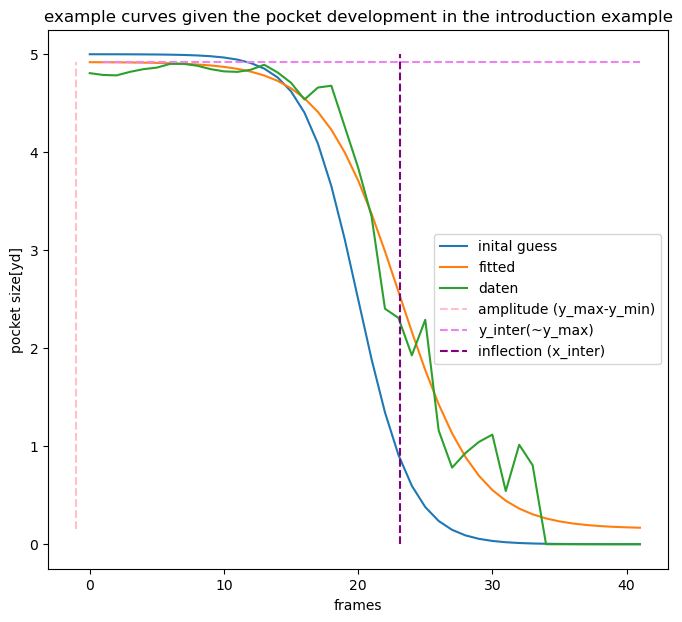

In [133]:
plt.figure(figsize=(8, 7))
plt.plot(np.arange(0,42), decay_func(np.arange(0,42), 5, 0.5, 20, 5), label="inital guess")
plt.plot(np.arange(0,42), decay_func(np.arange(0,42), 4.76107513,  0.34842735, 23.09497652,  4.92017095), label="fitted")
plt.plot(radii, label="daten")
plt.vlines([-1], 4.92017095-4.76107513, 4.92017095, label="amplitude (y_max-y_min)", linestyle="dashed", color="pink")
plt.hlines([4.92017095], 1, 41, label="y_inter(~y_max)", linestyle="dashed", color="violet")
plt.vlines([23.09497652], 0, 5, label="inflection (x_inter)", linestyle="dashed", color="purple")
plt.title("example curves given the pocket development in the introduction example")
plt.legend(loc="center right")
plt.xlabel("frames")
plt.ylabel("pocket size[yd]")
plt.show()

In [134]:
ks = ["L", "k", "x0", "y0"]
ks_30 = ["L_30", "k_30", "x0_30", "y0_30"]


def fit_decay(df, cutoff=None):
    if cutoff: 
        df = df[df.frameId.le(df.frameId.min()+cutoff )]
    popt, pcov = curve_fit(
        decay_func,
        df.frameId - df.frameId.min(),
        df.polydist,
        p0=(df.polydist.max(), 0.5, df.frameId.max() / 2, df.polydist.max()),
        bounds=(
            [0, -np.inf, 0, 0], [40, np.inf, 200, 40]
        ),
        maxfev=100_000,
    )
    return {k: v for k, v in zip(ks, popt)}

In [135]:

full_curve = qb_spaces.groupby(["gameId", "playId"]).progress_apply(fit_decay).reset_index().rename(columns={0:"pcov"})
full_curve["L"] = full_curve["pcov"].progress_apply(lambda x: x["L"])
full_curve["k"] = full_curve["pcov"].progress_apply(lambda x: x["k"])
full_curve["x0"] = full_curve["pcov"].progress_apply(lambda x: x["x0"])
full_curve["y0"] = full_curve["pcov"].progress_apply(lambda x: x["y0"])
full_curve = full_curve.drop(columns="pcov")

  0%|          | 0/8557 [00:00<?, ?it/s]

c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

overflow encountered in exp

c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

overflow encountered in exp

c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

overflow encountered in exp

c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

overflow encountered in exp

c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

overflow encountered in exp

c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

overflow encountered in exp

c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

overflow encountered in exp

c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\pandas\core\

  0%|          | 0/8557 [00:00<?, ?it/s]

  0%|          | 0/8557 [00:00<?, ?it/s]

  0%|          | 0/8557 [00:00<?, ?it/s]

  0%|          | 0/8557 [00:00<?, ?it/s]

In [136]:
cutoff_30_curve = qb_spaces.groupby(["gameId", "playId"]).progress_apply(lambda df: fit_decay(df, cutoff=30)).reset_index().rename(columns={0:"pcov"})
cutoff_30_curve["L_30"] = cutoff_30_curve["pcov"].progress_apply(lambda x: x["L"])
cutoff_30_curve["k_30"] = cutoff_30_curve["pcov"].progress_apply(lambda x: x["k"])
cutoff_30_curve["x0_30"] = cutoff_30_curve["pcov"].progress_apply(lambda x: x["x0"])
cutoff_30_curve["y0_30"] = cutoff_30_curve["pcov"].progress_apply(lambda x: x["y0"])
cutoff_30_curve = cutoff_30_curve.drop(columns="pcov")

  0%|          | 0/8557 [00:00<?, ?it/s]

c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

overflow encountered in exp

c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

overflow encountered in exp

c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

overflow encountered in exp

c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

overflow encountered in exp

c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

overflow encountered in exp

c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

overflow encountered in exp

c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

overflow encountered in exp

c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\pandas\core\

  0%|          | 0/8557 [00:00<?, ?it/s]

  0%|          | 0/8557 [00:00<?, ?it/s]

  0%|          | 0/8557 [00:00<?, ?it/s]

  0%|          | 0/8557 [00:00<?, ?it/s]

In [137]:
plays_with_collapse = plays_with_collapse.merge(full_curve, on=["gameId", "playId"], how="left")
plays_with_collapse = plays_with_collapse.merge(cutoff_30_curve, on=["gameId", "playId"], how="left")

In [138]:
plays_with_collapse.pff_passCoverage.value_counts()

pff_passCoverage
Cover-3          2593
Cover-1          1928
Cover-2          1061
Quarters         1006
Cover-6           796
Red Zone          342
Cover-0           229
2-Man             190
Bracket            42
Prevent             9
Miscellaneous       8
Name: count, dtype: int64

In [139]:
plays_with_collapse["misc_def"] = plays_with_collapse.pff_passCoverage.isin(["Red Zone", "Bracket", "Prevent", "Miscellaneous"])

In [140]:
plays_with_collapse.columns

Index(['gameId', 'playId', 'mean_polydists', 'playDescription',
       'pff_playAction', 'passResult', 'prePenaltyPlayResult',
       'defendersInBox', 'personnelO', 'personnelD', 'dropBackType',
       'pff_passCoverage', 'pff_passCoverageType', 'offenseFormation',
       'yardsToGo', 'down', 'possessionTeam', 'defensiveTeam', 'ep', 'epa',
       'qb_epa', 'touchdown', 'air_yards', 'complete', 'incomplete', 'sack',
       'pass_absolute_frame', 'min_frame', 'poly_frame', 'surv_frame',
       'pass_frame', 'frameId', 'polydist', 'qb_radius', 'p_blockwin',
       'max_frame', 'survived', 'pass_thrown', 'pocket_end_event',
       'pocket_end', 'pocket_vol', 'down1', 'down2', 'down3', 'zone', 'man',
       'Cover-3', 'Cover-1', 'Cover-2', 'Quarters', 'Cover-6', 'RedZone',
       'Cover-0', '2-Man', 'shotgun', 'empty', 'singleback', 'iform',
       'comp_air_yards', 'safe_pass', 'L', 'k', 'x0', 'y0', 'L_30', 'k_30',
       'x0_30', 'y0_30', 'misc_def'],
      dtype='object')

In [141]:
X = pd.get_dummies(plays_with_collapse[["mean_polydists", "possessionTeam", "defensiveTeam", "defendersInBox", "yardsToGo", "pff_playAction", "misc_def"]+ks+ks_30+down_cols+mz_cols+def_cols+off_cols], columns=["defensiveTeam", "possessionTeam"])
X[["defensiveTeam", "possessionTeam"]] = plays_with_collapse[["defensiveTeam", "possessionTeam"]]

X[["mean_polydists", "defendersInBox", "yardsToGo"]+ks+ks_30] = (X[[ "mean_polydists", "defendersInBox", "yardsToGo"]+ks+ks_30]-X[[ "mean_polydists", "defendersInBox", "yardsToGo"]+ks+ks_30].mean()) / X[[ "mean_polydists", "defendersInBox", "yardsToGo"]+ks+ks_30].std()
Y = plays_with_collapse[["survived", "surv_frame", "pass_frame"]]

X["time"] = Y[["surv_frame", "pass_frame"]].min(axis=1)
X["event"] = (~Y["survived"]) & (Y.surv_frame.lt(Y.pass_frame))
X["pass_event"] = Y.surv_frame.gt(Y.pass_frame)


X_train, X_test, Y_train, Y_test = train_test_split(X.index, Y.index, test_size=0.2)
Xs = X.iloc[X_train]
Xts = X.iloc[X_test]

In [142]:
Xs.columns

Index(['mean_polydists', 'defendersInBox', 'yardsToGo', 'pff_playAction',
       'misc_def', 'L', 'k', 'x0', 'y0', 'L_30', 'k_30', 'x0_30', 'y0_30',
       'down2', 'down3', 'zone', 'man', 'Cover-3', 'Cover-1', 'Cover-2',
       'Cover-6', 'Quarters', 'Cover-0', '2-Man', 'RedZone', 'shotgun',
       'empty', 'singleback', 'iform', 'defensiveTeam_ARI',
       'defensiveTeam_ATL', 'defensiveTeam_BAL', 'defensiveTeam_BUF',
       'defensiveTeam_CAR', 'defensiveTeam_CHI', 'defensiveTeam_CIN',
       'defensiveTeam_CLE', 'defensiveTeam_DAL', 'defensiveTeam_DEN',
       'defensiveTeam_DET', 'defensiveTeam_GB', 'defensiveTeam_HOU',
       'defensiveTeam_IND', 'defensiveTeam_JAX', 'defensiveTeam_KC',
       'defensiveTeam_LA', 'defensiveTeam_LAC', 'defensiveTeam_LV',
       'defensiveTeam_MIA', 'defensiveTeam_MIN', 'defensiveTeam_NE',
       'defensiveTeam_NO', 'defensiveTeam_NYG', 'defensiveTeam_NYJ',
       'defensiveTeam_PHI', 'defensiveTeam_PIT', 'defensiveTeam_SEA',
       'defensiveTeam_

In [143]:
data_df = pd.concat([Xs, Y.iloc[Y_train]], axis=1)
data_df["event"] = (~data_df["survived"]) & (data_df.surv_frame.lt(data_df.pass_frame))
data_df["pass_event"] = data_df.surv_frame.gt(data_df.pass_frame)
data_df["time"] = data_df[["surv_frame", "pass_frame"]].min(axis=1)

test_data_df = pd.concat([Xts, Y.iloc[Y_test]], axis=1)
test_data_df["event"] = (~test_data_df["survived"]) & (test_data_df.surv_frame.lt(test_data_df.pass_frame))
test_data_df["pass_event"] =  test_data_df.surv_frame.gt(test_data_df.pass_frame)
test_data_df["time"] = test_data_df[["surv_frame", "pass_frame"]].min(axis=1)

In [144]:
data_df.columns

Index(['mean_polydists', 'defendersInBox', 'yardsToGo', 'pff_playAction',
       'misc_def', 'L', 'k', 'x0', 'y0', 'L_30',
       ...
       'possessionTeam_TEN', 'possessionTeam_WAS', 'defensiveTeam',
       'possessionTeam', 'time', 'event', 'pass_event', 'survived',
       'surv_frame', 'pass_frame'],
      dtype='object', length=101)

In [145]:
off_team_cols = ['possessionTeam_ATL', 'possessionTeam_BAL',
       'possessionTeam_BUF', 'possessionTeam_CAR', 'possessionTeam_CHI',
       'possessionTeam_CIN', 'possessionTeam_CLE', 'possessionTeam_DAL',
       'possessionTeam_DEN', 'possessionTeam_DET', 'possessionTeam_GB',
       'possessionTeam_HOU', 'possessionTeam_IND', 'possessionTeam_JAX',
       'possessionTeam_KC', 'possessionTeam_LA', 'possessionTeam_LAC',
       'possessionTeam_LV', 'possessionTeam_MIA', 'possessionTeam_MIN',
       'possessionTeam_NE', 'possessionTeam_NO', 'possessionTeam_NYG',
       'possessionTeam_NYJ', 'possessionTeam_PHI', 'possessionTeam_PIT',
       'possessionTeam_SEA', 'possessionTeam_SF', 'possessionTeam_TB',
       'possessionTeam_TEN', 'possessionTeam_WAS']

def_team_cols = ['defensiveTeam_ATL', 'defensiveTeam_BAL',
       'defensiveTeam_BUF', 'defensiveTeam_CAR', 'defensiveTeam_CHI',
       'defensiveTeam_CIN', 'defensiveTeam_CLE', 'defensiveTeam_DAL',
       'defensiveTeam_DEN', 'defensiveTeam_DET', 'defensiveTeam_GB',
       'defensiveTeam_HOU', 'defensiveTeam_IND', 'defensiveTeam_JAX',
       'defensiveTeam_KC', 'defensiveTeam_LA', 'defensiveTeam_LAC',
       'defensiveTeam_LV', 'defensiveTeam_MIA', 'defensiveTeam_MIN',
       'defensiveTeam_NE', 'defensiveTeam_NO', 'defensiveTeam_NYG',
       'defensiveTeam_NYJ', 'defensiveTeam_PHI', 'defensiveTeam_PIT',
       'defensiveTeam_SEA', 'defensiveTeam_SF', 'defensiveTeam_TB',
       'defensiveTeam_TEN', 'defensiveTeam_WAS']

In [146]:
col_subset = ['mean_polydists',
 'yardsToGo',
#  'man',
#  'zone',
 'Cover-0', 
 'Cover-1',
 'Cover-2',
 'Cover-6', 
 'misc_def',
 'Quarters', #cover 4
 '2-Man', # "cover 5"ish
 'pff_playAction',
 'down2',
 'down3',
 'shotgun',]

In [147]:
Xts[col_subset].iloc[:3]

mean_polydists  yardsToGo  Cover-0  Cover-1  Cover-2  Cover-6  misc_def  \
2274       -2.134090     0.3013    False     True    False    False     False   
897         1.388136     0.3013    False     True    False    False     False   
1047       -1.502936     0.3013    False    False    False    False     False   

      Quarters  2-Man  pff_playAction  down2  down3  shotgun  
2274     False  False               1  False  False    False  
897      False  False               0   True  False     True  
1047     False  False               0  False  False    False

In [148]:
# model fit with all variables
pass_cox = CoxPHFitter()
pass_cox.fit(data_df[col_subset+["pass_event", "time"]], duration_col='time', event_col="pass_event", robust=True)
pass_cox.print_summary()
print(f"none Concordance: train: {pass_cox.score(data_df, "concordance_index"):.3f}, test: {pass_cox.score(test_data_df, "concordance_index"):.3f}")
pass_cox_def = CoxPHFitter()
pass_cox_def.fit(data_df[col_subset+def_team_cols+["pass_event", "time"]], duration_col='time', event_col="pass_event", robust=True)
pass_cox_def.print_summary()
print(f"def Concordance: train: {pass_cox_def.score(data_df, "concordance_index"):.3f}, test: {pass_cox_def.score(test_data_df, "concordance_index"):.3f}")
pass_cox_off = CoxPHFitter()
pass_cox_off.fit(data_df[col_subset+off_team_cols+["pass_event", "time"]], duration_col='time', event_col="pass_event", robust=True)
pass_cox_off.print_summary()
print(f"off Concordance: train: {pass_cox_off.score(data_df, "concordance_index"):.3f}, test: {pass_cox_off.score(test_data_df, "concordance_index"):.3f}")
pass_cox_offdef = CoxPHFitter()
pass_cox_offdef.fit(data_df[col_subset+off_team_cols+def_team_cols+["pass_event", "time"]], duration_col='time', event_col="pass_event", robust=True)
pass_cox_offdef.print_summary()
print(f"off def Concordance: train: {pass_cox_offdef.score(data_df, "concordance_index"):.3f}, test: {pass_cox_offdef.score(test_data_df, "concordance_index"):.3f}")

<lifelines.CoxPHFitter: fitted with 6563 total observations, 3036 right-censored observations>
             duration col = 'time'
                event col = 'pass_event'
          robust variance = True
      baseline estimation = breslow
   number of observations = 6563
number of events observed = 3527
   partial log-likelihood = -26789.56
         time fit was run = 2025-09-22 12:27:39 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
mean_polydists  0.71      2.03      0.03            0.65            0.76                1.92                2.15
yardsToGo      -0.11      0.90      0.02           -0.15           -0.07                0.86                0.94
Cover-0         0.35      1.41      0.17            0.01            0.68                1.01                1.97
Cover-1        -0.01      0.99      0.05           -0.11            0.09                0.89                1.10
Cover-2        -0.23      0.80      0.06           -0.35           -0.11                0.70                0.90
Cover-6        -0.16      0.85      0.06           -0.29           -0.04                0.75                0.96
misc_def       -0.31      0.74      0.10           -0.49           -0.12                0.61                0.89
Quarters       -0.07      0.93      0.07           -0.20            0.06                0.82                1.07
2-Man          -0.54      0.58      0.12           -0.78           -0.30                0.46                0.74
pff_playAction -0.93      0.40      0.06           -1.04           -0.82                0.35                0.44
down2           0.04      1.04      0.04           -0.05            0.13                0.96                1.13
down3          -0.35      0.70      0.05           -0.46           -0.25                0.63                0.78
shotgun        -0.21      0.81      0.04           -0.30           -0.13                0.74                0.88

                cmp to      z      p  -log2(p)
covariate                                     
mean_polydists    0.00  25.43 <0.005    471.50
yardsToGo         0.00  -5.09 <0.005     21.43
Cover-0           0.00   2.02   0.04      4.54
Cover-1           0.00  -0.23   0.82      0.28
Cover-2           0.00  -3.64 <0.005     11.83
Cover-6           0.00  -2.58   0.01      6.67
misc_def          0.00  -3.22 <0.005      9.63
Quarters          0.00  -1.02   0.31      1.69
2-Man             0.00  -4.45 <0.005     16.85
pff_playAction    0.00 -16.68 <0.005    205.05
down2             0.00   0.91   0.36      1.47
down3             0.00  -6.60 <0.005     34.52
shotgun           0.00  -4.90 <0.005     20.02
---
Concordance = 0.74
Partial AIC = 53605.12
log-likelihood ratio test = 1852.47 on 13 df
-log2(p) of ll-ratio test = inf

none Concordance: train: 0.743, test: 0.738


<lifelines.CoxPHFitter: fitted with 6563 total observations, 3036 right-censored observations>
             duration col = 'time'
                event col = 'pass_event'
          robust variance = True
      baseline estimation = breslow
   number of observations = 6563
number of events observed = 3527
   partial log-likelihood = -26725.50
         time fit was run = 2025-09-22 12:27:41 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
mean_polydists     0.74      2.09      0.03            0.68            0.79                1.98                2.20
yardsToGo         -0.11      0.90      0.02           -0.15           -0.06                0.86                0.94
Cover-0            0.37      1.45      0.18            0.02            0.72                1.02                2.05
Cover-1            0.01      1.01      0.05           -0.09            0.12                0.91                1.12
Cover-2           -0.21      0.81      0.06           -0.33           -0.09                0.72                0.92
Cover-6           -0.18      0.83      0.07           -0.31           -0.06                0.73                0.95
misc_def          -0.32      0.73      0.09           -0.50           -0.14                0.61                0.87
Quarters          -0.11      0.89      0.07           -0.24            0.02                0.78                1.02
2-Man             -0.58      0.56      0.13           -0.83           -0.33                0.43                0.72
pff_playAction    -0.92      0.40      0.05           -1.03           -0.81                0.36                0.44
down2              0.05      1.05      0.04           -0.04            0.13                0.96                1.14
down3             -0.37      0.69      0.05           -0.48           -0.27                0.62                0.76
shotgun           -0.21      0.81      0.04           -0.29           -0.12                0.75                0.89
defensiveTeam_ATL -0.16      0.85      0.16           -0.48            0.16                0.62                1.18
defensiveTeam_BAL -0.15      0.86      0.22           -0.58            0.27                0.56                1.32
defensiveTeam_BUF  0.07      1.07      0.14           -0.20            0.34                0.82                1.41
defensiveTeam_CAR  0.18      1.20      0.15           -0.11            0.48                0.89                1.62
defensiveTeam_CHI -0.10      0.90      0.15           -0.40            0.20                0.67                1.22
defensiveTeam_CIN -0.11      0.90      0.13           -0.37            0.15                0.69                1.16
defensiveTeam_CLE  0.19      1.21      0.15           -0.10            0.47                0.91                1.61
defensiveTeam_DAL -0.08      0.93      0.14           -0.35            0.20                0.70                1.22
defensiveTeam_DEN -0.11      0.90      0.16           -0.43            0.20                0.65                1.23
defensiveTeam_DET -0.43      0.65      0.17           -0.77           -0.09                0.46                0.91
defensiveTeam_GB  -0.14      0.87      0.14           -0.42            0.14                0.66                1.15
defensiveTeam_HOU -0.21      0.81      0.16           -0.52            0.09                0.60                1.10
defensiveTeam_IND -0.03      0.97      0.15           -0.31            0.26                0.73                1.29
defensiveTeam_JAX  0.03      1.03      0.15           -0.25            0.32                0.78                1.38
defensiveTeam_KC  -0.24      0.79      0.14           -0.52            0.04                0.59                1.05
defensiveTeam_LA  -0.09      0.91      0.14           -0.38            0.19                0.69                1.20
def

def Concordance: train: 0.748, test: 0.739


<lifelines.CoxPHFitter: fitted with 6563 total observations, 3036 right-censored observations>
             duration col = 'time'
                event col = 'pass_event'
          robust variance = True
      baseline estimation = breslow
   number of observations = 6563
number of events observed = 3527
   partial log-likelihood = -26631.80
         time fit was run = 2025-09-22 12:27:54 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
mean_polydists      0.79      2.21      0.03            0.74            0.85                2.09                2.34
yardsToGo          -0.11      0.90      0.02           -0.15           -0.06                0.86                0.94
Cover-0             0.52      1.69      0.15            0.22            0.82                1.25                2.27
Cover-1            -0.03      0.97      0.05           -0.13            0.07                0.88                1.08
Cover-2            -0.27      0.76      0.07           -0.40           -0.14                0.67                0.87
Cover-6            -0.22      0.80      0.06           -0.34           -0.09                0.71                0.91
misc_def           -0.30      0.74      0.09           -0.48           -0.12                0.62                0.89
Quarters           -0.08      0.92      0.06           -0.21            0.05                0.81                1.05
2-Man              -0.65      0.52      0.13           -0.91           -0.38                0.40                0.68
pff_playAction     -0.91      0.40      0.06           -1.02           -0.80                0.36                0.45
down2               0.02      1.03      0.04           -0.06            0.11                0.94                1.12
down3              -0.39      0.68      0.05           -0.49           -0.28                0.61                0.75
shotgun            -0.22      0.80      0.05           -0.31           -0.13                0.73                0.88
possessionTeam_ATL  0.90      2.45      0.12            0.66            1.13                1.94                3.10
possessionTeam_BAL -0.46      0.63      0.15           -0.75           -0.18                0.47                0.84
possessionTeam_BUF -0.04      0.96      0.14           -0.32            0.23                0.73                1.26
possessionTeam_CAR  0.17      1.18      0.14           -0.11            0.44                0.90                1.56
possessionTeam_CHI  0.43      1.54      0.14            0.16            0.70                1.18                2.01
possessionTeam_CIN  0.59      1.81      0.14            0.32            0.87                1.38                2.38
possessionTeam_CLE  0.01      1.01      0.14           -0.25            0.28                0.78                1.32
possessionTeam_DAL  0.47      1.59      0.15            0.16            0.77                1.18                2.16
possessionTeam_DEN  0.69      2.00      0.12            0.46            0.93                1.58                2.53
possessionTeam_DET  0.27      1.31      0.13            0.02            0.53                1.02                1.70
possessionTeam_GB   0.39      1.48      0.15            0.10            0.69                1.10                2.00
possessionTeam_HOU  0.61      1.84      0.14            0.34            0.88                1.41                2.40
possessionTeam_IND  0.12      1.13      0.15           -0.16            0.41                0.85                1.50
possessionTeam_JAX  0.29      1.34      0.13            0.03            0.55                1.03                1.73
possessionTeam_KC   0.07      1.07      0.17           -0.26            0.40                0.77                1.49
possessionTeam_LA  -0.04      0.96      0.15           -0.32            0.25             

off Concordance: train: 0.753, test: 0.746


<lifelines.CoxPHFitter: fitted with 6563 total observations, 3036 right-censored observations>
             duration col = 'time'
                event col = 'pass_event'
          robust variance = True
      baseline estimation = breslow
   number of observations = 6563
number of events observed = 3527
   partial log-likelihood = -26583.61
         time fit was run = 2025-09-22 12:28:07 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
mean_polydists      0.81      2.25      0.03            0.76            0.86                2.13                2.37
yardsToGo          -0.10      0.90      0.02           -0.14           -0.06                0.87                0.94
Cover-0             0.52      1.67      0.16            0.21            0.82                1.23                2.27
Cover-1            -0.01      0.99      0.05           -0.11            0.09                0.89                1.09
Cover-2            -0.28      0.75      0.07           -0.41           -0.15                0.66                0.86
Cover-6            -0.26      0.77      0.07           -0.39           -0.13                0.68                0.88
misc_def           -0.34      0.71      0.09           -0.53           -0.16                0.59                0.85
Quarters           -0.12      0.89      0.06           -0.24            0.01                0.78                1.01
2-Man              -0.68      0.51      0.14           -0.95           -0.42                0.39                0.66
pff_playAction     -0.91      0.40      0.05           -1.02           -0.80                0.36                0.45
down2               0.03      1.04      0.04           -0.05            0.12                0.95                1.13
down3              -0.40      0.67      0.05           -0.50           -0.29                0.61                0.75
shotgun            -0.22      0.81      0.04           -0.30           -0.13                0.74                0.88
possessionTeam_ATL  0.74      2.10      0.13            0.48            1.00                1.61                2.72
possessionTeam_BAL -0.48      0.62      0.16           -0.79           -0.16                0.45                0.85
possessionTeam_BUF -0.20      0.82      0.15           -0.50            0.11                0.61                1.11
possessionTeam_CAR  0.15      1.16      0.15           -0.14            0.44                0.87                1.56
possessionTeam_CHI  0.47      1.60      0.15            0.18            0.75                1.20                2.13
possessionTeam_CIN  0.63      1.89      0.14            0.36            0.91                1.43                2.48
possessionTeam_CLE -0.04      0.96      0.15           -0.33            0.25                0.72                1.28
possessionTeam_DAL  0.52      1.68      0.15            0.22            0.82                1.25                2.27
possessionTeam_DEN  0.63      1.87      0.13            0.37            0.89                1.44                2.43
possessionTeam_DET  0.34      1.40      0.14            0.07            0.60                1.07                1.83
possessionTeam_GB   0.42      1.52      0.16            0.10            0.74                1.11                2.09
possessionTeam_HOU  0.57      1.78      0.15            0.29            0.86                1.34                2.36
possessionTeam_IND  0.14      1.15      0.16           -0.17            0.45                0.84                1.56
possessionTeam_JAX  0.27      1.31      0.14           -0.01            0.56                0.99                1.74
possessionTeam_KC   0.03      1.03      0.17           -0.30            0.35                0.74                1.42
possessionTeam_LA  -0.06      0.94      0.16           -0.37            0.25             

off def Concordance: train: 0.756, test: 0.749


In [149]:
# model fit with all variables
cph = CoxPHFitter()
cph.fit(data_df[col_subset+["event", "time"]], duration_col='time', event_col='event', robust=True)
cph.print_summary()
print(f"none Concordance: train: {cph.score(data_df, "concordance_index"):.3f}, test: {cph.score(test_data_df, "concordance_index"):.3f}")
cph_def = CoxPHFitter()
cph_def.fit(data_df[col_subset+def_team_cols+["event", "time"]], duration_col='time', event_col='event', robust=True)
cph_def.print_summary()
print(f"def Concordance: train: {cph_def.score(data_df, "concordance_index"):.3f}, test: {cph_def.score(test_data_df, "concordance_index"):.3f}")
cph_off = CoxPHFitter()
cph_off.fit(data_df[col_subset+off_team_cols+["event", "time"]], duration_col='time', event_col='event', robust=True)
cph_off.print_summary()
print(f"off Concordance: train: {cph_off.score(data_df, "concordance_index"):.3f}, test: {cph_off.score(test_data_df, "concordance_index"):.3f}")
cph_offdef = CoxPHFitter()
cph_offdef.fit(data_df[col_subset+off_team_cols+def_team_cols+["event", "time"]], duration_col='time', event_col='event', robust=True)
cph_offdef.print_summary()
print(f"off def Concordance: train: {cph_offdef.score(data_df, "concordance_index"):.3f}, test: {cph_offdef.score(test_data_df, "concordance_index"):.3f}")


<lifelines.CoxPHFitter: fitted with 6563 total observations, 3800 right-censored observations>
             duration col = 'time'
                event col = 'event'
          robust variance = True
      baseline estimation = breslow
   number of observations = 6563
number of events observed = 2763
   partial log-likelihood = -20174.12
         time fit was run = 2025-09-22 12:28:31 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
mean_polydists -1.27      0.28      0.03           -1.33           -1.21                0.27                0.30
yardsToGo       0.01      1.01      0.03           -0.04            0.06                0.96                1.06
Cover-0         0.94      2.55      0.13            0.67            1.20                1.96                3.32
Cover-1         0.05      1.05      0.06           -0.07            0.17                0.94                1.19
Cover-2        -0.02      0.98      0.08           -0.17            0.13                0.84                1.14
Cover-6         0.03      1.03      0.08           -0.13            0.19                0.88                1.20
misc_def       -0.14      0.87      0.10           -0.34            0.05                0.71                1.05
Quarters       -0.07      0.93      0.08           -0.22            0.08                0.80                1.09
2-Man          -0.28      0.76      0.14           -0.56           -0.00                0.57                1.00
pff_playAction -0.21      0.81      0.06           -0.33           -0.09                0.72                0.92
down2           0.08      1.09      0.06           -0.03            0.19                0.97                1.21
down3           0.12      1.13      0.06           -0.00            0.25                1.00                1.28
shotgun         0.36      1.43      0.06            0.25            0.47                1.29                1.60

                cmp to      z      p  -log2(p)
covariate                                     
mean_polydists    0.00 -42.56 <0.005       inf
yardsToGo         0.00   0.28   0.78      0.35
Cover-0           0.00   6.98 <0.005     38.35
Cover-1           0.00   0.87   0.38      1.38
Cover-2           0.00  -0.27   0.78      0.35
Cover-6           0.00   0.35   0.73      0.46
misc_def          0.00  -1.44   0.15      2.75
Quarters          0.00  -0.88   0.38      1.40
2-Man             0.00  -1.99   0.05      4.43
pff_playAction    0.00  -3.36 <0.005     10.31
down2             0.00   1.49   0.14      2.88
down3             0.00   1.92   0.06      4.18
shotgun           0.00   6.53 <0.005     33.83
---
Concordance = 0.82
Partial AIC = 40374.24
log-likelihood ratio test = 2930.16 on 13 df
-log2(p) of ll-ratio test = inf

none Concordance: train: 0.818, test: 0.809


<lifelines.CoxPHFitter: fitted with 6563 total observations, 3800 right-censored observations>
             duration col = 'time'
                event col = 'event'
          robust variance = True
      baseline estimation = breslow
   number of observations = 6563
number of events observed = 2763
   partial log-likelihood = -20144.44
         time fit was run = 2025-09-22 12:28:33 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
mean_polydists    -1.27      0.28      0.03           -1.33           -1.22                0.26                0.30
yardsToGo          0.01      1.01      0.02           -0.04            0.06                0.96                1.06
Cover-0            0.94      2.57      0.13            0.68            1.20                1.98                3.33
Cover-1            0.04      1.04      0.06           -0.08            0.16                0.92                1.17
Cover-2           -0.06      0.94      0.08           -0.22            0.09                0.81                1.10
Cover-6           -0.02      0.98      0.08           -0.18            0.15                0.84                1.16
misc_def          -0.17      0.85      0.10           -0.37            0.03                0.69                1.03
Quarters          -0.10      0.91      0.08           -0.25            0.06                0.78                1.06
2-Man             -0.29      0.75      0.14           -0.56           -0.01                0.57                0.99
pff_playAction    -0.21      0.81      0.06           -0.33           -0.09                0.72                0.92
down2              0.10      1.11      0.06           -0.01            0.21                0.99                1.23
down3              0.14      1.15      0.06            0.02            0.27                1.02                1.31
shotgun            0.36      1.44      0.05            0.25            0.47                1.29                1.60
defensiveTeam_ATL -0.02      0.98      0.18           -0.38            0.34                0.68                1.40
defensiveTeam_BAL -0.05      0.95      0.17           -0.38            0.27                0.68                1.31
defensiveTeam_BUF -0.07      0.94      0.18           -0.42            0.28                0.66                1.33
defensiveTeam_CAR  0.36      1.43      0.17            0.03            0.69                1.03                1.99
defensiveTeam_CHI -0.04      0.96      0.17           -0.38            0.30                0.69                1.35
defensiveTeam_CIN -0.19      0.83      0.16           -0.50            0.12                0.60                1.13
defensiveTeam_CLE  0.13      1.14      0.20           -0.26            0.52                0.77                1.68
defensiveTeam_DAL  0.09      1.09      0.21           -0.32            0.49                0.73                1.64
defensiveTeam_DEN -0.16      0.86      0.18           -0.51            0.19                0.60                1.21
defensiveTeam_DET -0.04      0.96      0.16           -0.36            0.27                0.70                1.31
defensiveTeam_GB  -0.19      0.83      0.16           -0.50            0.12                0.61                1.13
defensiveTeam_HOU  0.24      1.27      0.15           -0.06            0.54                0.94                1.71
defensiveTeam_IND  0.21      1.23      0.16           -0.10            0.52                0.90                1.68
defensiveTeam_JAX -0.31      0.73      0.18           -0.66            0.03                0.52                1.03
defensiveTeam_KC   0.04      1.04      0.17           -0.29            0.37                0.75                1.45
defensiveTeam_LA   0.17      1.19      0.17           -0.16            0.51                0.85                1.66
defensiv

def Concordance: train: 0.820, test: 0.810


<lifelines.CoxPHFitter: fitted with 6563 total observations, 3800 right-censored observations>
             duration col = 'time'
                event col = 'event'
          robust variance = True
      baseline estimation = breslow
   number of observations = 6563
number of events observed = 2763
   partial log-likelihood = -20104.54
         time fit was run = 2025-09-22 12:28:47 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
mean_polydists     -1.32      0.27      0.03           -1.38           -1.26                0.25                0.28
yardsToGo           0.01      1.01      0.02           -0.04            0.06                0.96                1.06
Cover-0             0.93      2.54      0.12            0.69            1.18                1.99                3.24
Cover-1             0.02      1.02      0.06           -0.10            0.14                0.91                1.15
Cover-2            -0.05      0.96      0.08           -0.19            0.10                0.82                1.11
Cover-6             0.01      1.01      0.08           -0.15            0.17                0.86                1.18
misc_def           -0.20      0.82      0.10           -0.39           -0.00                0.68                1.00
Quarters           -0.11      0.90      0.08           -0.26            0.04                0.77                1.04
2-Man              -0.30      0.74      0.14           -0.58           -0.03                0.56                0.97
pff_playAction     -0.22      0.80      0.06           -0.34           -0.11                0.71                0.90
down2               0.09      1.09      0.05           -0.02            0.20                0.98                1.22
down3               0.13      1.14      0.06            0.00            0.25                1.00                1.29
shotgun             0.37      1.44      0.06            0.26            0.47                1.29                1.61
possessionTeam_ATL -0.20      0.82      0.15           -0.49            0.10                0.61                1.10
possessionTeam_BAL  0.12      1.12      0.17           -0.21            0.44                0.81                1.56
possessionTeam_BUF -0.01      0.99      0.16           -0.33            0.30                0.72                1.36
possessionTeam_CAR -0.14      0.87      0.14           -0.42            0.15                0.66                1.16
possessionTeam_CHI -0.22      0.80      0.15           -0.53            0.08                0.59                1.08
possessionTeam_CIN -0.37      0.69      0.17           -0.71           -0.03                0.49                0.97
possessionTeam_CLE -0.37      0.69      0.19           -0.75            0.00                0.47                1.00
possessionTeam_DAL -0.14      0.87      0.15           -0.43            0.16                0.65                1.18
possessionTeam_DEN -0.72      0.49      0.15           -1.02           -0.43                0.36                0.65
possessionTeam_DET -0.13      0.88      0.14           -0.41            0.14                0.66                1.16
possessionTeam_GB  -0.42      0.66      0.19           -0.79           -0.05                0.45                0.95
possessionTeam_HOU  0.00      1.00      0.17           -0.34            0.34                0.72                1.40
possessionTeam_IND -0.51      0.60      0.16           -0.82           -0.20                0.44                0.82
possessionTeam_JAX -0.18      0.83      0.16           -0.50            0.14                0.60                1.15
possessionTeam_KC  -0.06      0.94      0.14           -0.34            0.22                0.71                1.24
possessionTeam_LA   0.16      1.17      0.18           -0.20            0.52                0.

off Concordance: train: 0.823, test: 0.807


<lifelines.CoxPHFitter: fitted with 6563 total observations, 3800 right-censored observations>
             duration col = 'time'
                event col = 'event'
          robust variance = True
      baseline estimation = breslow
   number of observations = 6563
number of events observed = 2763
   partial log-likelihood = -20074.03
         time fit was run = 2025-09-22 12:29:01 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
mean_polydists     -1.33      0.26      0.03           -1.39           -1.27                0.25                0.28
yardsToGo           0.01      1.01      0.02           -0.04            0.06                0.96                1.06
Cover-0             0.93      2.53      0.13            0.68            1.18                1.97                3.25
Cover-1             0.02      1.02      0.06           -0.10            0.14                0.90                1.15
Cover-2            -0.07      0.93      0.08           -0.22            0.08                0.80                1.08
Cover-6            -0.03      0.97      0.08           -0.19            0.14                0.83                1.15
misc_def           -0.21      0.81      0.10           -0.40           -0.01                0.67                0.99
Quarters           -0.14      0.87      0.08           -0.30            0.01                0.74                1.01
2-Man              -0.29      0.75      0.14           -0.56           -0.02                0.57                0.98
pff_playAction     -0.23      0.80      0.06           -0.34           -0.11                0.71                0.90
down2               0.10      1.11      0.05           -0.01            0.21                0.99                1.23
down3               0.15      1.16      0.06            0.02            0.27                1.02                1.31
shotgun             0.36      1.44      0.06            0.26            0.47                1.29                1.60
possessionTeam_ATL -0.21      0.81      0.16           -0.53            0.11                0.59                1.12
possessionTeam_BAL  0.31      1.36      0.17           -0.03            0.65                0.97                1.91
possessionTeam_BUF  0.00      1.00      0.17           -0.34            0.34                0.71                1.40
possessionTeam_CAR -0.18      0.84      0.16           -0.49            0.13                0.62                1.14
possessionTeam_CHI -0.12      0.89      0.16           -0.43            0.20                0.65                1.22
possessionTeam_CIN -0.28      0.75      0.18           -0.64            0.07                0.53                1.08
possessionTeam_CLE -0.38      0.68      0.19           -0.75           -0.01                0.47                0.99
possessionTeam_DAL -0.14      0.87      0.17           -0.46            0.18                0.63                1.20
possessionTeam_DEN -0.60      0.55      0.16           -0.92           -0.28                0.40                0.75
possessionTeam_DET -0.09      0.91      0.15           -0.38            0.20                0.68                1.22
possessionTeam_GB  -0.31      0.74      0.20           -0.71            0.09                0.49                1.10
possessionTeam_HOU  0.03      1.03      0.17           -0.31            0.37                0.73                1.45
possessionTeam_IND -0.51      0.60      0.17           -0.83           -0.18                0.43                0.83
possessionTeam_JAX -0.07      0.93      0.17           -0.40            0.25                0.67                1.29
possessionTeam_KC   0.02      1.02      0.15           -0.28            0.32                0.75                1.38
possessionTeam_LA   0.20      1.22      0.19           -0.17            0.57                0.

off def Concordance: train: 0.825, test: 0.807


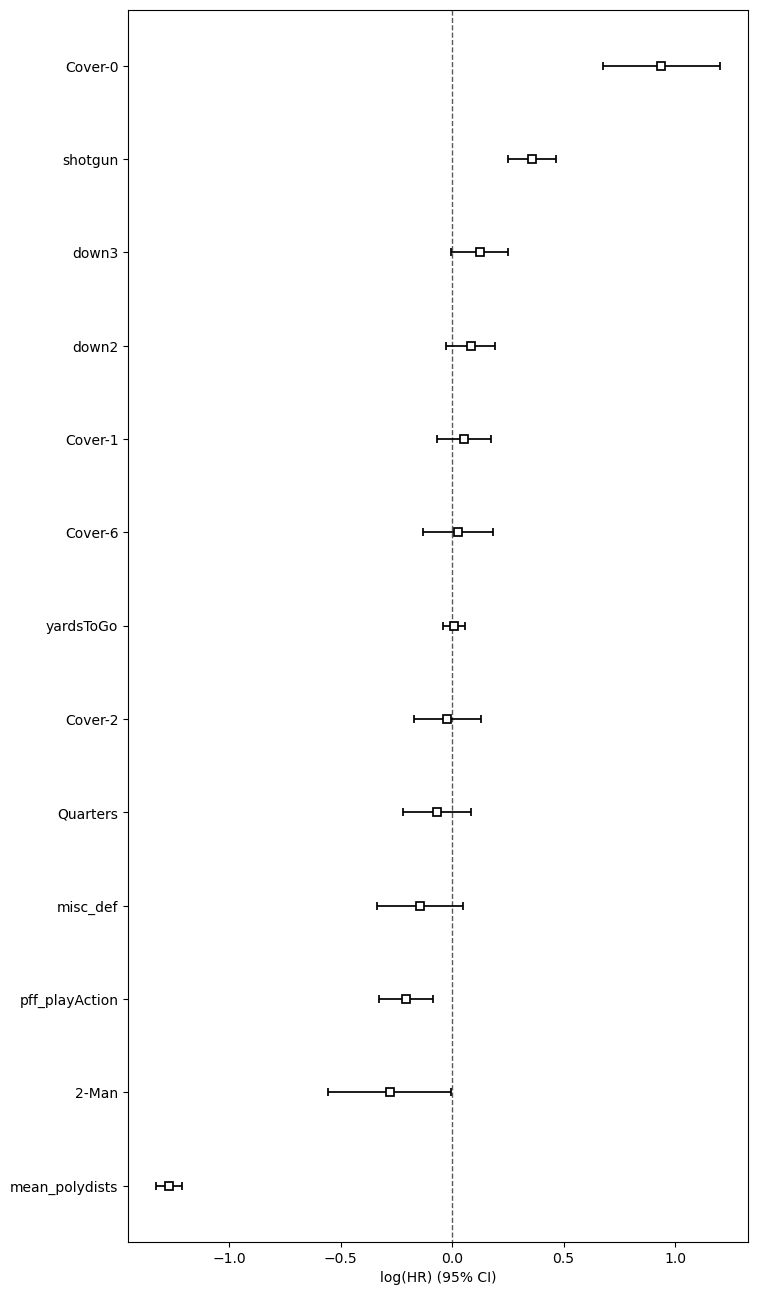

In [150]:
plt.figure(figsize=(8,16))
cph.plot()
plt.show()

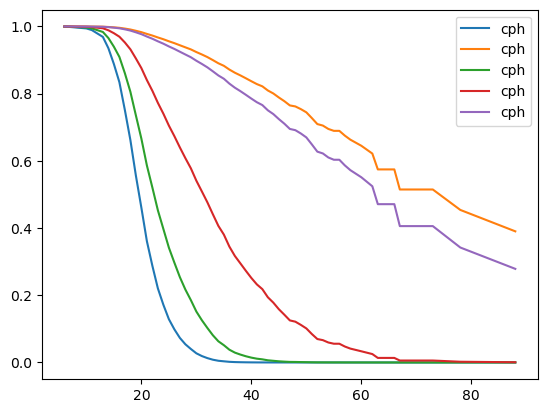

In [151]:
plt.plot(cph.predict_survival_function(Xts.iloc[:5]), label="cph")
plt.legend()
plt.show()

(0.0, 50.0)

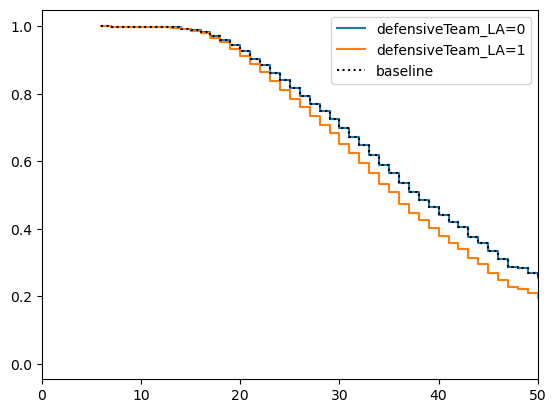

In [152]:
# aaf.plot_partial_effects_on_outcome("x0", values=[-1, 0, 1, 2])
cph_def.plot_partial_effects_on_outcome("defensiveTeam_LA", values=[0, 1,])
# cph.plot_partial_effects_on_outcome(["shotgun", "pff_playAction"], values=[[0, 1,],[0, 1,]])
plt.xlim(0,50)


### Here are some rankings, but there are some wrinkles still: how to account for censoring in predicting life expectancy?

In [153]:
pred_pocket_uptime = pd.DataFrame(cph_offdef.predict_expectation(X[col_subset+def_team_cols+off_team_cols])).rename(columns={0:"expected_uptime"})
pred_pocket_uptime["actual_uptime"] = Y[["surv_frame", "pass_frame"]].min(axis=1)
pred_pocket_uptime["mean_uptime_over_expected"] = pred_pocket_uptime["actual_uptime"]  - pred_pocket_uptime["expected_uptime"]
print(pred_pocket_uptime.median(numeric_only=True))
pred_pocket_uptime = pd.concat([pred_pocket_uptime, plays_with_collapse.iloc[pred_pocket_uptime.index][["gameId", "playId", "possessionTeam", "defensiveTeam"]]], axis=1)
pred_pocket_uptime.shape

expected_uptime              34.820998
actual_uptime                24.000000
mean_uptime_over_expected    -8.509587
dtype: float64


(8204, 7)

In [154]:
tpu_off = pred_pocket_uptime.groupby("possessionTeam")[
    ["expected_uptime", "actual_uptime", "mean_uptime_over_expected"]
].mean().sort_values("mean_uptime_over_expected", ascending=False).reset_index().merge(
    le_df[["team", "life_expectancy_offense"]],
    left_on="possessionTeam",
    right_on="team",
).drop(
    columns=["team"]
)
tpu_off["diff"] = tpu_off["life_expectancy_offense"] - tpu_off["expected_uptime"]
tpu_off

possessionTeam  expected_uptime  actual_uptime  mean_uptime_over_expected  \
0             DET        33.003934      25.565495                  -7.438439   
1             NYG        32.580762      24.775087                  -7.805676   
2             JAX        33.672233      25.412245                  -8.259988   
3              LV        34.199409      25.027559                  -9.171850   
4             CAR        35.180760      25.790210                  -9.390550   
5             DAL        34.418012      24.881890                  -9.536122   
6             HOU        33.684596      23.931915                  -9.752681   
7             ATL        33.871490      24.109489                  -9.762001   
8             TEN        34.425292      24.655431                  -9.769861   
9             LAC        34.400467      24.447876                  -9.952590   
10            SEA        35.646454      25.348416                 -10.298038   
11             NE        34.816239      24.280576                 -10.535664   
12            BUF        36.341128      25.777328                 -10.563800   
13            MIN        35.614254      25.004082                 -10.610173   
14            CHI        37.035682      25.752101                 -11.283581   
15             NO        39.038033      27.133333                 -11.904700   
16             LA        38.333752      25.926230                 -12.407523   
17            BAL        40.065693      27.608365                 -12.457328   
18            NYJ        37.957555      25.134100                 -12.823456   
19            DEN        39.211491      26.263538                 -12.947954   
20            IND        39.361882      26.376033                 -12.985848   
21            MIA        37.650176      24.540541                 -13.109635   
22             KC        39.322088      26.033233                 -13.288855   
23            PHI        41.737728      27.962963                 -13.774765   
24            CIN        38.591668      24.756098                 -13.835570   
25            WAS        41.386502      27.196491                 -14.190011   
26             TB        39.197188      24.920266                 -14.276922   
27            PIT        37.527472      23.179039                 -14.348433   
28            ARI        41.591769      26.668122                 -14.923647   
29             SF        40.861696      25.819905                 -15.041790   
30             GB        42.328235      25.739535                 -16.588700   
31            CLE        43.839345      26.831169                 -17.008176   

    life_expectancy_offense      diff  
0                 30.770195 -2.233739  
1                 32.376395 -0.204367  
2                 29.381058 -4.291175  
3                 29.482517 -4.716891  
4                 31.292867 -3.887893  
5                 31.945788 -2.472224  
6                 29.359838 -4.324758  
7                 29.567030 -4.304460  
8                 31.124483 -3.300809  
9                 30.572119 -3.828347  
10                29.539262 -6.107192  
11                29.833654 -4.982586  
12                31.744694 -4.596433  
13                30.908015 -4.706239  
14                31.621403 -5.414279  
15                31.943394 -7.094639  
16                31.898762 -6.434990  
17                33.775811 -6.289882  
18                30.098959 -7.858597  
19                32.200936 -7.010555  
20                30.948070 -8.413811  
21                29.987420 -7.662756  
22                31.705495 -7.616593  
23                35.135125 -6.602603  
24                34.605525 -3.986143  
25                32.912098 -8.474404  
26                32.744066 -6.453122  
27                30.132605 -7.394867  
28                32.911731 -8.680038  
29                34.333768 -6.527928  
30                33.316166 -9.012069  
31                34.569171 -9.270174

In [155]:
tpu_def = pred_pocket_uptime.groupby("defensiveTeam")[
    ["expected_uptime", "actual_uptime", "mean_uptime_over_expected"]
].mean().sort_values("mean_uptime_over_expected", ascending=True).reset_index().merge(
    le_df[["team", "life_expectancy_defense"]],
    left_on="defensiveTeam",
    right_on="team",
).drop(
    columns=["team"]
)
tpu_def["diff"] = tpu_def["life_expectancy_defense"] - tpu_def["expected_uptime"]
tpu_def

defensiveTeam  expected_uptime  actual_uptime  mean_uptime_over_expected  \
0            JAX        41.840940      25.920188                 -15.920752   
1             GB        41.998335      26.494340                 -15.503995   
2            DEN        41.070169      25.867470                 -15.202699   
3            NYG        41.804741      26.789091                 -15.015650   
4            CIN        41.051101      26.286604                 -14.764497   
5            PIT        39.345568      24.842553                 -14.503015   
6            TEN        39.825145      25.687075                 -14.138070   
7            CHI        39.682207      25.774892                 -13.907315   
8            ARI        39.490148      25.583673                 -13.906475   
9            ATL        39.741491      26.684685                 -13.056806   
10            LV        38.443939      25.701149                 -12.742790   
11            NO        39.232725      26.608527                 -12.624198   
12           BUF        38.045297      25.516667                 -12.528630   
13            NE        38.811092      26.282528                 -12.528564   
14           DET        39.253159      26.939815                 -12.313344   
15           SEA        37.705804      25.568027                 -12.137777   
16            TB        36.714347      24.655063                 -12.059284   
17            SF        37.801406      25.842342                 -11.959063   
18           WAS        36.156260      24.534426                 -11.621834   
19            KC        36.866609      25.709163                 -11.157446   
20           DAL        36.101004      25.102362                 -10.998642   
21           BAL        35.675874      24.741935                 -10.933939   
22            LA        35.165628      24.838816                 -10.326812   
23           IND        35.080613      25.270992                  -9.809621   
24           NYJ        34.224890      24.466667                  -9.758224   
25           LAC        35.920374      26.432558                  -9.487816   
26           MIN        34.558553      25.891667                  -8.666887   
27           HOU        34.303171      25.755556                  -8.547615   
28           PHI        32.732155      24.297189                  -8.434966   
29           CLE        32.708336      24.639676                  -8.068660   
30           MIA        32.307126      24.740351                  -7.566775   
31           CAR        30.038941      23.490119                  -6.548823   

    life_expectancy_defense      diff  
0                 32.328720 -9.512220  
1                 34.932079 -7.066255  
2                 32.005239 -9.064930  
3                 32.939296 -8.865445  
4                 32.054750 -8.996352  
5                 30.123296 -9.222272  
6                 31.628602 -8.196543  
7                 32.549189 -7.133018  
8                 32.500640 -6.989508  
9                 32.052377 -7.689114  
10                33.227504 -5.216435  
11                33.309166 -5.923559  
12                31.924797 -6.120500  
13                33.617779 -5.193313  
14                32.905509 -6.347650  
15                31.450858 -6.254946  
16                30.860472 -5.853875  
17                32.085830 -5.715576  
18                29.859379 -6.296881  
19                31.441035 -5.425574  
20                31.878280 -4.222724  
21                31.783156 -3.892718  
22                30.815801 -4.349827  
23                32.276430 -2.804182  
24                32.267174 -1.957716  
25                31.528439 -4.391935  
26                31.146239 -3.412314  
27                30.808643 -3.494527  
28                28.358525 -4.373630  
29                29.129604 -3.578732  
30                29.718155 -2.588971  
31                28.181299 -1.857642

In [156]:
player_pocket_uptime = pd.merge(
    scouting[scouting.pff_role.isin(["Pass", "Pass Rush", "Pass Block"])][
        ["gameId", "playId", "nflId", "pff_role"]
    ],
    pred_pocket_uptime,
    how="right",
    on=["gameId", "playId"],
)

In [157]:
ppu = player_pocket_uptime.groupby("nflId").agg(
    {
        "expected_uptime": "mean",
        "actual_uptime": "mean",
        "mean_uptime_over_expected": "mean",
        "playId": "count",
    }
).rename(columns={"playId": "num_snaps"}).sort_values(
    "mean_uptime_over_expected", ascending=True
).reset_index().merge(
    players, on="nflId"
).drop(columns=["collegeName", "height", "weight", "birthDate"])

In [158]:
ppu[(ppu.num_snaps>100) & (ppu.officialPosition.isin(["C", "T", "G"]))].sort_values(
    "mean_uptime_over_expected", ascending=False
).head(25)

nflId  expected_uptime  actual_uptime  mean_uptime_over_expected  \
970  43695        31.173635      23.992701                  -7.180934   
958  46090        32.010749      24.654762                  -7.355987   
953  46679        32.637719      25.232044                  -7.405675   
947  48455        33.003934      25.565495                  -7.438439   
948  52483        33.003934      25.565495                  -7.438439   
942  37090        32.325922      24.822222                  -7.503699   
940  43453        33.097690      25.569132                  -7.528559   
939  53436        33.097690      25.569132                  -7.528559   
928  46089        33.738112      26.038462                  -7.699650   
920  46103        32.580762      24.775087                  -7.805676   
911  43302        32.259524      24.324561                  -7.934962   
910  41324        33.503933      25.564356                  -7.939576   
893  52412        34.035219      25.907407                  -8.127812   
891  41939        33.529735      25.390947                  -8.138789   
887  41322        34.277182      26.090909                  -8.186273   
877  47818        33.672233      25.412245                  -8.259988   
879  44846        33.672233      25.412245                  -8.259988   
868  52507        31.650921      23.335714                  -8.315207   
867  53446        33.326402      25.004292                  -8.322110   
857  42410        34.348465      25.847619                  -8.500846   
848  47995        34.542130      25.913793                  -8.628337   
844  47838        32.763858      24.101852                  -8.662006   
833  42424        34.989449      26.174312                  -8.815137   
808  48235        34.199409      25.027559                  -9.171850   
809  52517        34.199409      25.027559                  -9.171850   

     num_snaps officialPosition            displayName  
970        137                C             Matt Skura  
958        252                C            Billy Price  
953        181                C             Evan Brown  
947        313                T            Matt Nelson  
948        313                G          Jonah Jackson  
942        270                T            Nate Solder  
940        311                G  Halapoulivaati Vaitai  
939        311                T           Penei Sewell  
928        130                C           Frank Ragnow  
920        289                G         Will Hernandez  
911        114                T          Laremy Tunsil  
910        101                G      Michael Schofield  
893        162                T          Andrew Thomas  
891        243                G         Andrew Norwell  
887        154                G         Brandon Linder  
877        245                T          Jawaan Taylor  
879        245                T           Cam Robinson  
868        140                T             Matt Peart  
867        233                T       Alex Leatherwood  
857        105                G              A.J. Cann  
848        174                G           Dennis Daley  
844        216                G          Max Scharping  
833        218                G            John Miller  
808        254                C            Andre James  
809        254                G           John Simpson

In [159]:
pd.DataFrame(cph_offdef.predict_survival_function(X[col_subset+def_team_cols+off_team_cols]), [30]).T

30
0     0.307699
1     0.725344
2     0.947927
3     0.556947
4     0.181189
...        ...
8199  0.951865
8200  0.554695
8201  0.328965
8202  0.072604
8203  0.628815

[8204 rows x 1 columns]

## Inverse Probability of Censoring Weighting
in order to get a better estimate of "observed outcomes" we scale the observed (censoring or event) by the inverse of the probability an observation lasts that long (as can be estimated using KM)

In [160]:
# set timepoint (e.g. 30 frames)
tau = 30
# survival probability of the pocket as predicted by cph_offdef 
pred_surv_rate30 = pd.DataFrame(cph_offdef.predict_survival_function(X[col_subset+def_team_cols+off_team_cols]), [tau]).T.rename(columns={tau:"surv_rate"})

In [161]:
# estimate the probability of an observation to be a certain length
cens_time = Y[["surv_frame", "pass_frame"]].min(axis=1)
cens_event = Y["survived"] | Y.pass_frame.le(Y.surv_frame) # 1 if pocket did not collapse or pass frame occurs before collapse frame (inverse of coxph event thing)
censor_prob = KaplanMeierFitter().fit(cens_time, cens_event) # this schould now be an estimate of a observation being not yet censored at time t (maybe this should be a Cox model as well?)

In [162]:
cens_event.value_counts()

True     4750
False    3454
Name: count, dtype: int64

In [163]:
pred_pocket_uptime.head()

expected_uptime  actual_uptime  mean_uptime_over_expected      gameId  \
0        20.621667             29                   8.378333  2021090900   
1        35.326687             23                 -12.326687  2021090900   
2        65.671927             20                 -45.671927  2021090900   
3        27.241721             30                   2.758279  2021090900   
4        18.016280             17                  -1.016280  2021090900   

   playId possessionTeam defensiveTeam  
0      97             TB           DAL  
1     137            DAL            TB  
2     187            DAL            TB  
3     282            DAL            TB  
4     349            DAL            TB

In [164]:
# for each play: pred_surv_rate30 gives us the life expectancy
# inverse weight of censoring  
w = 1 / np.maximum(censor_prob.survival_function_at_times(times=np.minimum(cens_time, 50)), 1e-6)


In [165]:

pred_pocket_uptime["weighting"] = w.values * (1-cens_event).values


In [166]:

pred_pocket_uptime["weighted_observed_residuals"] = (pred_pocket_uptime["actual_uptime"] - pred_pocket_uptime["expected_uptime"]) * pred_pocket_uptime["weighting"]


In [167]:
pred_pocket_uptime.head()

expected_uptime  actual_uptime  mean_uptime_over_expected      gameId  \
0        20.621667             29                   8.378333  2021090900   
1        35.326687             23                 -12.326687  2021090900   
2        65.671927             20                 -45.671927  2021090900   
3        27.241721             30                   2.758279  2021090900   
4        18.016280             17                  -1.016280  2021090900   

   playId possessionTeam defensiveTeam  weighting  weighted_observed_residuals  
0      97             TB           DAL   2.261736                    18.949577  
1     137            DAL            TB   1.370361                   -16.892016  
2     187            DAL            TB   0.000000                    -0.000000  
3     282            DAL            TB   2.486580                     6.858682  
4     349            DAL            TB   1.044339                    -1.061340

In [168]:

ppud = pred_pocket_uptime[pred_pocket_uptime["weighting"].gt(0.0)].groupby("defensiveTeam")["weighted_observed_residuals"].agg(["mean","count","std", "sum"])
ppud["norm"] = ppud["mean"] / ppud["sum"]
ppud["norm2"] = ppud["mean"] / ppud["sum"].sum()
ppud.sort_values("mean")

mean  count        std          sum      norm     norm2
defensiveTeam                                                              
DEN             0.425476     86  41.434388    36.590959  0.011628  0.000011
NYJ             4.449756     89  16.842578   396.028276  0.011236  0.000110
SEA             4.604584    124  52.421178   570.968452  0.008065  0.000114
PHI             6.254878    112  24.673151   700.546335  0.008929  0.000155
CHI             7.417255     88  45.685390   652.718465  0.011364  0.000183
TB              7.697748    125  37.923349   962.218507  0.008000  0.000190
BAL             8.199613    107  30.258960   877.358586  0.009346  0.000203
CAR             8.428496    122  27.148516  1028.276490  0.008197  0.000208
HOU             8.983451     95  26.183657   853.427892  0.010526  0.000222
SF              9.031157     96  54.836787   866.991034  0.010417  0.000223
ATL             9.361185     87  54.274072   814.423100  0.011494  0.000232
NE              9.852210    119  45.241874  1172.413020  0.008403  0.000244
MIA             9.968908    134  40.949778  1335.833693  0.007463  0.000247
MIN            10.092010    110  34.427193  1110.121054  0.009091  0.000250
IND            10.705574    112  32.025788  1199.024232  0.008929  0.000265
LAC            10.777218     97  39.891644  1045.390142  0.010309  0.000267
PIT            11.640128     84  50.382568   977.770774  0.011905  0.000288
CLE            12.662601    121  48.766883  1532.174664  0.008264  0.000313
LV             12.714310    102  53.435811  1296.859649  0.009804  0.000315
GB             12.788532     97  59.167424  1240.487614  0.010309  0.000316
JAX            12.862830     84  62.498295  1080.477679  0.011905  0.000318
BUF            12.919198    102  56.540458  1317.758154  0.009804  0.000320
LA             14.452585    136  51.038758  1965.551595  0.007353  0.000358
DAL            14.567265    118  61.079378  1718.937282  0.008475  0.000360
DET            14.638698     95  46.729255  1390.676307  0.010526  0.000362
KC             14.671229    109  52.388355  1599.163958  0.009174  0.000363
WAS            14.674037    125  58.963105  1834.254611  0.008000  0.000363
ARI            17.712986     83  49.431754  1470.177801  0.012048  0.000438
TEN            17.828304    138  83.356284  2460.305967  0.007246  0.000441
NO             18.242144    108  51.553122  1970.151562  0.009259  0.000451
CIN            19.537073    137  65.604068  2676.578987  0.007299  0.000483
NYG            20.286239    112  65.044298  2272.058763  0.008929  0.000502

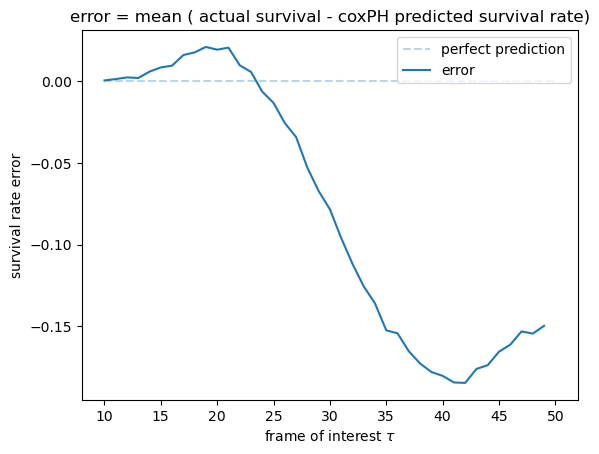

In [169]:
taus = []
taus_masked = []
for tau in range(10, 50): 
    # predict survival rate at time tau
    pred_surv_rate30 = pd.DataFrame(cph_offdef.predict_survival_function(X[col_subset+def_team_cols+off_team_cols]), [tau]).T.rename(columns={tau:"surv_rate"})
    # observe survival 
    actual_survival = Y["surv_frame"] >= tau 
    pred_surv_rate30["actual_surv"] = actual_survival
    # deviation: 1-surv_rate if survived, 0-surv_rate if died early, mean of surv_res: ~percentage of pockets surviving over expectation
    pred_surv_rate30["surv_res"] = actual_survival - pred_surv_rate30.surv_rate

    pred_surv_rate30 = pd.concat([pred_surv_rate30, X[["defensiveTeam", "possessionTeam"]]], axis=1)

    # only look at those that a) collapsed or b) survived >= tau which leaves out censored before tau
    ol = pred_surv_rate30[~Y["survived"] | actual_survival].groupby("possessionTeam")["surv_res"].agg(["mean","count","std"]).reset_index().sort_values("mean", ascending=False).rename(columns={"mean":"ol_resid_mean"})
    dl = pred_surv_rate30[~Y["survived"] | actual_survival].groupby("defensiveTeam")["surv_res"].agg(["mean","count","std"]).reset_index().sort_values("mean", ascending=True).rename(columns={"mean":"dl_resid_mean"})

    taus.append(pred_surv_rate30["surv_res"].mean())
    taus_masked.append(pred_surv_rate30[~Y["survived"] | actual_survival]["surv_res"].mean())
    
plt.hlines([0], 10, 50, linestyle="--", alpha=.3, label="perfect prediction")
# plt.plot(np.arange(10, 50), taus, label="unmasked")
plt.plot(np.arange(10, 50), taus_masked, label="error")
plt.xlabel(r"frame of interest $\tau$")
plt.ylabel("survival rate error")
plt.title("error = mean ( actual survival - coxPH predicted survival rate)")
plt.legend()
plt.show()

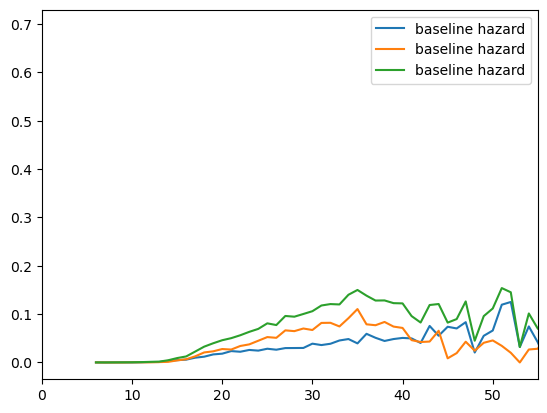

In [170]:
fig, ax = plt.subplots(1,1)
cph_offdef.baseline_hazard_.plot(ax=ax, label="collapse")
pass_cox_offdef.baseline_hazard_.plot(ax=ax, label="pass")
(cph_offdef.baseline_hazard_ + pass_cox_offdef.baseline_hazard_).plot(ax=ax, label="pass+collapse")
plt.legend()
plt.xlim(0, 55)
plt.show()

  0%|          | 0/40 [00:00<?, ?it/s]

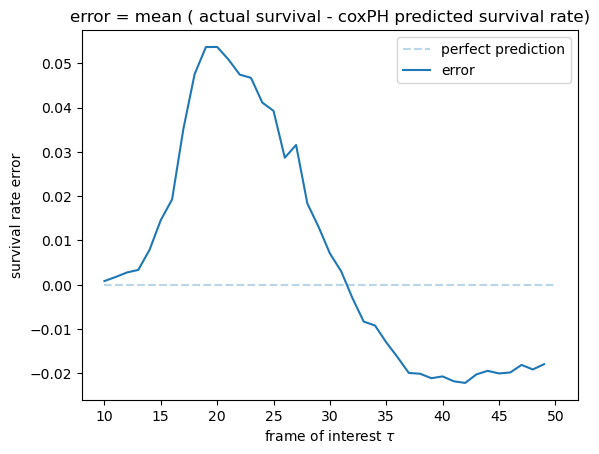

In [171]:
taus = []
taus_masked = []
for tau in trange(10, 50): 
    # predict survival rate at time tau
    pred_surv_rate30 = pd.DataFrame(cph_offdef.predict_cumulative_hazard(X[col_subset+def_team_cols+off_team_cols]), [tau]).T.rename(columns={tau:"collapse_hazard"})
    pred_surv_rate30["pass_hazard"] = pd.DataFrame(pass_cox_offdef.predict_cumulative_hazard(X[col_subset+def_team_cols+off_team_cols]), [tau]).T.rename(columns={tau:"pass_hazard"})["pass_hazard"]
    pred_surv_rate30["agg_hazards"] = pred_surv_rate30["collapse_hazard"] + pred_surv_rate30["pass_hazard"] 
    pred_surv_rate30["surv_rate"] = np.exp(-pred_surv_rate30["agg_hazards"])

    actual_survival = (Y["surv_frame"] >= tau) & (Y["pass_frame"] >= tau) 
    pred_surv_rate30["actual_surv"] = actual_survival
    # deviation: 1-surv_rate if survived, 0-surv_rate if died early, mean of surv_res: ~percentage of pockets surviving over expectation
    pred_surv_rate30["surv_res"] = actual_survival - pred_surv_rate30.surv_rate

    taus_masked.append(pred_surv_rate30[X["pass_event"] | X["event"] | actual_survival]["surv_res"].mean())
    
plt.hlines([0], 10, 50, linestyle="--", alpha=.3, label="perfect prediction")
# plt.plot(np.arange(10, 50), taus, label="unmasked")
plt.plot(np.arange(10, 50), taus_masked, label="error")
plt.xlabel(r"frame of interest $\tau$")
plt.ylabel("survival rate error")
plt.title("error = mean ( actual survival - coxPH predicted survival rate)")
plt.legend()
plt.show()

## residual survival 

In [ ]:
tau=25
team_feats = ["none", "off", "def", "offdef"]
col_model = [cph, cph_off, cph_def, cph_offdef]
pass_model = [pass_cox, pass_cox_off, pass_cox_def, pass_cox_offdef]

pred_surv_rate = plays_with_collapse[["gameId", "playId"]].copy()

for tau in trange(20, 51, 5): 
    for cmod, pmod, team_feat in zip(col_model, pass_model, team_feats): 
        pred_surv_rate[f"collapse_hazard_{tau}_{team_feat}"] = pd.DataFrame(cmod.predict_cumulative_hazard(X[col_subset+def_team_cols+off_team_cols]), [tau]).T.rename(columns={tau:"collapse_hazard"})["collapse_hazard"]
        pred_surv_rate[f"pass_hazard_{tau}_{team_feat}"] = pd.DataFrame(pmod.predict_cumulative_hazard(X[col_subset+def_team_cols+off_team_cols]), [tau]).T.rename(columns={tau:"pass_hazard"})["pass_hazard"]
        pred_surv_rate[f"agg_hazards_{tau}_{team_feat}"] = pred_surv_rate[f"collapse_hazard_{tau}_{team_feat}"] + pred_surv_rate[f"pass_hazard_{tau}_{team_feat}"] 
        pred_surv_rate[f"surv_rate_{tau}_{team_feat}"] = np.exp(-pred_surv_rate[f"agg_hazards_{tau}_{team_feat}"])

        actual_survival = (Y["surv_frame"] >= tau) & (Y["pass_frame"] >= tau) 
        pred_surv_rate[f"actual_surv_{tau}_{team_feat}"] = actual_survival
        # deviation: 1-surv_rate if survived, 0-surv_rate if died early, mean of surv_res: ~percentage of pockets surviving over expectation
        pred_surv_rate[f"surv_res_{tau}_{team_feat}"] = actual_survival - pred_surv_rate[f"surv_rate_{tau}_{team_feat}"]
        

  0%|          | 0/7 [00:00<?, ?it/s]

C:\Users\mschilling\AppData\Local\Temp\ipykernel_21088\1545990126.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\mschilling\AppData\Local\Temp\ipykernel_21088\1545990126.py:16: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\mschilling\AppData\Local\Temp\ipykernel_21088\1545990126.py:18: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To ge

In [227]:
pred_surv_rate = pred_surv_rate.copy()
pred_surv_rate

gameId  playId  collapse_hazard_20_none  pass_hazard_20_none  \
0     2021090900      97                 0.165865             0.093251   
1     2021090900     137                 0.071623             0.158395   
2     2021090900     187                 0.012970             0.493594   
3     2021090900     282                 0.127950             0.040356   
4     2021090900     349                 0.349994             0.042453   
...          ...     ...                      ...                  ...   
8199  2021110100    4113                 0.011612             0.323792   
8200  2021110100    4310                 0.124604             0.062043   
8201  2021110100    4363                 0.156946             0.079395   
8202  2021110100    4392                 0.351683             0.059797   
8203  2021110100    4411                 0.066883             0.084196   

      agg_hazards_20_none  surv_rate_20_none  actual_surv_20_none  \
0                0.259116           0.771734                 True   
1                0.230018           0.794519                 True   
2                0.506563           0.602563                 True   
3                0.168306           0.845095                 True   
4                0.392447           0.675402                False   
...                   ...                ...                  ...   
8199             0.335405           0.715049                 True   
8200             0.186647           0.829736                 True   
8201             0.236341           0.789511                 True   
8202             0.411479           0.662669                 True   
8203             0.151079           0.859780                 True   

      surv_res_20_none  collapse_hazard_20_off  pass_hazard_20_off  ...  \
0             0.228266                0.217766            0.085173  ...   
1             0.205481                0.074085            0.173557  ...   
2             0.397437                0.012368            0.607762  ...   
3             0.154905                0.134903            0.042829  ...   
4            -0.675402                0.383706            0.041518  ...   
...                ...                     ...                 ...  ...   
8199          0.284951                0.011620            0.260310  ...   
8200          0.170264                0.134695            0.043457  ...   
8201          0.210489                0.236229            0.076067  ...   
8202          0.337331                0.548721            0.053694  ...   
8203          0.140220                0.096951            0.083307  ...   

      agg_hazards_50_def  surv_rate_50_def  actual_surv_50_def  \
0               4.729041          0.008835               False   
1               4.421674          0.012014               False   
2              10.752331          0.000021               False   
3               3.024234          0.048595               False   
4               7.036655          0.000879               False   
...                  ...               ...                 ...   
8199            5.140488          0.005855               False   
8200            2.750998          0.063864               False   
8201            3.894786          0.020348               False   
8202            7.186449          0.000757               False   
8203            2.387798          0.091832               False   

      surv_res_50_def  collapse_hazard_50_offdef  pass_hazard_50_offdef  \
0           -0.008835                   4.690798               1.614656   
1           -0.012014                   1.277970               4.296036   
2           -0.000021                   0.212834              15.685030   
3           -0.048595                   2.329355               1.045753   
4           -0.000879                   6.798451               1.011865   
...               ...                        ...                    ...   
8199        -0.005855                   0.196334               4.323029  

In [229]:
pred_surv_rate = pd.concat([pred_surv_rate, X[["defensiveTeam", "possessionTeam"]]], axis=1)


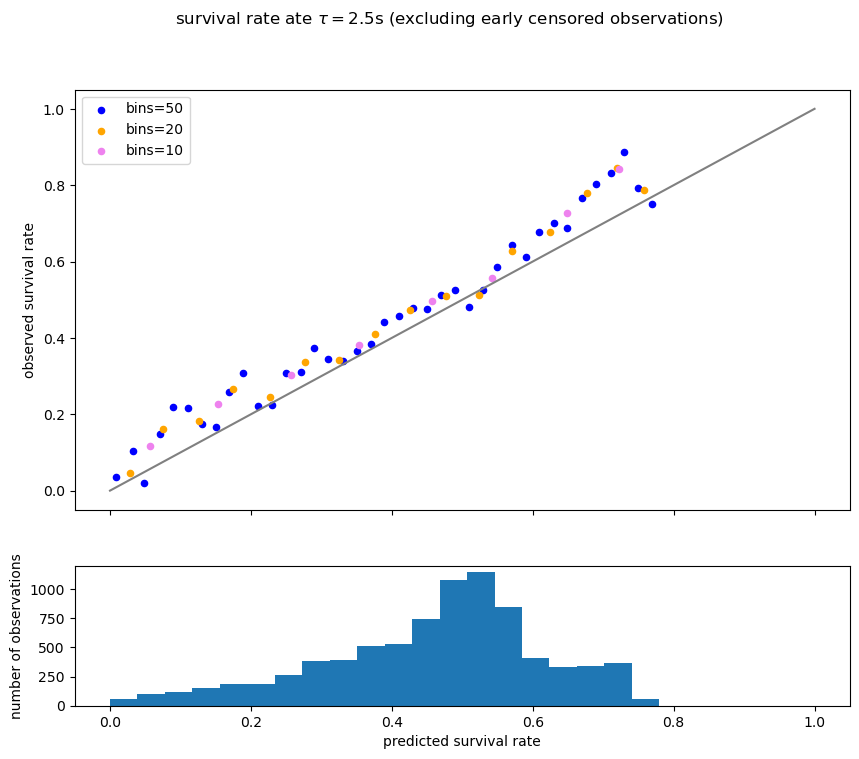

In [276]:
tau = 25
team_feat = "none"

fig, ax = plt.subplots(
    2, 1, figsize=(10, 8), sharex=True, gridspec_kw={"height_ratios": [3, 1]}
)

pred_surv_rate[X["pass_event"] | X["event"]  | pred_surv_rate[f"actual_surv_{tau}_{team_feat}"]].groupby(
    pred_surv_rate[f"surv_rate_{tau}_{team_feat}"] * 100 // 2
)[[f"actual_surv_{tau}_{team_feat}", f"surv_rate_{tau}_{team_feat}"]].mean().plot.scatter(
    x=f"surv_rate_{tau}_{team_feat}", y=f"actual_surv_{tau}_{team_feat}", ax=ax[0], label="bins=50", color="blue"
)
pred_surv_rate[X["pass_event"] | X["event"]  | pred_surv_rate[f"actual_surv_{tau}_{team_feat}"]].groupby(
    pred_surv_rate[f"surv_rate_{tau}_{team_feat}"] * 100 // 5
)[[f"actual_surv_{tau}_{team_feat}", f"surv_rate_{tau}_{team_feat}"]].mean().plot.scatter(
    x=f"surv_rate_{tau}_{team_feat}", y=f"actual_surv_{tau}_{team_feat}", ax=ax[0], label="bins=20", color="orange"
)
pred_surv_rate[X["pass_event"] | X["event"]  | pred_surv_rate[f"actual_surv_{tau}_{team_feat}"]].groupby(
    pred_surv_rate[f"surv_rate_{tau}_{team_feat}"] * 100 // 10
)[[f"actual_surv_{tau}_{team_feat}", f"surv_rate_{tau}_{team_feat}"]].mean().plot.scatter(
    x=f"surv_rate_{tau}_{team_feat}", y=f"actual_surv_{tau}_{team_feat}", ax=ax[0], label="bins=10", color="violet"
)
ax[0].plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), color="gray")
ax[1].hist(pred_surv_rate[f"surv_rate_{tau}_{team_feat}"], bins=20)
ax[1].set_xlabel("predicted survival rate")
ax[0].set_ylabel("observed survival rate")
ax[1].set_ylabel("number of observations")
fig.suptitle(r"survival rate ate $\tau=$"+f"{tau/10:3.1f}s (excluding early censored observations)")
plt.show()

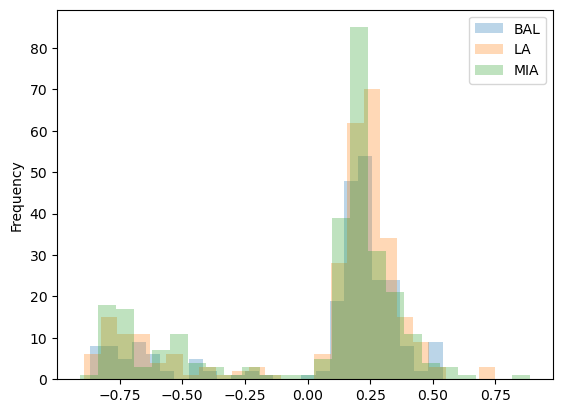

In [236]:
tau = 20
team_feat="off"

pred_surv_rate[(X["pass_event"] | X["event"] | actual_survival) & (pred_surv_rate["defensiveTeam"] == "BAL")][f"surv_res_{tau}_{team_feat}"].plot.hist(bins=25, label="BAL", alpha=.3)
pred_surv_rate[(X["pass_event"] | X["event"] | actual_survival) & (pred_surv_rate["defensiveTeam"] == "LA")][f"surv_res_{tau}_{team_feat}"].plot.hist(bins=25, label="LA", alpha=.3)
pred_surv_rate[(X["pass_event"] | X["event"] | actual_survival) & (pred_surv_rate["defensiveTeam"] == "MIA")][f"surv_res_{tau}_{team_feat}"].plot.hist(bins=25, label="MIA", alpha=.3)
plt.legend()
plt.show()

In [277]:
tau=20
team_feat="off"

ol_aggs = []
dl_aggs = []

# only look at those that a) collapsed or b) survived >= tau which leaves out censored before tau
for tau in range(20, 51, 5): 
    ol_aggs.append(pred_surv_rate[X["pass_event"] | X["event"] | actual_survival].groupby("possessionTeam")[f"surv_res_{tau}_def"].agg(["mean", "count"]).sort_values("mean", ascending=False).rename(columns={"mean":f"ol_resid_mean_{tau}"}))
    dl_aggs.append(pred_surv_rate[X["pass_event"] | X["event"] | actual_survival].groupby("defensiveTeam")[f"surv_res_{tau}_off"].agg(["mean", "count"]).sort_values("mean", ascending=True).rename(columns={"mean":f"dl_resid_mean_{tau}"}))

ol_aggs = pd.concat(ol_aggs, axis=1)
dl_aggs = pd.concat(dl_aggs, axis=1)



In [278]:
ol_aggs[[f"ol_resid_mean_{ti}" for ti in range(20, 41, 5)]].corr(method="spearman")

ol_resid_mean_20  ol_resid_mean_25  ol_resid_mean_30  \
ol_resid_mean_20          1.000000          0.676686          0.449413   
ol_resid_mean_25          0.676686          1.000000          0.776026   
ol_resid_mean_30          0.449413          0.776026          1.000000   
ol_resid_mean_35          0.398827          0.664223          0.934384   
ol_resid_mean_40          0.357771          0.486070          0.735337   

                  ol_resid_mean_35  ol_resid_mean_40  
ol_resid_mean_20          0.398827          0.357771  
ol_resid_mean_25          0.664223          0.486070  
ol_resid_mean_30          0.934384          0.735337  
ol_resid_mean_35          1.000000          0.863270  
ol_resid_mean_40          0.863270          1.000000

In [279]:
dl_aggs[[f"dl_resid_mean_{ti}" for ti in range(20, 41, 5)]].corr(method="spearman")

dl_resid_mean_20  dl_resid_mean_25  dl_resid_mean_30  \
dl_resid_mean_20          1.000000          0.506232          0.197214   
dl_resid_mean_25          0.506232          1.000000          0.664589   
dl_resid_mean_30          0.197214          0.664589          1.000000   
dl_resid_mean_35          0.126833          0.515762          0.732771   
dl_resid_mean_40          0.093842          0.248167          0.565982   

                  dl_resid_mean_35  dl_resid_mean_40  
dl_resid_mean_20          0.126833          0.093842  
dl_resid_mean_25          0.515762          0.248167  
dl_resid_mean_30          0.732771          0.565982  
dl_resid_mean_35          1.000000          0.767595  
dl_resid_mean_40          0.767595          1.000000

In [270]:
ol_aggs[[f"ol_resid_mean_{ti}" for ti in range(20, 41, 5)]].sort_values("ol_resid_mean_30", ascending=False)

ol_resid_mean_20  ol_resid_mean_25  ol_resid_mean_30  \
possessionTeam                                                         
BAL                     0.088706          0.128845          0.094806   
PHI                     0.113059          0.115933          0.089759   
CLE                     0.066199          0.103692          0.084342   
NO                      0.104328          0.148468          0.081442   
ARI                     0.066287          0.075052          0.069913   
KC                      0.038132          0.034171          0.052669   
LA                      0.022751          0.075570          0.050530   
IND                     0.064089          0.073932          0.037933   
BUF                     0.044239          0.080741          0.027025   
WAS                     0.058711          0.070204          0.023273   
SEA                     0.080566          0.000668          0.018011   
CAR                     0.093801          0.071669          0.011446   
CHI                     0.041596          0.003118          0.007725   
DEN                     0.087013          0.048551         -0.001805   
SF                     -0.021721         -0.012759         -0.002620   
HOU                     0.023956         -0.025909         -0.003253   
GB                      0.017742          0.027618         -0.014593   
NE                     -0.023418          0.013163         -0.016041   
NYJ                     0.081844          0.044259         -0.016304   
LV                      0.060801          0.000319         -0.020695   
DET                     0.096350          0.051830         -0.022365   
JAX                     0.088564          0.029877         -0.027875   
MIA                    -0.022741         -0.038035         -0.031550   
MIN                     0.082291          0.037464         -0.031571   
TB                      0.049197         -0.026324         -0.043259   
LAC                     0.006056         -0.005956         -0.048825   
NYG                     0.016816         -0.041073         -0.050535   
DAL                     0.049662          0.030873         -0.057086   
TEN                     0.038394          0.043053         -0.058700   
ATL                     0.041839         -0.015653         -0.068800   
CIN                     0.036461         -0.062761         -0.073480   
PIT                    -0.050820         -0.110643         -0.111693   

                ol_resid_mean_35  ol_resid_mean_40  
possessionTeam                                      
BAL                     0.026673         -0.011695  
PHI                     0.061062          0.024950  
CLE                     0.027032         -0.002897  
NO                      0.063528          0.038396  
ARI                     0.026462          0.001249  
KC                      0.043077          0.009413  
LA                      0.022123         -0.024699  
IND                    -0.006892         -0.031673  
BUF                    -0.013266         -0.029326  
WAS                    -0.024350         -0.030893  
SEA                     0.003597         -0.011447  
CAR                    -0.006376         -0.030301  
CHI                    -0.031641         -0.033849  
DEN                    -0.026065         -0.017217  
SF                     -0.022169         -0.023411  
HOU                    -0.003580         -0.019096  
GB                     -0.014481         -0.015828  
NE                     -0.034720         -0.049685  
NYJ                    -0.041013         -0.038583  
LV                     -0.022510         -0.015771  
DET                    -0.032811         -0.025400  
JAX                    -0.047631         -0.042411  
MIA                    -0.031634         -0.029598  
MIN                    -0.037068         -0.040086  
TB                     -0.045799         -0.047745  
LAC                    -0.055614         -0.029419  
NYG                    -0.061536         -0.040228  
DAL                    -0.0408

In [269]:
dl_aggs[[f"dl_resid_mean_{ti}" for ti in range(20, 41, 5)]].sort_values("dl_resid_mean_30", ascending=True)


dl_resid_mean_20  dl_resid_mean_25  dl_resid_mean_30  \
defensiveTeam                                                         
PIT                    0.072772         -0.065120         -0.087319   
PHI                    0.026028         -0.034885         -0.077882   
CAR                   -0.014707         -0.084054         -0.061529   
WAS                    0.024460         -0.020155         -0.050594   
NYJ                    0.080374          0.017209         -0.040269   
MIN                    0.075123          0.079985         -0.039427   
BAL                    0.066111         -0.013430         -0.036658   
HOU                    0.062210          0.011803         -0.035713   
ATL                    0.062369         -0.013160         -0.028851   
DAL                    0.043380          0.027562         -0.026392   
CLE                   -0.012030         -0.006629         -0.025875   
IND                    0.052505          0.033793         -0.023115   
SF                     0.065783          0.046244         -0.017848   
TB                     0.002534         -0.008313         -0.017576   
MIA                    0.017390          0.010179         -0.014849   
TEN                    0.020283         -0.012851         -0.014709   
BUF                    0.037845          0.058241         -0.012663   
SEA                    0.061900          0.049286         -0.011405   
DEN                    0.073210          0.077291         -0.006849   
CHI                    0.053183          0.015593          0.000927   
NYG                    0.055935          0.090981          0.013472   
LV                     0.032541          0.030313          0.015423   
ARI                    0.037205          0.058808          0.015663   
LAC                    0.010820          0.032296          0.023055   
LA                     0.057303         -0.038127          0.023396   
KC                     0.006490          0.004415          0.026639   
JAX                    0.127518          0.047012          0.035826   
GB                     0.073472          0.096036          0.043221   
DET                    0.030735          0.069396          0.049797   
CIN                    0.069651          0.094266          0.056819   
NE                     0.115588          0.134087          0.066273   
NO                     0.087503          0.129905          0.110023   

               dl_resid_mean_35  dl_resid_mean_40  
defensiveTeam                                      
PIT                   -0.051382         -0.039296  
PHI                   -0.050347         -0.036394  
CAR                   -0.026524         -0.030771  
WAS                   -0.061628         -0.048645  
NYJ                   -0.049530         -0.031502  
MIN                   -0.047653         -0.052979  
BAL                   -0.017572         -0.024798  
HOU                   -0.060423         -0.045291  
ATL                   -0.025233         -0.027651  
DAL                   -0.007994         -0.012322  
CLE                   -0.007160         -0.007334  
IND                   -0.020333         -0.036835  
SF                    -0.028378         -0.031046  
TB                    -0.037704         -0.021275  
MIA                   -0.017038         -0.025164  
TEN                   -0.022965         -0.024605  
BUF                   -0.004490         -0.007602  
SEA                   -0.011077         -0.032915  
DEN                   -0.040214         -0.055395  
CHI                   -0.026284         -0.016873  
NYG                    0.000496         -0.021965  
LV                    -0.018430         -0.006897  
ARI                   -0.025670         -0.036382  
LAC                   -0.019366         -0.036937  
LA                    -0.003749         -0.005081  
KC                    -0.022803         -0.032197  
JAX                   -0.016273         -0.007722  
GB                    -0.007267         -0.003724  
DET                    0.001508         

#### now we got "overall survival based on pass hazard and collapse hazard", what we are actually interested in is the likelihood of failing due to pocket collapse by $\tau$

In [ ]:
# def cum_collapse_prob(X:pd.DataFrame, collapse_cox, pass_cox, tau:int=30):
# (including .T) computes dataframe of shape num_samples x num_timesteps
feat_cols = [
    col_subset,
    col_subset+off_team_cols,
    col_subset+def_team_cols,
    col_subset+def_team_cols+off_team_cols
]


for tau in trange(20, 51, 5): 
    for cmod, pmod, team_feat, mcols in zip(col_model, pass_model, team_feats, feat_cols): 
        times = np.arange(tau+1)

        cum_hazard_collapse = cmod.predict_cumulative_hazard(X[mcols], times=times).T 
        diff_hazard_collapse = cum_hazard_collapse.diff(axis=1).fillna(0.0)

        cum_hazard_pass = pmod.predict_cumulative_hazard(X[mcols], times=times).T 
        diff_hazard_pass = cum_hazard_pass.diff(axis=1).fillna(0.0)

        cum_hazard_agg = cum_hazard_pass+cum_hazard_collapse
        diff_hazard_agg = cum_hazard_agg.diff(axis=1).fillna(0.0)
        agg_survival = np.exp(-cum_hazard_agg).shift(axis=1, periods=1, fill_value=1.0)

        cif_c = (agg_survival * (1-np.exp(-diff_hazard_agg))*diff_hazard_collapse/diff_hazard_agg).sum(axis=1)
        cif_p = (agg_survival * (1-np.exp(-diff_hazard_agg))*diff_hazard_pass/diff_hazard_agg).sum(axis=1)
        
        pred_surv_rate[f"cif_c_{tau}_{team_feat}"] = cif_c
        pred_surv_rate[f"cif_p_{tau}_{team_feat}"] = cif_p
        pred_surv_rate[f"tilt_expected_{tau}_{team_feat}"] = cif_c / (cif_c + cif_p)
        
        pred_surv_rate[f"collapse_before_tau_{tau}_{team_feat}"] = Y["surv_frame"].le(tau) & Y["surv_frame"].lt(Y["pass_frame"])
        pred_surv_rate[f"pass_before_tau_{tau}_{team_feat}"] = Y["pass_frame"].le(tau) & Y["pass_frame"].le(Y["surv_frame"])
        pred_surv_rate[f"surv_tau_{tau}_{team_feat}"] = Y["surv_frame"].gt(tau) & Y["pass_frame"].gt(tau)
        
        pred_surv_rate[f"pass_residual_{tau}_{team_feat}"] = pred_surv_rate[f"pass_before_tau_{tau}_{team_feat}"] - cif_p # pass - expected collapse 
        pred_surv_rate[f"collapse_residual_{tau}_{team_feat}"] = pred_surv_rate[f"collapse_before_tau_{tau}_{team_feat}"] - cif_c # collapse - expected collapse
        pred_surv_rate[f"surv_residual_{tau}_{team_feat}"] = pred_surv_rate[f"surv_tau_{tau}_{team_feat}"] - (1 - cif_p - cif_c) # survived - survival prob
        # shit does not add up

pred_surv_rate = pred_surv_rate.copy()
## sanity check: 
for tau in trange(20, 51, 5): 
    for cmod, pmod, team_feat, mcols in zip(col_model, pass_model, team_feats, feat_cols): 
        if abs(pred_surv_rate[f"pass_residual_{tau}_{team_feat}"] + pred_surv_rate[ f"collapse_residual_{tau}_{team_feat}"] + pred_surv_rate[ f"surv_residual_{tau}_{team_feat}"]) > 1e-9: 
            print(f"res_sum_{tau}_{team_feat}")
        if (pred_surv_rate[f"cif_p_{tau}_{team_feat}"] + pred_surv_rate[ f"cif_c_{tau}_{team_feat}"] ).abs() > 1: 
            print(f"cif_sum_{tau}_{team_feat}")
            

  0%|          | 0/7 [00:00<?, ?it/s]

count    8.204000e+03
mean    -1.707447e-19
std      2.645548e-17
min     -1.110223e-16
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.110223e-16
dtype: float64
count    8204.000000
mean        0.878502
std         0.102171
min         0.488613
25%         0.828054
50%         0.899848
75%         0.959931
max         0.998983
dtype: float64


In [347]:
for tau in trange(20, 51, 5): 
    for cmod, pmod, team_feat, mcols in zip(col_model, pass_model, team_feats, feat_cols): 
        if (pred_surv_rate[f"pass_residual_{tau}_{team_feat}"] + pred_surv_rate[ f"collapse_residual_{tau}_{team_feat}"] + pred_surv_rate[ f"surv_residual_{tau}_{team_feat}"]).between(-1e-9, 1e-9).sum()<(len(pred_surv_rate)): 
            print(f"res_sum_{tau}_{team_feat}")
        if (pred_surv_rate[f"cif_p_{tau}_{team_feat}"] + pred_surv_rate[ f"cif_c_{tau}_{team_feat}"] ).between(0, 1, inclusive="both").sum()<(len(pred_surv_rate)): 
            print(f"cif_sum_{tau}_{team_feat}")

  0%|          | 0/7 [00:00<?, ?it/s]

In [362]:
tau = 35

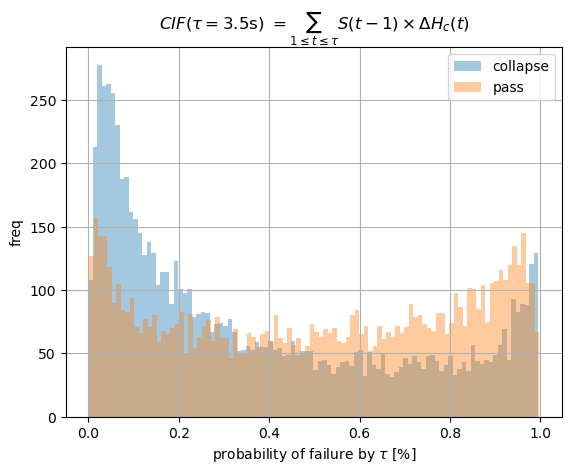

In [363]:
pred_surv_rate.loc[(X["pass_event"] | X["event"] | actual_survival), f"cif_c_{tau}_offdef"].hist(bins=100, label="collapse", alpha=.4)
pred_surv_rate.loc[(X["pass_event"] | X["event"] | actual_survival), f"cif_p_{tau}_offdef"].hist(bins=100, label="pass", alpha=.4)
plt.title(r"$CIF(\tau=$"+f"{tau/10:3.1f}s)"+r" $= \sum_{1 \leq t \leq \tau} S(t-1) \times \Delta H_c (t)$")
plt.ylabel("freq")
plt.xlabel(r"probability of failure by $\tau$ [%]")
plt.legend()
plt.show()

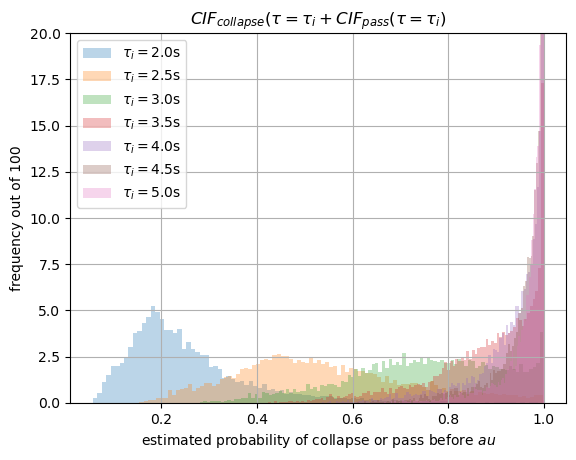

In [355]:
for tau in range(20,51,5):
    (pred_surv_rate[f"cif_c_{tau}_{team_feat}"] + pred_surv_rate[f"cif_p_{tau}_{team_feat}"]).hist(bins=100, density=True, label=r"$\tau_i=$" + f"{tau/10:3.1f}s", alpha=.3)
plt.title(r"$CIF_{collapse}(\tau=\tau_i + CIF_{pass} (\tau=\tau_i)$")
plt.xlabel("estimated probability of collapse or pass before $\tau$")
plt.ylabel("frequency out of 100")
plt.ylim(0,20)
plt.legend()
plt.show()

## first, we analyse which teams are expected to have longer or shorter pocket collapses (based on opponent + game context ) 

In [365]:
cct_off = pred_surv_rate.groupby("possessionTeam")[[f"cif_c_{tau}_def" for tau in range(20,51,5)]+[f"cif_p_{tau}_def" for tau in range(20,51,5)]].mean()
for tau in range(20,51,5):
    cct_off[f"tilt_{tau}" ] = cct_off[f"cif_c_{tau}_def"] / (cct_off[f"cif_c_{tau}_def"] + cct_off[f"cif_p_{tau}_def"]) # risk of collapse vs pass
cct_off.sort_values("tilt_30", ascending=True)

cif_c_20_def  cif_c_25_def  cif_c_30_def  cif_c_35_def  \
possessionTeam                                                           
PIT                 0.065214      0.137178      0.187688      0.222227   
TB                  0.083116      0.169811      0.228630      0.267905   
BAL                 0.084639      0.172220      0.230579      0.269579   
LA                  0.096430      0.191417      0.250968      0.288275   
ARI                 0.109447      0.210565      0.272561      0.312024   
KC                  0.107689      0.212781      0.280379      0.323596   
GB                  0.111417      0.216781      0.285388      0.331027   
CLE                 0.117418      0.231758      0.303101      0.347309   
BUF                 0.126689      0.239631      0.308680      0.352387   
CIN                 0.117219      0.231092      0.302717      0.348258   
NO                  0.135139      0.251681      0.319692      0.360876   
MIA                 0.121803      0.238124      0.310816      0.356167   
SF                  0.118945      0.234049      0.306530      0.352636   
NYG                 0.121349      0.238534      0.312454      0.359818   
CHI                 0.126291      0.243738      0.314770      0.359214   
WAS                 0.114951      0.227533      0.302092      0.353291   
PHI                 0.134005      0.257843      0.332501      0.377245   
NE                  0.140662      0.269122      0.347442      0.396120   
CAR                 0.140026      0.269742      0.347405      0.393749   
HOU                 0.158724      0.288216      0.360758      0.402702   
LV                  0.137749      0.269071      0.350476      0.399550   
TEN                 0.142104      0.271794      0.347735      0.392726   
ATL                 0.144461      0.279296      0.358649      0.404819   
DET                 0.139340      0.271909      0.354817      0.406607   
LAC                 0.140744      0.276341      0.358919      0.408904   
NYJ                 0.152792      0.285291      0.360916      0.405318   
DAL                 0.149686      0.280253      0.359787      0.409032   
DEN                 0.138527      0.272067      0.354531      0.405144   
SEA                 0.150873      0.292078      0.378056      0.430066   
IND                 0.149127      0.282826      0.362881      0.413328   
JAX                 0.148753      0.284259      0.367026      0.418948   
MIN                 0.177769      0.332885      0.422534      0.475840   

                cif_c_40_def  cif_c_45_def  cif_c_50_def  cif_p_20_def  \
possessionTeam                                                           
PIT                 0.242248      0.254207      0.261350      0.166446   
TB                  0.290520      0.304082      0.312192      0.158682   
BAL                 0.292325      0.306209      0.314683      0.154444   
LA                  0.308650      0.320415      0.327349      0.157740   
ARI                 0.334183      0.347135      0.354671      0.144118   
KC                  0.347470      0.361232      0.369187      0.149886   
GB                  0.357530      0.373447      0.382859      0.135226   
CLE                 0.370885      0.384008      0.391441      0.138668   
BUF                 0.377012      0.391658      0.400325      0.140973   
CIN                 0.373664      0.388545      0.397276      0.129780   
NO                  0.383029      0.395645      0.402878      0.148232   
MIA                 0.380661      0.394513      0.402423      0.132405   
SF                  0.378350      0.393482      0.402459      0.125401   
NYG                 0.386361      0.401905      0.410990      0.123583   
CHI                 0.384176      0.399159      0.408235      0.118164   
WAS                 0.384363      0.403939      0.416043      0.106068   
PHI                 0.400618      0.413670      0.421206      0.124568   
NE                  0.422541      0.437439      0.445776      0.132865   
CAR                

In [366]:
cct_def = pred_surv_rate.groupby("defensiveTeam")[[f"cif_c_{tau}_off" for tau in range(20,51,5)]+[f"cif_p_{tau}_off" for tau in range(20,51,5)]].mean()
for tau in range(20,51,5):
    cct_def[f"tilt_{tau}" ] = cct_def[f"cif_c_{tau}_off"] / (cct_def[f"cif_c_{tau}_off"] + cct_def[f"cif_p_{tau}_off"]) # risk of collapse vs pass
cct_def.sort_values("tilt_30", ascending=False)

cif_c_20_off  cif_c_25_off  cif_c_30_off  cif_c_35_off  \
defensiveTeam                                                           
PHI                0.145737      0.288505      0.378222      0.434060   
HOU                0.141498      0.273610      0.355775      0.409549   
MIA                0.154052      0.284975      0.363169      0.411837   
CAR                0.165101      0.295602      0.366970      0.408305   
TEN                0.136374      0.262575      0.340614      0.391208   
IND                0.142786      0.271989      0.349157      0.396992   
KC                 0.128443      0.252482      0.329285      0.378020   
WAS                0.135181      0.261343      0.339610      0.388851   
MIN                0.125619      0.246433      0.321755      0.369720   
LAC                0.114452      0.233275      0.312418      0.364868   
CLE                0.133413      0.259719      0.337015      0.384114   
TB                 0.134533      0.256440      0.331278      0.378820   
BUF                0.138673      0.261163      0.333932      0.377855   
DET                0.125580      0.239458      0.309094      0.354554   
DAL                0.129856      0.254284      0.329483      0.374762   
BAL                0.135637      0.258097      0.331026      0.374387   
LA                 0.138693      0.259654      0.329988      0.371090   
NYJ                0.136828      0.262138      0.335722      0.379042   
SF                 0.115409      0.227952      0.300380      0.348052   
LV                 0.122534      0.241554      0.314705      0.358922   
ATL                0.108738      0.216222      0.288232      0.337377   
JAX                0.130974      0.244960      0.311398      0.351821   
DEN                0.112745      0.225075      0.297606      0.344838   
NE                 0.136052      0.254030      0.321463      0.360618   
NYG                0.110726      0.221936      0.294216      0.341896   
SEA                0.120217      0.232994      0.301832      0.344806   
CIN                0.118754      0.231620      0.302124      0.347180   
CHI                0.113350      0.225488      0.297086      0.343202   
NO                 0.125494      0.235125      0.301792      0.343763   
PIT                0.098124      0.200820      0.270341      0.316942   
GB                 0.107603      0.212359      0.278821      0.321456   
ARI                0.104887      0.208736      0.274530      0.316103   

               cif_c_40_off  cif_c_45_off  cif_c_50_off  cif_p_20_off  \
defensiveTeam                                                           
PHI                0.463056      0.478144      0.486311      0.110170   
HOU                0.440511      0.458809      0.469943      0.099118   
MIA                0.438252      0.453036      0.461649      0.119911   
CAR                0.429486      0.440968      0.447642      0.123058   
TEN                0.419955      0.436689      0.446729      0.108385   
IND                0.422875      0.437413      0.446010      0.115658   
KC                 0.405075      0.420707      0.430262      0.116500   
WAS                0.415425      0.430148      0.438702      0.119556   
MIN                0.396111      0.411083      0.420030      0.111193   
LAC                0.394761      0.412385      0.423248      0.111412   
CLE                0.408558      0.421676      0.429142      0.129461   
TB                 0.405050      0.419938      0.428716      0.130169   
BUF                0.400659      0.413067      0.420293      0.129612   
DET                0.381092      0.397295      0.407575      0.117034   
DAL                0.397876      0.410004      0.416811      0.137484   
BAL                0.396357      0.407948      0.414529      0.136137   
LA                 0.391368      0.401828      0.407763      0.133727   
NYJ                0.400841      0.412215      0.418527      0.145048   
SF                 0.374879      0.390102      0.398992      0.120988   

In [367]:
tau=30
agg_cols = [f"cif_p_{tau}_def", f"cif_c_{tau}_def", f"tilt_expected_{tau}_def", f"pass_before_tau_{tau}_def", f"pass_residual_{tau}_def", f"collapse_before_tau_{tau}_def",  f"collapse_residual_{tau}_def", f"surv_tau_{tau}_def", f"surv_residual_{tau}_def"]

res_off = pred_surv_rate.groupby("possessionTeam")[agg_cols].mean()
res_off["tilt_actual"] = res_off[f"collapse_before_tau_{tau}_def"] / (res_off[f"collapse_before_tau_{tau}_def"] + res_off[f"pass_before_tau_{tau}_def"])
res_off.sort_values(f"tilt_actual", ascending=True)

cif_p_30_def  cif_c_30_def  tilt_expected_30_def  \
possessionTeam                                                     
PIT                 0.553366      0.187688              0.265448   
CIN                 0.439734      0.302717              0.403905   
TB                  0.516640      0.228630              0.318310   
GB                  0.449569      0.285388              0.390499   
CLE                 0.450325      0.303101              0.396870   
DEN                 0.385168      0.354531              0.461691   
CHI                 0.416949      0.314770              0.415416   
LA                  0.506632      0.250968              0.332277   
ATL                 0.415066      0.358649              0.452249   
TEN                 0.409083      0.347735              0.442775   
WAS                 0.387539      0.302092              0.426960   
LAC                 0.399547      0.358919              0.463032   
KC                  0.477949      0.280379              0.375882   
SF                  0.425606      0.306530              0.409472   
NE                  0.419000      0.347442              0.451792   
DAL                 0.396106      0.359787              0.462932   
MIA                 0.439911      0.310816              0.408419   
NYJ                 0.399052      0.360916              0.453809   
LV                  0.415094      0.350476              0.449938   
ARI                 0.475413      0.272561              0.360305   
DET                 0.395720      0.354817              0.462184   
HOU                 0.430224      0.360758              0.445265   
MIN                 0.334633      0.422534              0.534638   
NYG                 0.423338      0.312454              0.417820   
PHI                 0.420091      0.332501              0.426772   
NO                  0.454917      0.319692              0.408860   
CAR                 0.416562      0.347405              0.443381   
IND                 0.367423      0.362881              0.476186   
JAX                 0.370904      0.367026              0.479251   
SEA                 0.383731      0.378056              0.485543   
BAL                 0.498007      0.230579              0.321348   
BUF                 0.449090      0.308680              0.407809   

                pass_before_tau_30_def  pass_residual_30_def  \
possessionTeam                                                 
PIT                           0.606987              0.053621   
CIN                           0.552846              0.113111   
TB                            0.528239              0.011599   
GB                            0.506977              0.057407   
CLE                           0.463203              0.012879   
DEN                           0.487365              0.102197   
CHI                           0.483193              0.066244   
LA                            0.475410             -0.031222   
ATL                           0.532847              0.117780   
TEN                           0.509363              0.100281   
WAS                           0.424561              0.037022   
LAC                           0.505792              0.106245   
KC                            0.435045             -0.042904   
SF                            0.454976              0.029371   
NE                            0.474820              0.055820   
DAL                           0.484252              0.088146   
MIA                           0.459459              0.019548   
NYJ                           0.467433              0.068381   
LV                            0.464567              0.049473   
ARI                           0.401747             -0.073666   
DET                           0.456869              0.061149   
HOU                           0.455319              0.025095   
MIN                           0.444898              0.110265   
NYG                           0.435986              0.012648   
PHI                           0.362140 

In [392]:
tau=25
agg_cols_def = [f"cif_p_{tau}_off", f"cif_c_{tau}_off",  f"tilt_expected_{tau}_def", f"pass_before_tau_{tau}_off", f"pass_residual_{tau}_off", f"collapse_before_tau_{tau}_off",  f"collapse_residual_{tau}_off", f"surv_tau_{tau}_off", f"surv_residual_{tau}_off"]

res_def = pred_surv_rate.groupby("defensiveTeam")[agg_cols_def].mean()
res_def.sort_values(f"collapse_residual_{tau}_off", ascending=False)


cif_p_25_off  cif_c_25_off  tilt_expected_25_def  \
defensiveTeam                                                     
CAR                0.278843      0.295602              0.503261   
CLE                0.292946      0.259719              0.447564   
ATL                0.273470      0.216222              0.417035   
DAL                0.303745      0.254284              0.447025   
MIA                0.270782      0.284975              0.497581   
BAL                0.303904      0.258097              0.469414   
TEN                0.253807      0.262575              0.447468   
KC                 0.260873      0.252482              0.464543   
MIN                0.261997      0.246433              0.484873   
LAC                0.259493      0.233275              0.491023   
LA                 0.304415      0.259654              0.434763   
PIT                0.304027      0.200820              0.368783   
SEA                0.302413      0.232994              0.442883   
PHI                0.253733      0.288505              0.463770   
TB                 0.290600      0.256440              0.417709   
NE                 0.331493      0.254030              0.455241   
HOU                0.233609      0.273610              0.510315   
SF                 0.282419      0.227952              0.449256   
BUF                0.294175      0.261163              0.411982   
JAX                0.311550      0.244960              0.384057   
DET                0.269769      0.239458              0.468648   
NYJ                0.319277      0.262138              0.406907   
IND                0.265332      0.271989              0.466141   
CHI                0.309829      0.225488              0.404353   
NYG                0.294250      0.221936              0.425464   
CIN                0.310593      0.231620              0.388014   
NO                 0.319463      0.235125              0.424616   
LV                 0.307004      0.241554              0.418592   
WAS                0.274222      0.261343              0.420203   
DEN                0.292119      0.225075              0.377197   
GB                 0.324964      0.212359              0.368584   
ARI                0.340881      0.208736              0.377994   

               pass_before_tau_25_off  pass_residual_25_off  \
defensiveTeam                                                 
CAR                          0.339921              0.061078   
CLE                          0.303644              0.010697   
ATL                          0.247748             -0.025722   
DAL                          0.287402             -0.016344   
MIA                          0.277193              0.006411   
BAL                          0.334677              0.030774   
TEN                          0.289116              0.035309   
KC                           0.282869              0.021995   
MIN                          0.262500              0.000503   
LAC                          0.269767              0.010275   
LA                           0.361842              0.057427   
PIT                          0.395745              0.091718   
SEA                          0.272109             -0.030304   
PHI                          0.345382              0.091648   
TB                           0.379747              0.089147   
NE                           0.256506             -0.074988   
HOU                          0.275556              0.041947   
SF                           0.306306              0.023888   
BUF                          0.287500             -0.006675   
JAX                          0.333333              0.021784   
DET                          0.240741             -0.029029   
NYJ                          0.383333              0.064057   
IND                          0.290076              0.024745   
CHI                          0.354978              0.045149   
NYG                          0.283636             -0.010613   
CIN                          0.2834

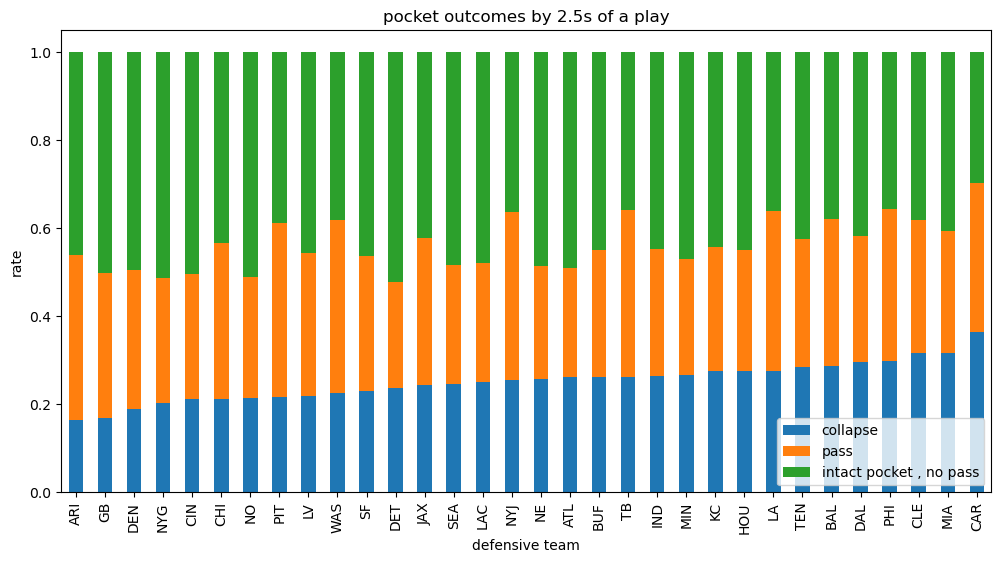

In [393]:
fig, ax = plt.subplots(1,1,  figsize=(12,6))
res_def[[f"collapse_before_tau_{tau}_off", f"pass_before_tau_{tau}_off", f"surv_tau_{tau}_off"]].sort_values(f"collapse_before_tau_{tau}_off").plot.bar(stacked=True, ax=ax)
ax.legend(["collapse", "pass", "intact pocket , no pass"], loc="lower right")
plt.xlabel("defensive team")
plt.ylabel("rate")
plt.title(f"pocket outcomes by {tau/10:3.1f}s of a play")
plt.show()

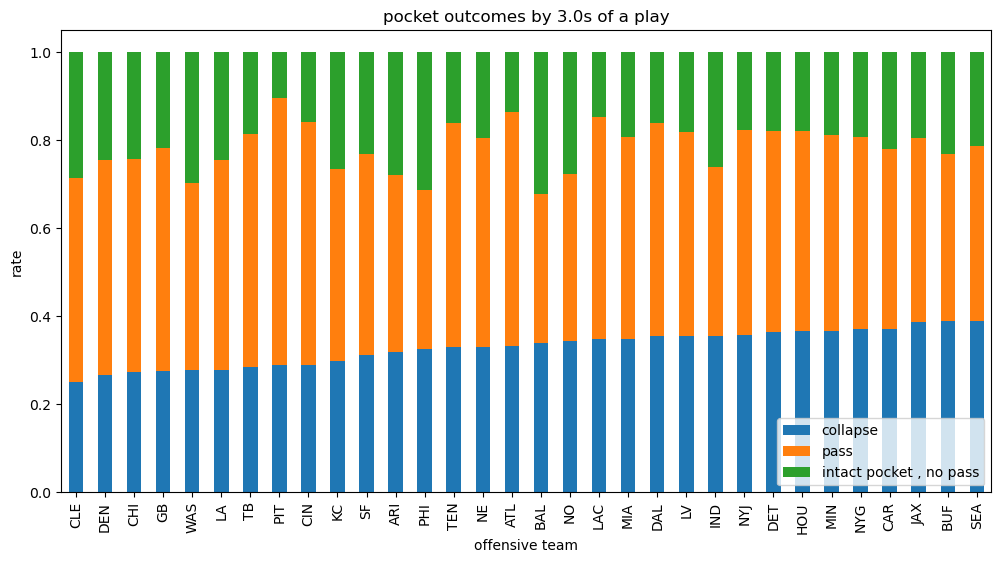

In [391]:
tau=30
fig, ax = plt.subplots(1,1,  figsize=(12,6))
res_off[[f"collapse_before_tau_{tau}_def", f"pass_before_tau_{tau}_def", f"surv_tau_{tau}_def"]].sort_values(f"collapse_before_tau_{tau}_def").plot.bar(stacked=True, ax=ax)
ax.legend(["collapse", "pass", "intact pocket , no pass"], loc="lower right")
plt.xlabel("offensive team")
plt.ylabel("rate")
plt.title(f"pocket outcomes by {tau/10:3.1f}s of a play")
plt.show()

In [370]:
player_pocket_uptime = pd.merge(
    scouting[scouting.pff_role.isin(["Pass", "Pass Rush", "Pass Block"])][
        ["gameId", "playId", "nflId", "pff_role"]
    ],
    pred_surv_rate,
    how="right",
    on=["gameId", "playId"],
)

In [ ]:
def_time_delta = []

for tau in range(20,41,5): 
    agg_cols_delta_def = [f"cif_p_{tau}_off", f"cif_c_{tau}_off", f"pass_before_tau_{tau}_off", f"collapse_before_tau_{tau}_off", f"surv_tau_{tau}_off"]

    delta_def = pred_surv_rate.groupby("defensiveTeam")[agg_cols_delta_def].mean()
    delta_def["tau"] = tau/10
    delta_def["exp_surv"] = 1 - delta_def[f"cif_p_{tau}_off"] - delta_def[f"cif_c_{tau}_off"]
    delta_def.rename(columns={
        c: c[:-7] for c in agg_cols_delta_def
    }, inplace=True)
    def_time_delta.append(delta_def.reset_index())

delta_def = pd.concat(def_time_delta, ignore_index=True)


In [743]:
delta_def["collapse_res"] = delta_def.collapse_before_tau - delta_def.cif_c
delta_def[delta_def.tau==3].sort_values("exp_surv", ascending=False).drop(columns=["tau"])

defensiveTeam     cif_p     cif_c  pass_before_tau  collapse_before_tau  \
65           ATL  0.414811  0.288232         0.445946             0.306306   
81           LAC  0.392895  0.312418         0.390698             0.316279   
76           HOU  0.357501  0.355775         0.435556             0.346667   
74           DET  0.405684  0.309094         0.398148             0.305556   
79            KC  0.387678  0.329285         0.394422             0.342629   
84           MIN  0.400073  0.321755         0.425000             0.358333   
94           TEN  0.384562  0.340614         0.418367             0.357143   
87           NYG  0.431312  0.294216         0.458182             0.272727   
92            SF  0.426726  0.300380         0.441441             0.337838   
90           PIT  0.457067  0.270341         0.557447             0.289362   
73           DEN  0.433940  0.297606         0.518072             0.269076   
77           IND  0.394532  0.349157         0.431298             0.370229   
91           SEA  0.444199  0.301832         0.442177             0.346939   
95           WAS  0.407158  0.339610         0.511475             0.324590   
69           CHI  0.452836  0.297086         0.506494             0.277056   
93            TB  0.421534  0.331278         0.484177             0.322785   
70           CIN  0.450732  0.302124         0.439252             0.292835   
75            GB  0.474434  0.278821         0.498113             0.264151   
89           PHI  0.377398  0.378222         0.477912             0.369478   
83           MIA  0.396411  0.363169         0.407018             0.403509   
86            NO  0.460686  0.301792         0.403101             0.294574   
64           ARI  0.487966  0.274530         0.538776             0.240816   
82            LV  0.448424  0.314705         0.482759             0.295019   
78           JAX  0.452959  0.311398         0.464789             0.291080   
67           BUF  0.431272  0.333932         0.445833             0.341667   
71           CLE  0.428215  0.337015         0.429150             0.400810   
72           DAL  0.438224  0.329483         0.433071             0.385827   
66           BAL  0.441375  0.331026         0.467742             0.362903   
80            LA  0.445972  0.329988         0.460526             0.342105   
68           CAR  0.409163  0.366970         0.438735             0.415020   
88           NYJ  0.454254  0.335722         0.525000             0.333333   
85            NE  0.470334  0.321463         0.423792             0.345725   

    surv_tau  exp_surv  collapse_res  
65  0.247748  0.296957      0.018075  
81  0.293023  0.294688      0.003862  
76  0.217778  0.286725     -0.009108  
74  0.296296  0.285221     -0.003539  
79  0.262948  0.283037      0.013345  
84  0.216667  0.278172      0.036579  
94  0.224490  0.274824      0.016529  
87  0.269091  0.274473     -0.021488  
92  0.220721  0.272894      0.037457  
90  0.153191  0.272593      0.019021  
73  0.212851  0.268454     -0.028530  
77  0.198473  0.256311      0.021072  
91  0.210884  0.253969      0.045107  
95  0.163934  0.253232     -0.015020  
69  0.216450  0.250079     -0.020029  
93  0.193038  0.247187     -0.008494  
70  0.267913  0.247145     -0.009289  
75  0.237736  0.246745     -0.014670  
89  0.152610  0.244379     -0.008745  
83  0.189474  0.240420      0.040340  
86  0.302326  0.237522     -0.007218  
64  0.220408  0.237504     -0.033713  
82  0.222222  0.236871     -0.019686  
78  0.244131  0.235643     -0.020318  
67  0.212500  0.234796      0.007734  
71  0.170040  0.234770      0.063795  
72  0.181102  0.232293      0.056343  
66  0.169355  0.227599      0.031878  
80  0.197368  0.224040      0.012117  
68  0.146245  0.223868      0.048050  
88  0.141667  0.210024     -0.002388  
85  0.230483  0.208203      0.024262

In [ ]:
# team logos are from nflgamedata.com
logo_dict = {tname:imread(f"team_logos/{tname}.png") for tname in delta_def.defensiveTeam.unique()}


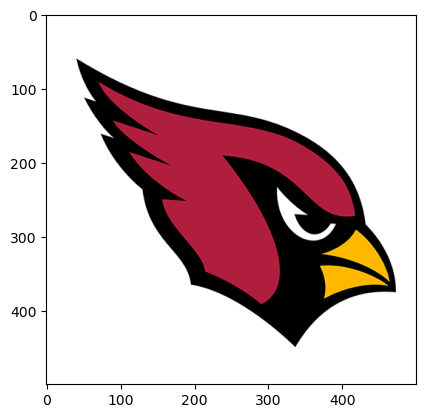

In [797]:
plt.imshow(logo_dict["ARI"])

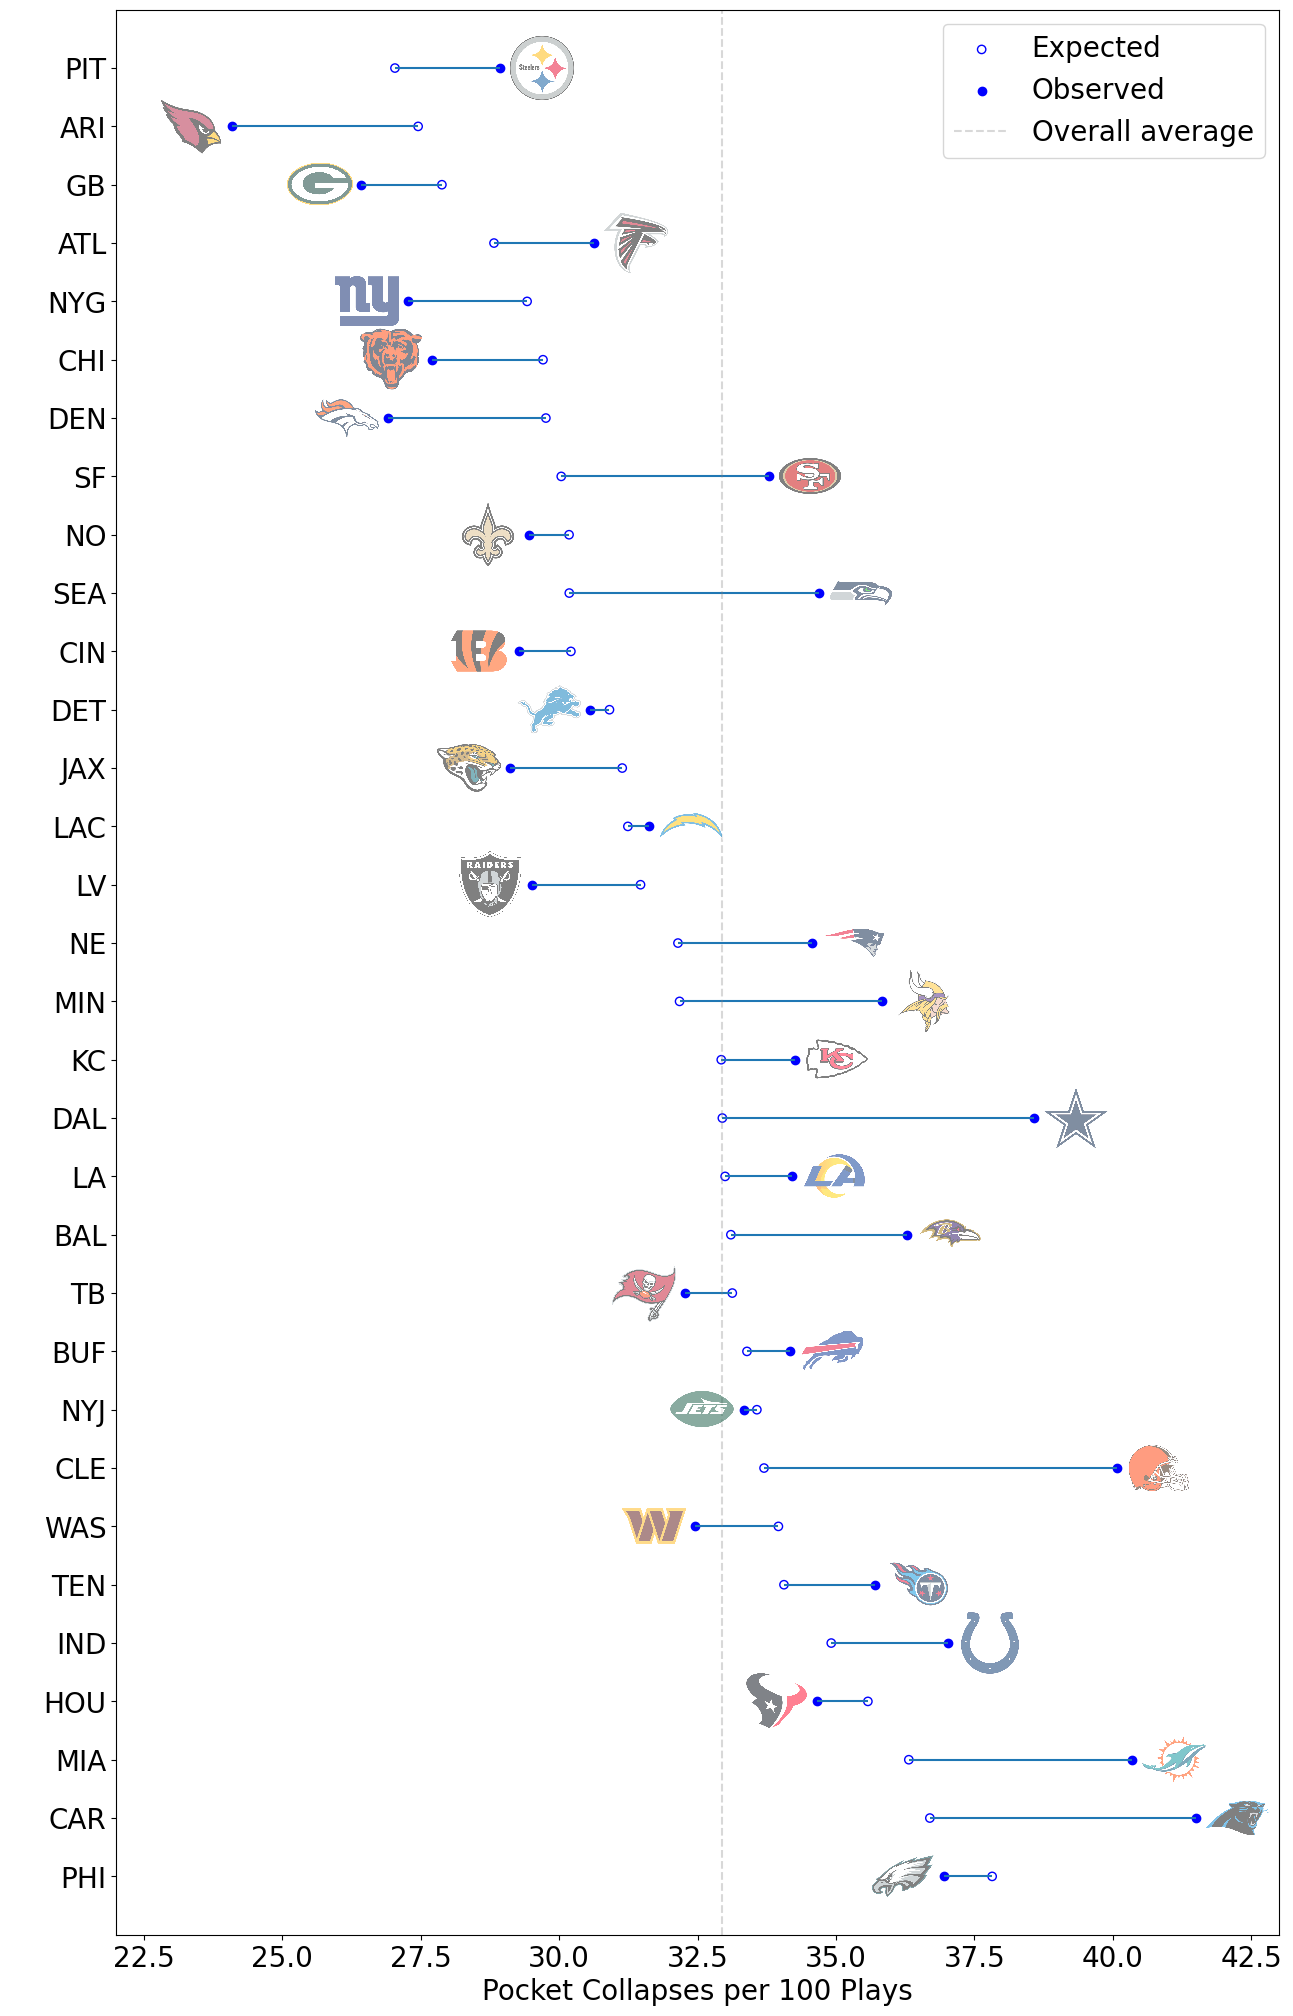

In [833]:
plotdata = delta_def[delta_def.tau == 3].sort_values("cif_c", ascending=False)
with plt.style.context({"font.size":20}):
    fig, ax = plt.subplots(figsize=(15, 25))

    for i, (ix, row) in enumerate(plotdata.iterrows()):
        abbr = row["defensiveTeam"]
        x0 = float(row["cif_c"]*100)
        x1 = float(row["collapse_before_tau"]*100)
        if x0 > x1: 
            x = x1 - .75
        else: 
            x = x1 + .75
        if abbr in logo_dict and os.path.exists(f"team_logos/{abbr}.png"):
            if abbr in ["LV", "GB"]: 
                zm = 0.0125
            else: 
                zm = 0.1
            im = OffsetImage(logo_dict[abbr], zoom=zm, alpha=.5)
            ab = AnnotationBbox(im, (x, i), frameon=False, box_alignment=(0.5, 0.5),  bboxprops=dict(alpha=0.5))
            ax.add_artist(ab)
        else:
            ax.plot(x, i, 'o', markersize=8)
                
    ax.hlines(
        y=np.arange(32),
        xmin=plotdata
        .cif_c.values
        * 100,
        xmax=plotdata
        .collapse_before_tau.values
        * 100,
    )

    ax.scatter(
        x=plotdata.cif_c.values
        * 100,
        y=np.arange(32),
        marker="o",
        label="Expected",
        color="blue",
        facecolor="none"
    )

    ax.scatter(
        x=plotdata
        .collapse_before_tau.values
        * 100,
        y=np.arange(32),
        marker="o",
        label="Observed",
        color="blue"
    )

    ax.vlines(
        [pred_surv_rate.collapse_before_tau_30_off.mean() * 100],
        -1,
        33,
        alpha=0.3,
        color="gray",
        linestyle="dashed",
        label="Overall average",
    )


    ax.set_yticks(np.arange(32))
    ax.set_yticklabels(plotdata.defensiveTeam.values)

    plt.legend()
    plt.ylim(-1, 32)
    plt.xlim(22, 43)
    plt.ylabel(" ")
    plt.xlabel("Pocket Collapses per 100 Plays")
    plt.show()

C:\Users\mschilling\AppData\Local\Temp\ipykernel_21088\2118892731.py:17: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



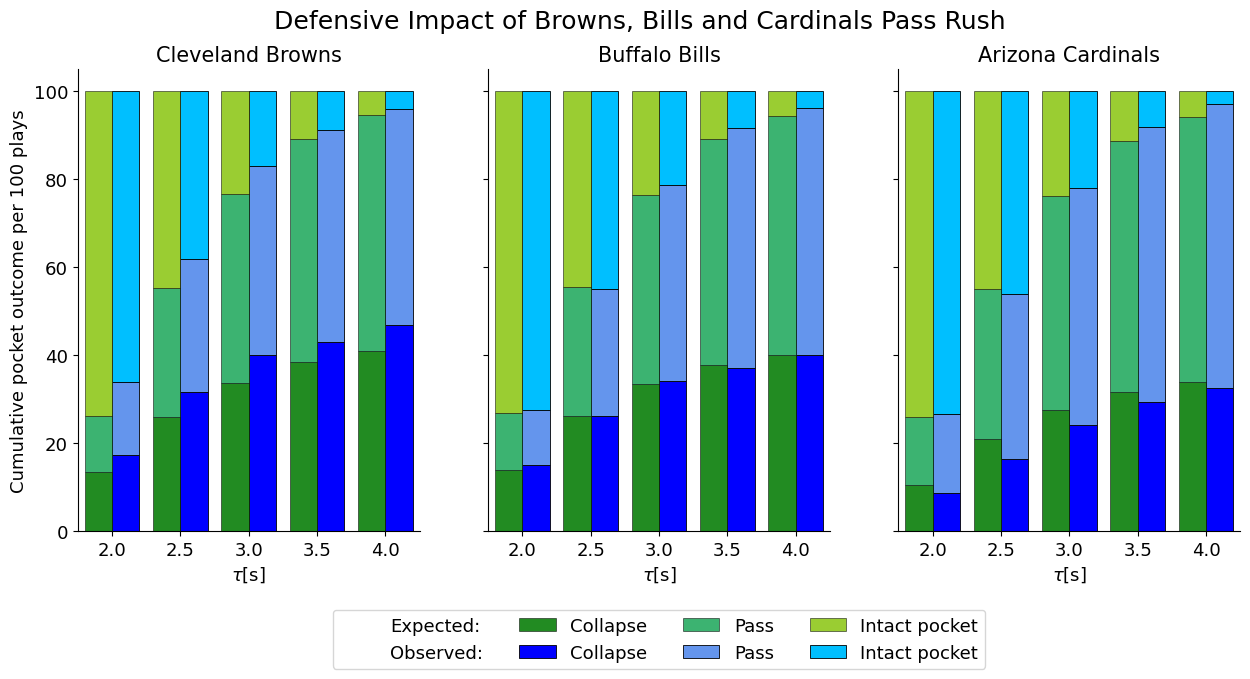

In [698]:
with plt.style.context({"font.size":13}):
    fig, ax = plt.subplots(1,3, figsize=(15,6), sharey=True)

    delta_def.loc[delta_def.defensiveTeam=="CLE", ["collapse_before_tau", "pass_before_tau", "surv_tau", "tau"]].set_index("tau").plot.bar(stacked=True, ax=ax[0], legend=False, width=.4, rot=0,align="edge", color=['blue', "cornflowerblue",  'deepskyblue'], edgecolor='k', linewidth=0.6)
    delta_def.loc[delta_def.defensiveTeam=="BUF", ["collapse_before_tau", "pass_before_tau", "surv_tau", "tau"]].set_index("tau").plot.bar(stacked=True, ax=ax[1], width=.4, rot=0,align="edge", color=['blue', "cornflowerblue",  'deepskyblue'], edgecolor='k', linewidth=0.6)
    delta_def.loc[delta_def.defensiveTeam=="ARI", ["collapse_before_tau", "pass_before_tau", "surv_tau", "tau"]].set_index("tau").plot.bar(stacked=True, ax=ax[2], legend=False, width=.4, rot=0,align="edge", color=['blue', "cornflowerblue",  'deepskyblue'], edgecolor='k', linewidth=0.6)

    delta_def.loc[delta_def.defensiveTeam=="CLE", ["cif_c", "cif_p", "exp_surv", "tau"]].set_index("tau").plot.bar(stacked=True, ax=ax[0], legend=False, width=-0.4, rot=0,align="edge", color=["forestgreen", "mediumseagreen", "yellowgreen"], edgecolor=(0,0,0,0.6), linewidth=0.6)
    delta_def.loc[delta_def.defensiveTeam=="BUF", ["cif_c", "cif_p", "exp_surv", "tau"]].set_index("tau").plot.bar(stacked=True, ax=ax[1], width=-0.4, rot=0,align="edge", color=["forestgreen", "mediumseagreen", "yellowgreen"], edgecolor=(0,0,0,0.6), linewidth=0.6)
    delta_def.loc[delta_def.defensiveTeam=="ARI", ["cif_c", "cif_p", "exp_surv", "tau"]].set_index("tau").plot.bar(stacked=True, ax=ax[2], legend=False, width=-0.4, rot=0,align="edge", color=["forestgreen", "mediumseagreen", "yellowgreen"], edgecolor=(0,0,0,0.6), linewidth=0.6)

    ax[0].set_title("Cleveland Browns", fontsize=15)
    ax[0].tick_params("x")
    ax[0].set_xlabel(r"$\tau$[s]")
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].set_yticklabels(["0", "20", "40", "60", "80", "100"])
    ax[0].set_ylabel("Cumulative pocket outcome per 100 plays")
    ax[0].set_xlim(-0.5, 4.5)
    # s0 = ax[0].secondary_xaxis(location = 0)
    # s0.set_xticks([-0.25, .25, .75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25], ["Ex", "Obs"]*5)
    # s0.tick_params("x", length=0)

    ax[1].set_title("Buffalo Bills", fontsize=15)
    ax[1].tick_params("x")
    ax[1].set_xlabel(r"$\tau$[s]")
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    lbls = ["Collapse", "Pass", "Intact pocket", "Collapse", "Pass", "Intact pocket"]
    row_titles = ["Expected:", "Observed:"]
    hdls, _ = ax[1].get_legend_handles_labels()
    dummy_handles = [plt.Line2D([], [], linestyle='', marker=''), plt.Line2D([], [], linestyle='', marker='')]
    hdls = hdls+dummy_handles
    lbls = lbls + row_titles
    ixs = [6,7,3,0,4,1,5,2]
    ax[1].legend(
        [hdls[i] for i in ixs], 
        [lbls[i] for i in ixs], 
        loc="upper center", 
        ncols=4, 
        bbox_to_anchor=(0.5,-.15))

    ax[1].set_xlim(-0.5, 4.5)
    # s1 = ax[1].secondary_xaxis(location = 0)
    # s1.set_xticks([-0.25, .25, .75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25], ["Ex", "Obs"]*5)
    # s1.tick_params("x", length=0)

    ax[2].set_title("Arizona Cardinals", fontsize=15)
    ax[2].tick_params("x")
    ax[2].set_xlabel(r"$\tau$[s]")
    ax[2].spines['top'].set_visible(False)
    ax[2].spines['right'].set_visible(False)

    ax[2].set_xlim(-0.5, 4.5)
    # s2 = ax[2].secondary_xaxis(location = 0)
    # s2.set_xticks([-0.25, .25, .75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25], ["Ex", "Obs"]*5)
    # s2.tick_params("x", length=0)

    fig.suptitle("Defensive Impact of Browns, Bills and Cardinals Pass Rush", fontsize=18)
    plt.savefig("stacked_outcomes.svg", dpi=600)

In [727]:
delta_def

defensiveTeam     cif_p     cif_c  pass_before_tau  collapse_before_tau  \
0            ARI  0.154160  0.104887         0.179592             0.085714   
1            BUF  0.129612  0.138673         0.125000             0.150000   
2            CLE  0.129461  0.133413         0.165992             0.174089   
3            ARI  0.340881  0.208736         0.375510             0.163265   
4            BUF  0.294175  0.261163         0.287500             0.262500   
5            CLE  0.292946  0.259719         0.303644             0.315789   
6            ARI  0.487966  0.274530         0.538776             0.240816   
7            BUF  0.431272  0.333932         0.445833             0.341667   
8            CLE  0.428215  0.337015         0.429150             0.400810   
9            ARI  0.571683  0.316103         0.624490             0.293878   
10           BUF  0.512826  0.377855         0.545833             0.370833   
11           CLE  0.508000  0.384114         0.481781             0.429150   
12           ARI  0.602556  0.338756         0.644898             0.326531   
13           BUF  0.543481  0.400659         0.562500             0.400000   
14           CLE  0.537585  0.408558         0.489879             0.469636   

    surv_tau  tau  exp_surv  
0   0.734694  2.0  0.740953  
1   0.725000  2.0  0.731716  
2   0.659919  2.0  0.737126  
3   0.461224  2.5  0.450383  
4   0.450000  2.5  0.444662  
5   0.380567  2.5  0.447335  
6   0.220408  3.0  0.237504  
7   0.212500  3.0  0.234796  
8   0.170040  3.0  0.234770  
9   0.081633  3.5  0.112215  
10  0.083333  3.5  0.109319  
11  0.089069  3.5  0.107886  
12  0.028571  4.0  0.058687  
13  0.037500  4.0  0.055860  
14  0.040486  4.0  0.053857

In [647]:
hdls, lbls = ax[1].get_legend_handles_labels()

In [654]:
ixs

[3, 0, 4, 1, 5, 2]

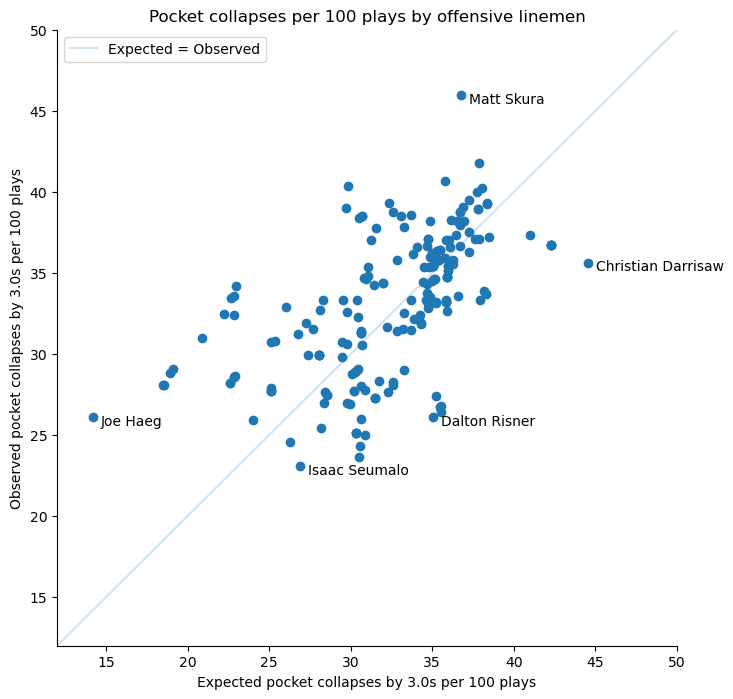

In [686]:
plt.figure(figsize=(8,8))
plt.scatter(
    ppu.loc[(ppu.num_snaps > 50) & (ppu.officialPosition.isin(["C", "T", "G"])), f"cif_c_{ppu_tau}_def"].values*100,
    ppu.loc[(ppu.num_snaps > 50) & (ppu.officialPosition.isin(["C", "T", "G"])), f"collapse_before_tau_{ppu_tau}_def"].values*100,
    )


# plt.axis("equal")
plt.xlabel(f"Expected pocket collapses by {ppu_tau/10:3.1f}s per 100 plays")
plt.ylabel(f"Observed pocket collapses by {ppu_tau/10:3.1f}s per 100 plays")
plt.title("Pocket collapses per 100 plays by offensive linemen")
plt.plot([0,100],[0,100], alpha=.2, label="Expected = Observed")
plt.xlim(12,50)
plt.ylim(12,50)

annotation_df = pd.concat([
    ppu.loc[(ppu.num_snaps > 50) & (ppu.officialPosition.isin(["C", "T", "G"]))].sort_values(f"collapse_before_tau_{ppu_tau}_def", ascending=True).head(1),
    ppu.loc[(ppu.num_snaps > 50) & (ppu.officialPosition.isin(["C", "T", "G"]))].sort_values(f"collapse_before_tau_{ppu_tau}_def", ascending=False).head(1),
    ppu.loc[(ppu.num_snaps > 50) & (ppu.officialPosition.isin(["C", "T", "G"]))].sort_values(f"cif_c_{ppu_tau}_def", ascending=True).head(1),
    ppu.loc[(ppu.num_snaps > 50) & (ppu.officialPosition.isin(["C", "T", "G"]))].sort_values(f"cif_c_{ppu_tau}_def", ascending=True).tail(1),
    ppu[ppu.displayName.isin(["Dalton Risner"])]
])

for ix, plyr in annotation_df.iterrows(): 
    plt.annotate(text=plyr["displayName"], xy=plyr[[f"cif_c_{ppu_tau}_def", f"collapse_before_tau_{ppu_tau}_def"]].values*100+(.5, -.5))

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend()
plt.savefig("olines.svg", dpi=600)




In [573]:
ppu_tau=30
ppu_team_feat = "def"
ppu = player_pocket_uptime.groupby("nflId").agg(
    {
        f"cif_p_{ppu_tau}_{ppu_team_feat}":"mean",
        f"cif_c_{ppu_tau}_{ppu_team_feat}":"mean",
        f"pass_before_tau_{ppu_tau}_{ppu_team_feat}":"mean",
        f"pass_residual_{ppu_tau}_{ppu_team_feat}":"mean",
        f"collapse_before_tau_{ppu_tau}_{ppu_team_feat}":"mean",
        f"collapse_residual_{ppu_tau}_{ppu_team_feat}":"mean",
        f"surv_tau_{ppu_tau}_{ppu_team_feat}":"mean",
        f"surv_residual_{ppu_tau}_{ppu_team_feat}":"mean",        
        f"playId": "count",
        "defensiveTeam": pd.Series.mode,
        "possessionTeam":pd.Series.mode,
    }
).rename(columns={"playId": "num_snaps"}).sort_values(
    f"collapse_residual_{ppu_tau}_{ppu_team_feat}", ascending=True
).reset_index().merge(
    players, on="nflId"
).drop(columns=["collegeName", "height", "weight", "birthDate"])

In [695]:
ppu[(ppu.num_snaps>50) & (ppu.officialPosition.isin(["C", "T", "G", "TE", "RB"]))].sort_values(
    f"collapse_residual_{ppu_tau}_{ppu_team_feat}", ascending=True
).head(25).drop(columns=["nflId", "defensiveTeam"])[["displayName", "possessionTeam", f"collapse_residual_{ppu_tau}_{ppu_team_feat}", f"cif_c_{ppu_tau}_{ppu_team_feat}", f"collapse_before_tau_{ppu_tau}_{ppu_team_feat}"]]

displayName possessionTeam  collapse_residual_30_def  \
189      Graham Glasgow            DEN                 -0.091287   
198       Dalton Risner            DEN                 -0.089564   
202  Christian Darrisaw            MIN                 -0.088823   
208       Garett Bolles            DEN                 -0.087952   
210   Lloyd Cushenberry            DEN                 -0.087383   
211        Bobby Massie            DEN                 -0.087383   
229         Netane Muti            DEN                 -0.078412   
249    Elijah Wilkinson            CHI                 -0.068872   
268        Jack Conklin            CLE                 -0.062501   
284      Elgton Jenkins             GB                 -0.058581   
297    Garrett Bradbury            MIN                 -0.055187   
298       Brian O'Neill            MIN                 -0.055187   
299     Olisaemeka Udoh            MIN                 -0.055187   
301      Ezra Cleveland            MIN                 -0.055187   
314        J.C. Tretter            CLE                 -0.052019   
315        Joel Bitonio            CLE                 -0.052019   
316        Wyatt Teller            CLE                 -0.052019   
333       Germain Ifedi            CHI                 -0.046422   
336      Wes Schweitzer            WAS                 -0.046026   
337          Matt Pryor            IND                 -0.045959   
338       La'el Collins            DAL                 -0.045625   
339    Xavier Su'a-Filo            CIN                 -0.045498   
346      Brandon Parker             LV                 -0.043358   
348     Connor McGovern            DAL                 -0.042874   
350       Jedrick Wills            CLE                 -0.042510   

     cif_c_30_def  collapse_before_tau_30_def  
189      0.355536                    0.264249  
198      0.350433                    0.260870  
202      0.445144                    0.356322  
208      0.355610                    0.267658  
210      0.354531                    0.267148  
211      0.354531                    0.267148  
229      0.352222                    0.273810  
249      0.305235                    0.236364  
268      0.305556                    0.243056  
284      0.308581                    0.250000  
297      0.422534                    0.367347  
298      0.422534                    0.367347  
299      0.422534                    0.367347  
301      0.422534                    0.367347  
314      0.303101                    0.251082  
315      0.303101                    0.251082  
316      0.303101                    0.251082  
333      0.322844                    0.276423  
336      0.306141                    0.260116  
337      0.382694                    0.336735  
338      0.378958                    0.333333  
339      0.326200                    0.280702  
346      0.326186                    0.282828  
348      0.381857                    0.338983  
350      0.332365                    0.289855

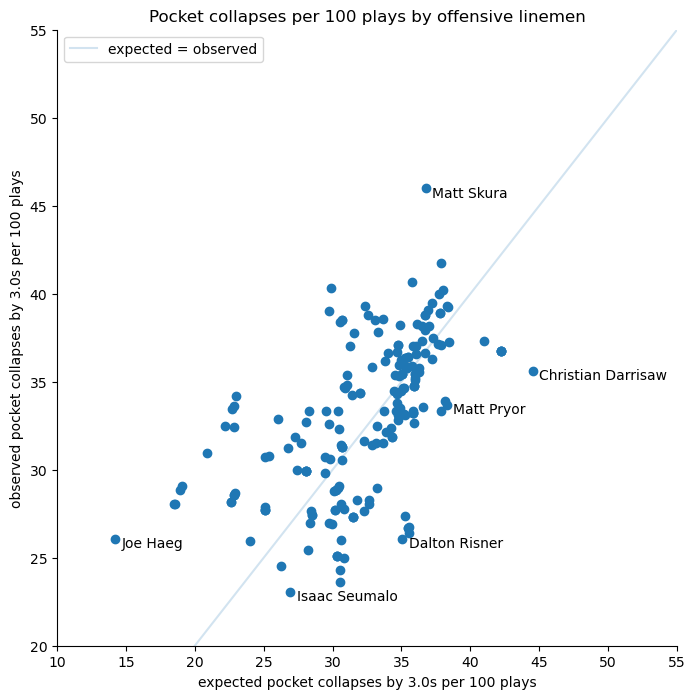

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(
    ppu.loc[(ppu.num_snaps > 50) & (ppu.officialPosition.isin(["C", "T", "G"])), f"cif_c_{ppu_tau}_def"].values*100,
    ppu.loc[(ppu.num_snaps > 50) & (ppu.officialPosition.isin(["C", "T", "G"])), f"collapse_before_tau_{ppu_tau}_def"].values*100,
    )


# plt.axis("equal")
plt.xlabel(f"expected pocket collapses by {ppu_tau:3.1f}s per 100 plays")
plt.ylabel(f"observed pocket collapses by {ppu_tau:3.1f}s per 100 plays")
plt.title("Pocket collapses per 100 plays by offensive linemen")
plt.plot([0,100],[0,100], alpha=.2, label="expected = observed")
plt.xlim(10,55)
plt.ylim(20,55)

annotation_df = pd.concat([
    ppu.loc[(ppu.num_snaps > 50) & (ppu.officialPosition.isin(["C", "T", "G"]))].sort_values(f"collapse_before_tau_{ppu_tau}_def", ascending=True).head(1),
    ppu.loc[(ppu.num_snaps > 50) & (ppu.officialPosition.isin(["C", "T", "G"]))].sort_values(f"collapse_before_tau_{ppu_tau}_def", ascending=False).head(1),
    ppu.loc[(ppu.num_snaps > 50) & (ppu.officialPosition.isin(["C", "T", "G"]))].sort_values(f"cif_c_{ppu_tau}_def", ascending=True).head(1),
    ppu.loc[(ppu.num_snaps > 50) & (ppu.officialPosition.isin(["C", "T", "G"]))].sort_values(f"cif_c_{ppu_tau}_def", ascending=True).tail(1),
    ppu[ppu.displayName.isin(["Matt Pryor", "Dalton Risner"])]
])

for ix, plyr in annotation_df.iterrows(): 
    plt.annotate(text=plyr["displayName"], xy=plyr[[f"cif_c_{ppu_tau}_def", f"collapse_before_tau_{ppu_tau}_def"]].values*100+(.5, -.5))

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend()
plt.savefig("olines.svg")




In [482]:
ppu[(ppu.num_snaps>100) & (ppu.officialPosition.isin(["DT", "OLB", "ILB", "DE"]))].sort_values(
    f"collapse_residual_{ppu_tau}_{ppu_team_feat}", ascending=0
).head(25).drop(columns=["nflId", "possessionTeam"])

cif_p_25_def  cif_c_25_def  pass_before_tau_25_def  \
1041      0.295523      0.279168                0.323529   
1034      0.265757      0.212828                0.240223   
1005      0.327014      0.222715                0.387387   
1000      0.251441      0.257555                0.276923   
986       0.260294      0.267374                0.274336   
983       0.297926      0.271370                0.315789   
982       0.340399      0.209558                0.381679   
979       0.245539      0.206630                0.218182   
955       0.304017      0.280503                0.298343   
945       0.289985      0.270317                0.297872   
943       0.304842      0.288400                0.294416   
939       0.320522      0.192364                0.310345   
931       0.328101      0.281234                0.333333   
922       0.326325      0.177025                0.355705   
918       0.278141      0.253614                0.345455   
909       0.325852      0.213608                0.312500   
904       0.308203      0.276163                0.293413   
903       0.282459      0.188780                0.261194   
899       0.254455      0.249556                0.264000   
896       0.314011      0.196348                0.335404   
893       0.324400      0.219896                0.396104   
888       0.339369      0.269809                0.364780   
886       0.260540      0.246389                0.278302   
874       0.271689      0.249370                0.314685   
872       0.244954      0.273668                0.245098   

      pass_residual_25_def  collapse_before_tau_25_def  \
1041              0.028007                    0.352941   
1034             -0.025533                    0.284916   
1005              0.060373                    0.279279   
1000              0.025482                    0.312821   
986               0.014042                    0.318584   
983               0.017863                    0.321637   
982               0.041280                    0.259542   
979              -0.027357                    0.254545   
955              -0.005674                    0.325967   
945               0.007887                    0.312057   
943              -0.010426                    0.329949   
939              -0.010177                    0.232759   
931               0.005232                    0.320000   
922               0.029380                    0.214765   
918               0.067314                    0.290909   
909              -0.013352                    0.250000   
904              -0.014790                    0.311377   
903              -0.021265                    0.223881   
899               0.009545                    0.284000   
896               0.021393                    0.229814   
893               0.071704                    0.253247   
888               0.025411                    0.301887   
886               0.017762                    0.278302   
874               0.042996                    0.279720   
872               0.000144                    0.303922   

      collapse_residual_25_def  surv_tau_25_def  surv_residual_25_def  \
1041                  0.073774         0.323529             -0.101780   
1034                  0.072088         0.474860             -0.046555   
1005                  0.056564         0.333333             -0.116937   
1000                  0.055265         0.410256             -0.080747   
986                   0.051210         0.407080             -0.065252   
983                   0.050267         0.362573             -0.068131   
982                   0.049984         0.358779             -0.091264   
979                   0.047916         0.527273             -0.020558   
955                   0.045464         0.375691             -0.039789   
945                   0.041739         0.390071             -0.049627   
943                   0.041549         0.375635             -0.031123   
939                   0.040395         0.456897             

In [483]:
ppu[ppu.displayName=="Maxx Crosby"]

nflId  cif_p_25_def  cif_c_25_def  pass_before_tau_25_def  \
701  47889      0.278968      0.229312                0.328431   

     pass_residual_25_def  collapse_before_tau_25_def  \
701              0.049463                    0.235294   

     collapse_residual_25_def  surv_tau_25_def  surv_residual_25_def  \
701                  0.005982         0.436275             -0.055445   

     num_snaps defensiveTeam possessionTeam officialPosition  displayName  
701        204            LV            DEN               DE  Maxx Crosby

In [484]:
ppu[ppu.displayName=="Aaron Donald"]

nflId  cif_p_25_def  cif_c_25_def  pass_before_tau_25_def  \
732  41239      0.289881      0.281134                0.376518   

     pass_residual_25_def  collapse_before_tau_25_def  \
732              0.086637                    0.291498   

     collapse_residual_25_def  surv_tau_25_def  surv_residual_25_def  \
732                  0.010364         0.331984             -0.097002   

     num_snaps defensiveTeam possessionTeam officialPosition   displayName  
732        247            LA             TB               DT  Aaron Donald

In [ ]:
fig = px.scatter(
    ppu[(ppu.num_snaps > 100) & (ppu.officialPosition.isin(["C", "T", "G"]))],
    x="pass_residual",
    y="surv_residual",
    size="num_snaps",
    height=600,
    hover_data=[
        "displayName",
        "possessionTeam",
        "officialPosition",
        "cif_p",
        "cif_c",
        "pass_residual",
    ],
)
fig.show()

In [206]:
fig = px.scatter(
    ppu[(ppu.num_snaps > 100) & (ppu.officialPosition.isin(["C", "T", "G"]))],
    x="collapse_residual",
    y="pass_residual",
    size="num_snaps",
    height=600,
    hover_data=[
        "displayName",
        "possessionTeam",
        "officialPosition",
        "cif_p",
        "cif_c",
        "pass_residual",
    ],
)
fig.show()

Text(0, 0.5, 'pocket survival rate over expectation')

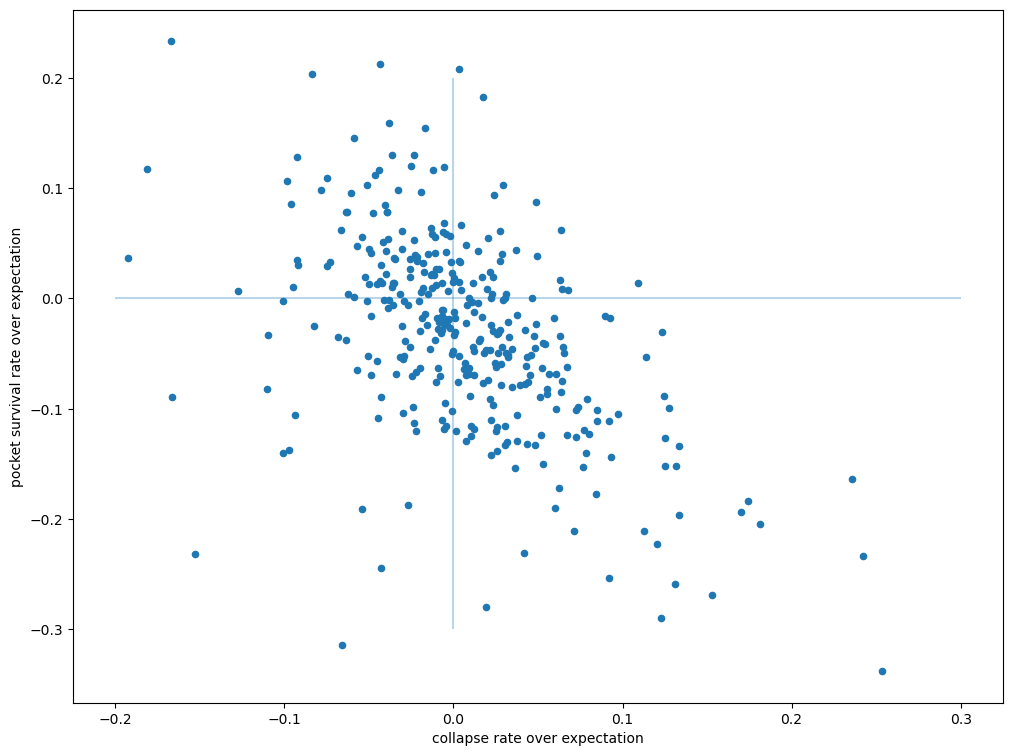

In [207]:
ppu[(ppu.num_snaps>10) & (ppu.officialPosition.isin(["DT", "OLB", "ILB", "DE"]))].plot.scatter(x="collapse_residual", y="surv_residual", figsize=(12,9))
plt.hlines([0], xmin = -.2, xmax=0.3, alpha=.3)
plt.vlines([0], ymin = -.3, ymax= 0.2, alpha=.3)
plt.xlabel("collapse rate over expectation")
plt.ylabel("pocket survival rate over expectation")

##### In this plot, we can see the following: the collapse rate compared to the expectation tells us, how much more often the pocket collapsed, the pocket survival rate over expectation tells us how much more often (or less often) the pocket survived past 3.0 seconds. Combining this allows us to identify players, which are collapsing the pocket at a higher rate and how much of that translates to a loss in pocket survival, as opposed to passing.

In [699]:
import plotly.express as px

pff_pb_df = pd.read_csv("offense_pass_blocking.csv")
pff_pr_df = pd.read_csv("pass_rush_summary.csv")


In [209]:
pr_comp = pff_pr_df.merge(ppu, how="inner", left_on="player", right_on="displayName")
print(pr_comp.shape)
pb_comp = pff_pb_df.merge(ppu, how="inner", left_on="player", right_on="displayName")
print(pb_comp.shape)

(644, 49)
(539, 45)


<Axes: xlabel='surv_residual', ylabel='grades_pass_block'>

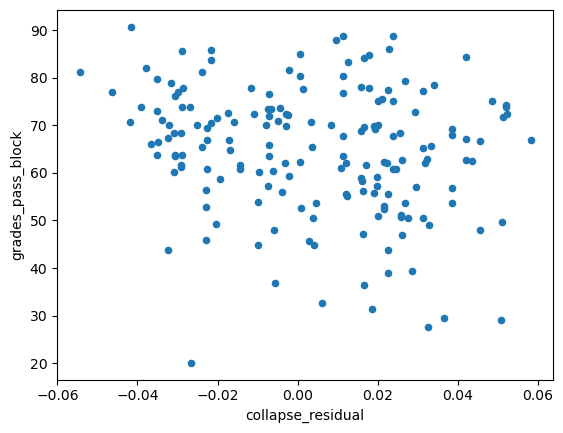

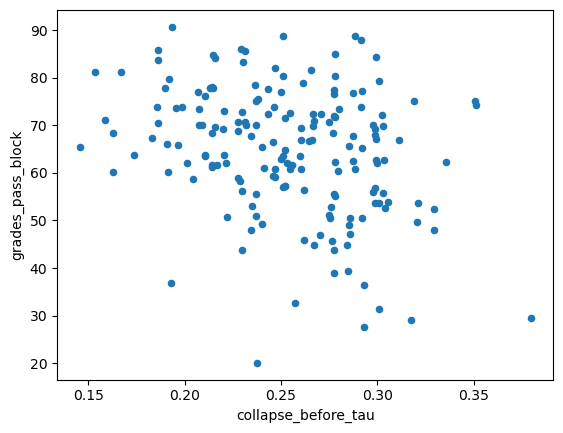

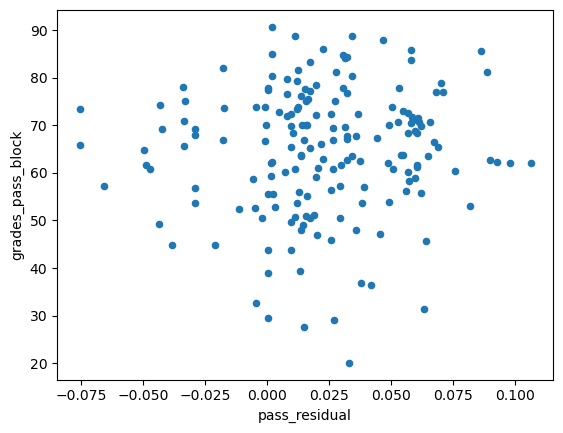

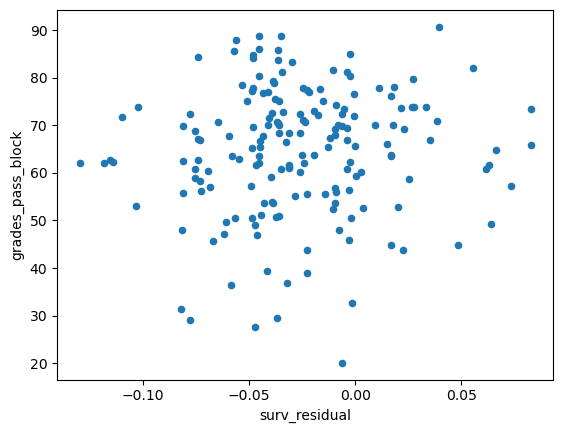

In [709]:
pb_comp[pb_comp.num_snaps > 100].plot.scatter(y = "grades_pass_block", x="collapse_residual")
pb_comp[pb_comp.num_snaps > 100].plot.scatter(y = "grades_pass_block", x="collapse_before_tau")
pb_comp[pb_comp.num_snaps > 100].plot.scatter(y = "grades_pass_block", x="pass_residual")
pb_comp[pb_comp.num_snaps > 100].plot.scatter(y = "grades_pass_block", x="surv_residual")

In [701]:
pr_comp.loc[pr_comp.num_snaps > 50, ["pass_rush_win_rate", "grades_pass_rush_defense", "cif_p", "pass_before_tau", "pass_residual", "cif_c", "collapse_before_tau", "collapse_residual", "surv_tau", "surv_residual"]].corr()

pass_rush_win_rate  grades_pass_rush_defense  \
pass_rush_win_rate                  1.000000                  0.874376   
grades_pass_rush_defense            0.874376                  1.000000   
cif_p                              -0.091266                 -0.127087   
pass_before_tau                     0.066049                  0.108640   
pass_residual                       0.125355                  0.192434   
cif_c                               0.052852                  0.118274   
collapse_before_tau                 0.028905                  0.052460   
collapse_residual                  -0.000658                 -0.018815   
surv_tau                           -0.073198                 -0.124120   
surv_residual                      -0.101676                 -0.145405   

                             cif_p  pass_before_tau  pass_residual     cif_c  \
pass_rush_win_rate       -0.091266         0.066049       0.125355  0.052852   
grades_pass_rush_defense -0.127087         0.108640       0.192434  0.118274   
cif_p                     1.000000         0.395978      -0.172423 -0.547160   
pass_before_tau           0.395978         1.000000       0.836231 -0.126691   
pass_residual            -0.172423         0.836231       1.000000  0.190857   
cif_c                    -0.547160        -0.126691       0.190857  1.000000   
collapse_before_tau      -0.419851        -0.150184       0.089627  0.730598   
collapse_residual        -0.164300        -0.113194      -0.023305  0.248169   
surv_tau                  0.010143        -0.663287      -0.717569 -0.454592   
surv_residual             0.238942        -0.613010      -0.800273 -0.304257   

                          collapse_before_tau  collapse_residual  surv_tau  \
pass_rush_win_rate                   0.028905          -0.000658 -0.073198   
grades_pass_rush_defense             0.052460          -0.018815 -0.124120   
cif_p                               -0.419851          -0.164300  0.010143   
pass_before_tau                     -0.150184          -0.113194 -0.663287   
pass_residual                        0.089627          -0.023305 -0.717569   
cif_c                                0.730598           0.248169 -0.454592   
collapse_before_tau                  1.000000           0.842759 -0.640262   
collapse_residual                    0.842759           1.000000 -0.549979   
surv_tau                            -0.640262          -0.549979  1.000000   
surv_residual                       -0.578465          -0.580822  0.914159   

                          surv_residual  
pass_rush_win_rate            -0.101676  
grades_pass_rush_defense      -0.145405  
cif_p                          0.238942  
pass_before_tau               -0.613010  
pass_residual                 -0.800273  
cif_c                         -0.304257  
collapse_before_tau           -0.578465  
collapse_residual             -0.580822  
surv_tau                       0.914159  
surv_residual                  1.000000

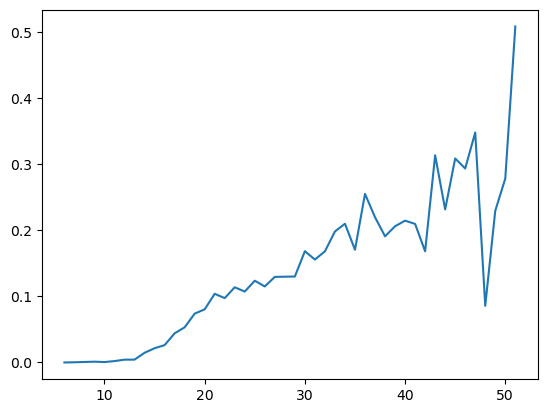

In [ ]:
cph_off.predict_cumulative_hazard(X[17:18]).iloc[:45].diff().fillna(0.).plot(label=False)
plt.show()

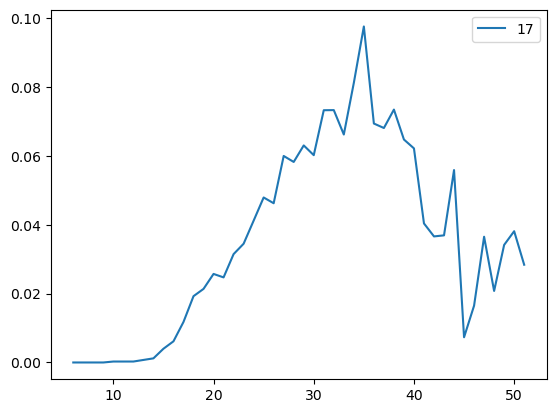

In [726]:
pass_cox_off.predict_cumulative_hazard(X[17:18]).iloc[:45].diff().fillna(0.).plot(label=False)
plt.show()

In [705]:
pb_comp.loc[pb_comp.num_snaps > 100, [ "grades_pass_block", "cif_p", "pass_before_tau", "pass_residual", "cif_c", "collapse_before_tau", "collapse_residual", "surv_tau", "surv_residual"]].corr()


grades_pass_block     cif_p  pass_before_tau  \
grades_pass_block             1.000000  0.025171         0.057189   
cif_p                         0.025171  1.000000         0.821243   
pass_before_tau               0.057189  0.821243         1.000000   
pass_residual                 0.063285 -0.027472         0.547802   
cif_c                        -0.219099 -0.167595        -0.190060   
collapse_before_tau          -0.293645 -0.039594        -0.123938   
collapse_residual            -0.199024  0.152527         0.042784   
surv_tau                      0.133447 -0.684481        -0.786321   
surv_residual                 0.076614 -0.076746        -0.497854   

                     pass_residual     cif_c  collapse_before_tau  \
grades_pass_block         0.063285 -0.219099            -0.293645   
cif_p                    -0.027472 -0.167595            -0.039594   
pass_before_tau           0.547802 -0.190060            -0.123938   
pass_residual             1.000000 -0.087239            -0.159079   
cif_c                    -0.087239  1.000000             0.794646   
collapse_before_tau      -0.159079  0.794646             1.000000   
collapse_residual        -0.148687  0.009691             0.614745   
surv_tau                 -0.373974 -0.330648            -0.515600   
surv_residual            -0.759684  0.068432            -0.267853   

                     collapse_residual  surv_tau  surv_residual  
grades_pass_block            -0.199024  0.133447       0.076614  
cif_p                         0.152527 -0.684481      -0.076746  
pass_before_tau               0.042784 -0.786321      -0.497854  
pass_residual                -0.148687 -0.373974      -0.759684  
cif_c                         0.009691 -0.330648       0.068432  
collapse_before_tau           0.614745 -0.515600      -0.267853  
collapse_residual             1.000000 -0.419695      -0.530108  
surv_tau                     -0.419695  1.000000       0.596660  
surv_residual                -0.530108  0.596660       1.000000